# Prediction_of_H1N1_vaccination
Your task is to predict whether people got H1N1 vaccines using information they shared about their backgrounds, opinions, and health behaviors.



## Data Understanding

### Import Libraries and Data

In [169]:
import pandas as pd
import numpy as np
import scipy
import itertools

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno


from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from IPython.display import clear_output
import category_encoders
try:
    from autoimpute.imputations import SingleImputer, MultipleImputer, MiceImputer
except:
    !pip install autoimpute
    from autoimpute.imputations import SingleImputer, MultipleImputer, MiceImputer

clear_output();
%matplotlib inline


In [170]:
train = pd.read_csv('../Prediction_of_H1N1_vaccination/data/train.csv')
target = pd.read_csv('../Prediction_of_H1N1_vaccination/data/train_labels.csv')
test = pd.read_csv('../Prediction_of_H1N1_vaccination/data/test.csv')
submission = pd.read_csv('../Prediction_of_H1N1_vaccination/data/submission.csv')

In [171]:
train.shape, target.shape, test.shape, submission.shape

((42154, 38), (42154, 2), (28104, 38), (28104, 2))

In [172]:
df=pd.concat([train,target],axis=1)
df.shape

(42154, 40)

In [173]:
np.random.seed(42)

### Data Describe and EDA

#### Pandas Profiling

In [174]:
#ProfileReport(df, title="Pandas Profiling Report", explorative=True)

#### Univariate analysis

Including Data re-expression, type casting, Outliers

In [175]:
def EDA_plot1(df,column):
    uniqs = len(df[column].dropna().unique())
    #히스토그램, 박스플롯
    if pd.api.types.is_numeric_dtype(df[column]) and uniqs>30:
        ax1=sns.boxplot(x=df[column],data=df)
        plt.show()
    if uniqs<=10:
        #바플롯세로
        ax1=sns.countplot(x=column,data=df)
        for p in ax1.patches:
            percentage = f'{100 * p.get_height() / len(df):.1f}%\n'
            x = p.get_x() + p.get_width() / 2
            y = p.get_height()
            ax1.annotate(percentage, (x, y), ha='center', va='center')
        plt.tight_layout()
        plt.show()

    else:
        fig, ax = plt.subplots(figsize=(8,4+uniqs/3),nrows=2,ncols=1)
        ax1=sns.countplot(y=column,data=df)
        plt.tight_layout()
        plt.show()

In [176]:
def EDA_plot2(df,column_name,rot=0):
    fig1, axs1 = plt.subplots(figsize=(16,6),nrows=1,ncols=2)
    order=sorted(df[f'{column_name}'].dropna().unique())
    ax1=sns.countplot(x=f'{column_name}', data=df[df['vacc_h1n1_f']==0],ax=axs1[0], order=order)
    ax2=sns.countplot(x=f'{column_name}', data=df[df['vacc_h1n1_f']==1],ax=axs1[1], order=order)
    ax1.tick_params(rotation=rot)
    ax2.tick_params(rotation=rot)
    ax1.set_title(f'count of {column_name} when target=0')
    ax2.set_title(f'count of {column_name} when target=1')
    
    
    col_sum0=df[df['vacc_h1n1_f']==0].groupby(f'{column_name}').count()['vacc_h1n1_f'].sum()
    col_sum1=df[df['vacc_h1n1_f']==1].groupby(f'{column_name}').count()['vacc_h1n1_f'].sum()
    a=df[df['vacc_h1n1_f']==0].groupby(f'{column_name}').count()['vacc_h1n1_f'].apply(lambda x: x/col_sum0*100)
    b=df[df['vacc_h1n1_f']==1].groupby(f'{column_name}').count()['vacc_h1n1_f'].apply(lambda x: x/col_sum1*100)
    c=(a-b).apply(lambda x: abs(x)).reset_index()
    fig2, axs2 = plt.subplots(figsize=(16,10),nrows=1,ncols=1)
    ax3=sns.barplot(x=f'{column_name}',y='vacc_h1n1_f',data=c,ax=axs2)
    ax3.tick_params(rotation=rot)
    ax3.set_title(f'ratio difference of counts of each categories of "{column_name}" columns by target')
    return

In [177]:
type_feature={}

##### (target) vacc_h1n1_f

- Description : Whether respondent received H1N1 flu vaccine.

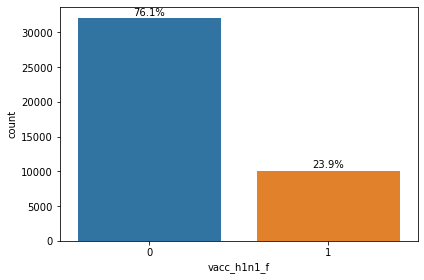

In [178]:
EDA_plot1(df,'vacc_h1n1_f')

- Note : Nominal, Imbalanced Data

In [179]:
type_feature['vacc_h1n1_f'] = 'bool'

##### vacc_seas_f

- Description : Whether respondent received seasonal flu vaccine.

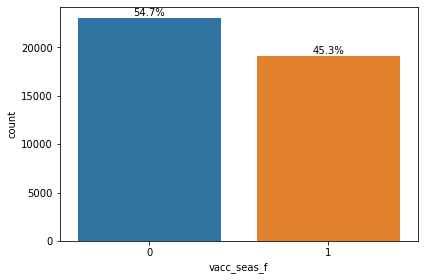

In [180]:
EDA_plot1(df,'vacc_seas_f')

- Note : boolean, Imbalanced Data, dependent variable

In [181]:
type_feature['vacc_seas_f'] = 'bool'

##### h1n1_concern 

- Description : Level of concern about the H1N1 flu.   
0 = Not at all concerned; 1 = Not very concerned; 2 = Somewhat concerned; 3 = Very concerned.   

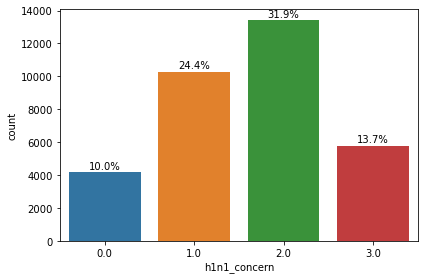

In [182]:
EDA_plot1(df,'h1n1_concern')

- Note : ordinal categorical type

In [183]:
type_feature['h1n1_concern'] = 'ordinal'

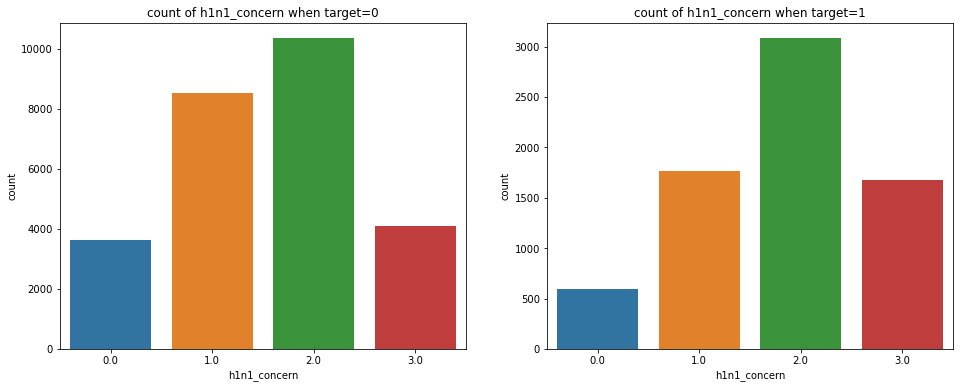

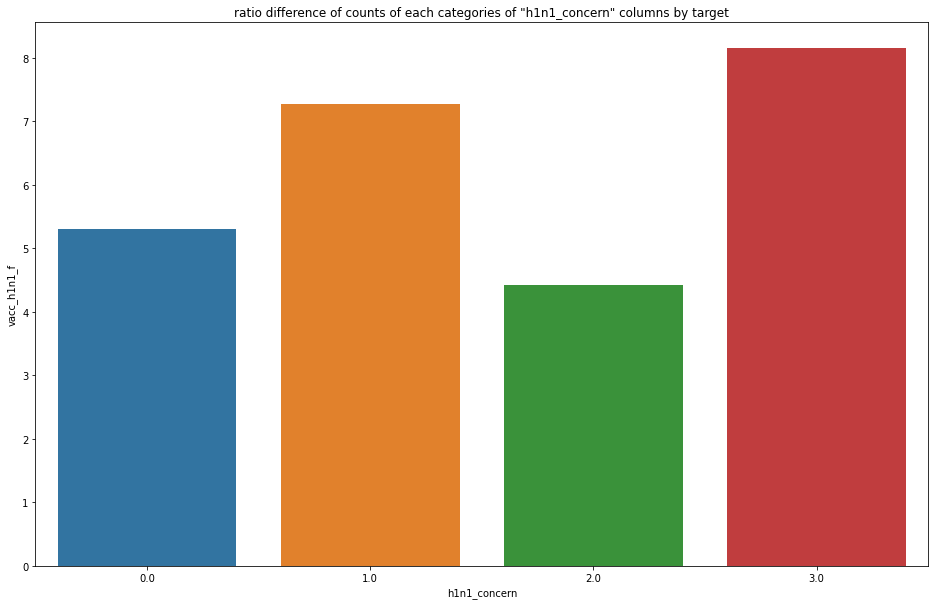

In [184]:
EDA_plot2(df,'h1n1_concern')

##### h1n1_knowledge

- Description : Level of knowledge about H1N1 flu.   
0 = No knowledge; 1 = A little knowledge; 2 = A lot of knowledge.   

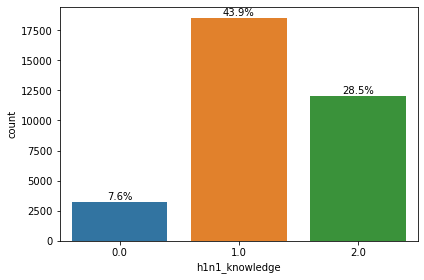

In [185]:
EDA_plot1(df,'h1n1_knowledge')

- Note : ordinal categorical type

In [186]:
type_feature['h1n1_knowledge'] = 'ordinal'

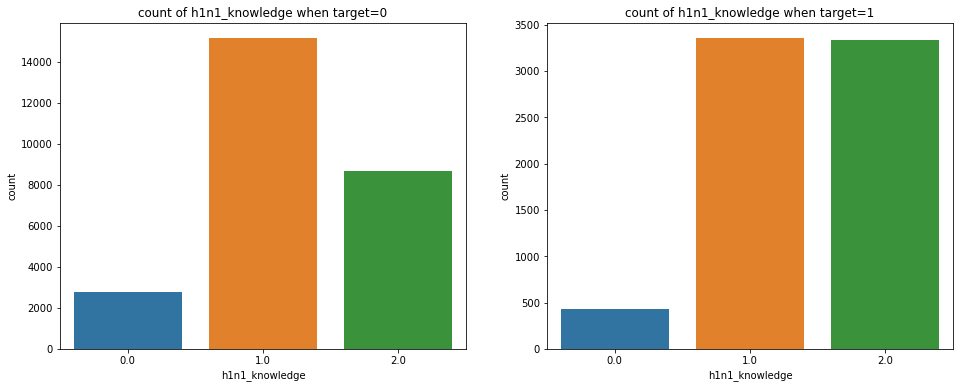

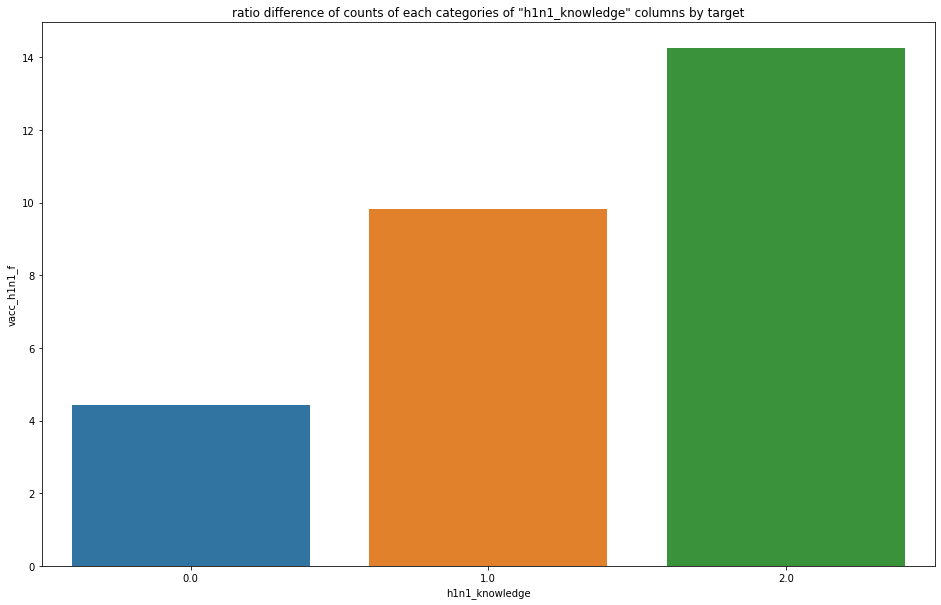

In [187]:
EDA_plot2(df,'h1n1_knowledge')

##### behavioral_antiviral_meds

- Description : Has taken antiviral medications.

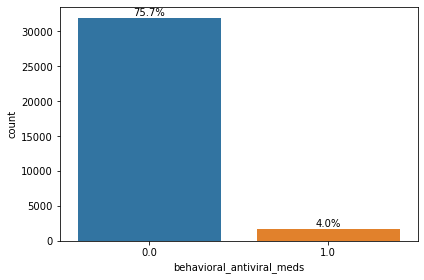

In [188]:
EDA_plot1(df,'behavioral_antiviral_meds')

- Note : boolean, Imbalanced

In [189]:
type_feature['behavioral_antiviral_meds'] = 'bool'

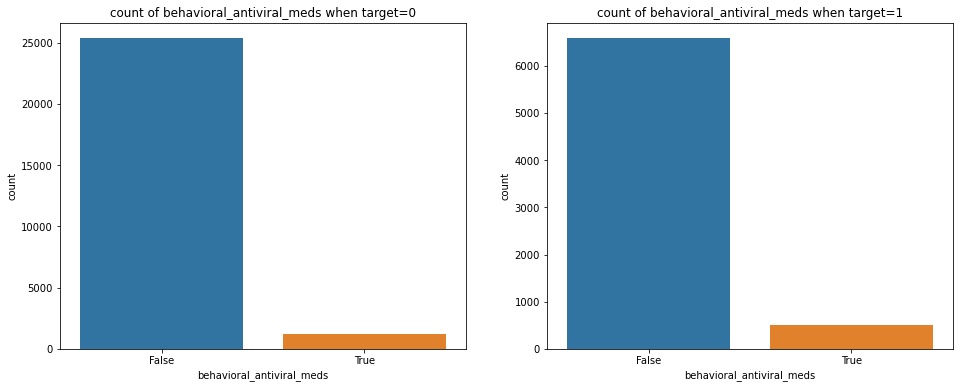

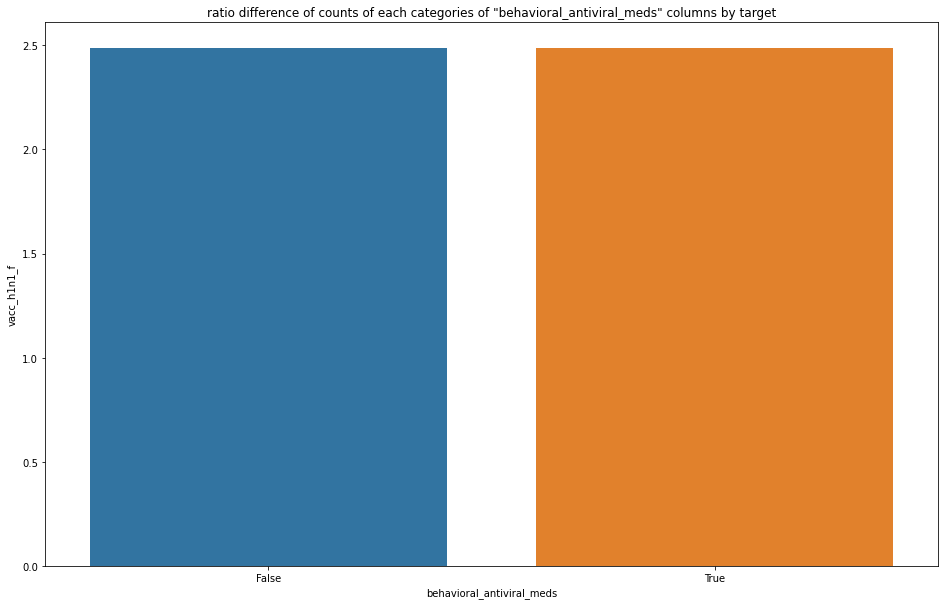

In [190]:
EDA_plot2(df,'behavioral_antiviral_meds')

##### behavioral_avoidance

- Description : Has avoided close contact with others with flu-like symptoms.

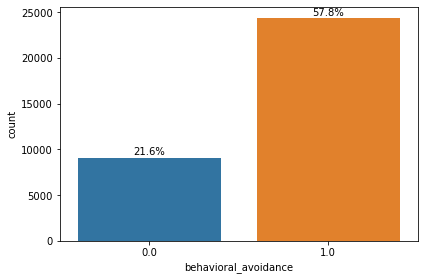

In [191]:
EDA_plot1(df,'behavioral_avoidance')

- Note : boolean

In [192]:
type_feature['behavioral_avoidance'] = 'bool'

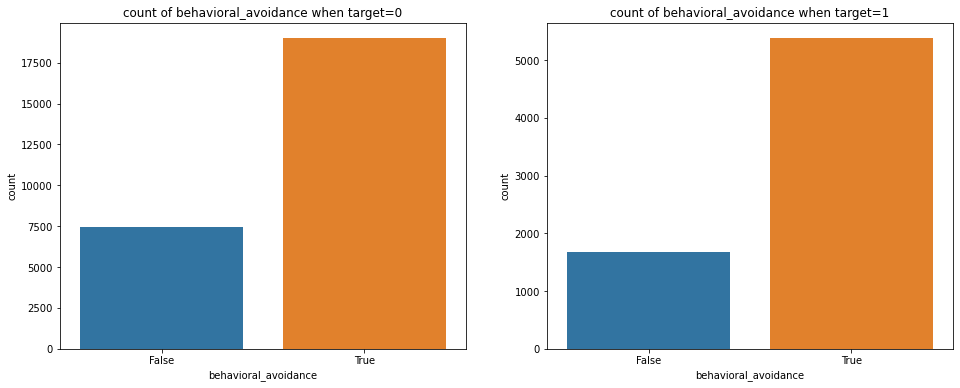

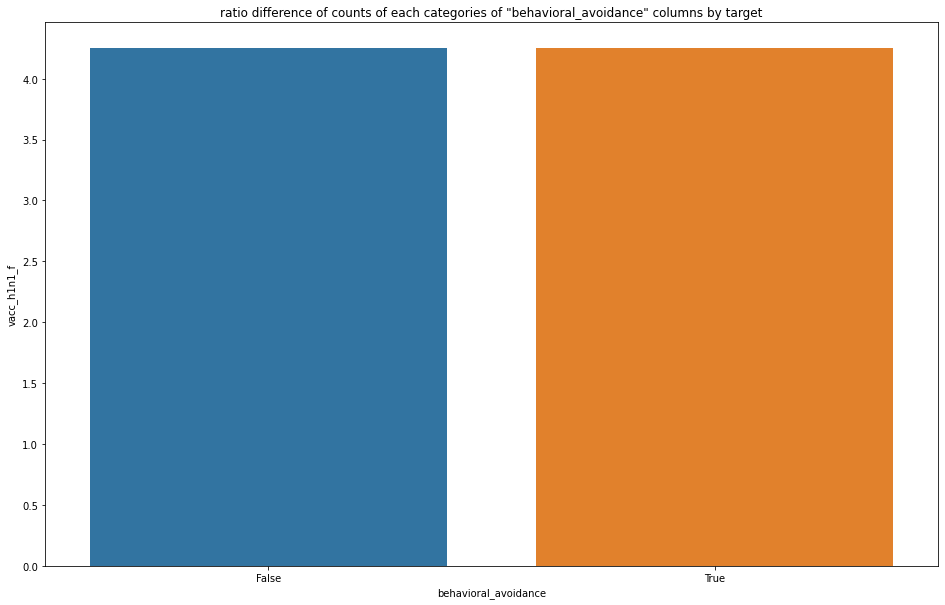

In [193]:
EDA_plot2(df,'behavioral_avoidance')

##### behavioral_face_mask

- Description : Has bought a face mask.

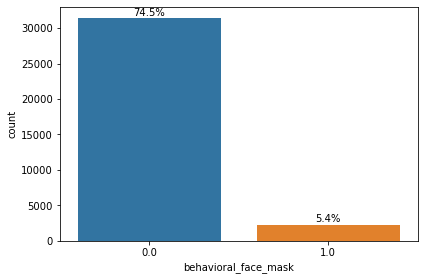

In [194]:
EDA_plot1(df,'behavioral_face_mask')

- Note : boolean, Imbalanced

In [195]:
type_feature['behavioral_face_mask'] = 'bool'

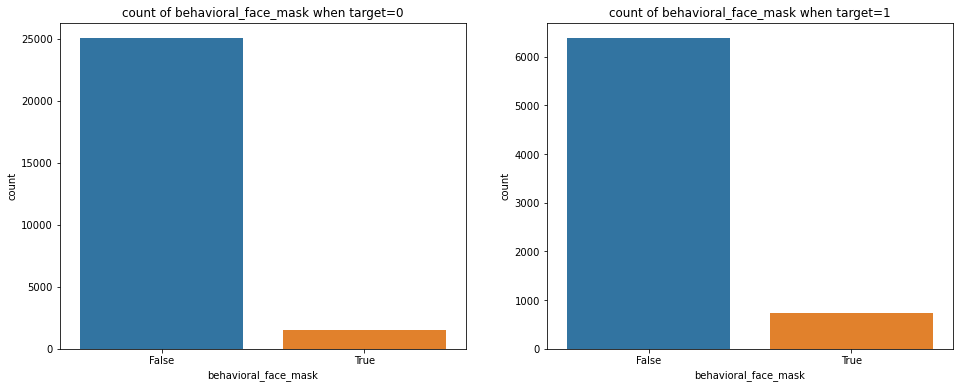

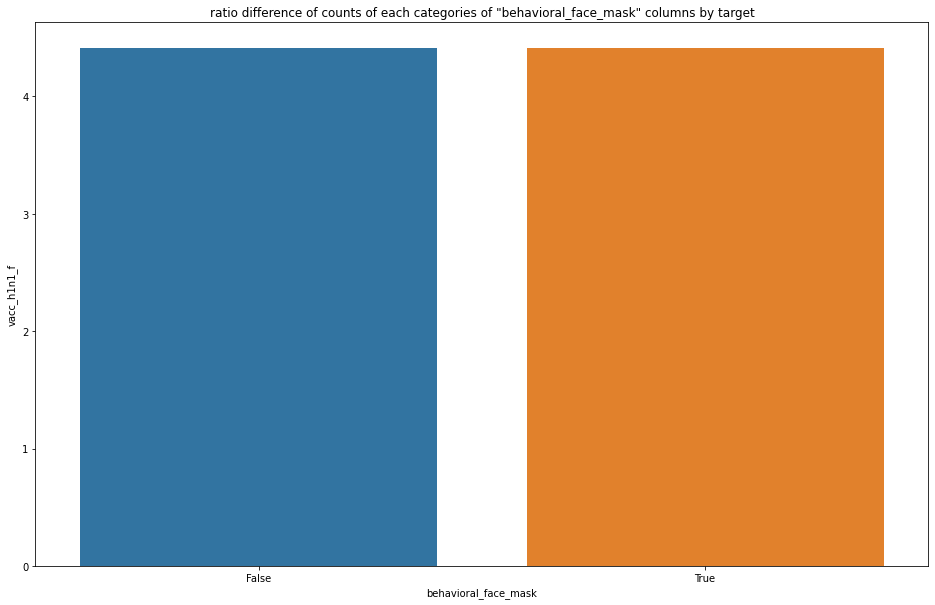

In [196]:
EDA_plot2(df,'behavioral_face_mask')

##### behavioral_wash_hands

- Description : Has frequently washed hands or used hand sanitizer.

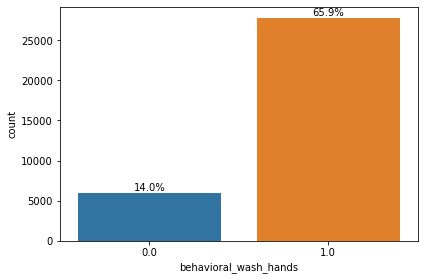

In [197]:
EDA_plot1(df,'behavioral_wash_hands')

- Note : boolean

In [198]:
type_feature['behavioral_wash_hands'] = 'bool'

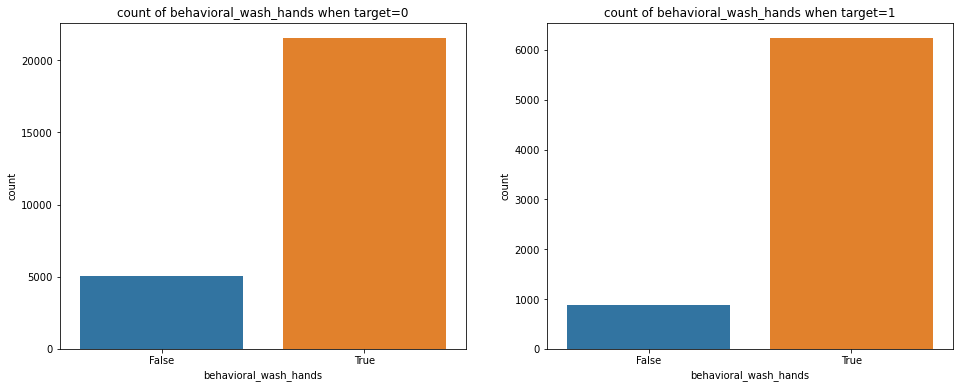

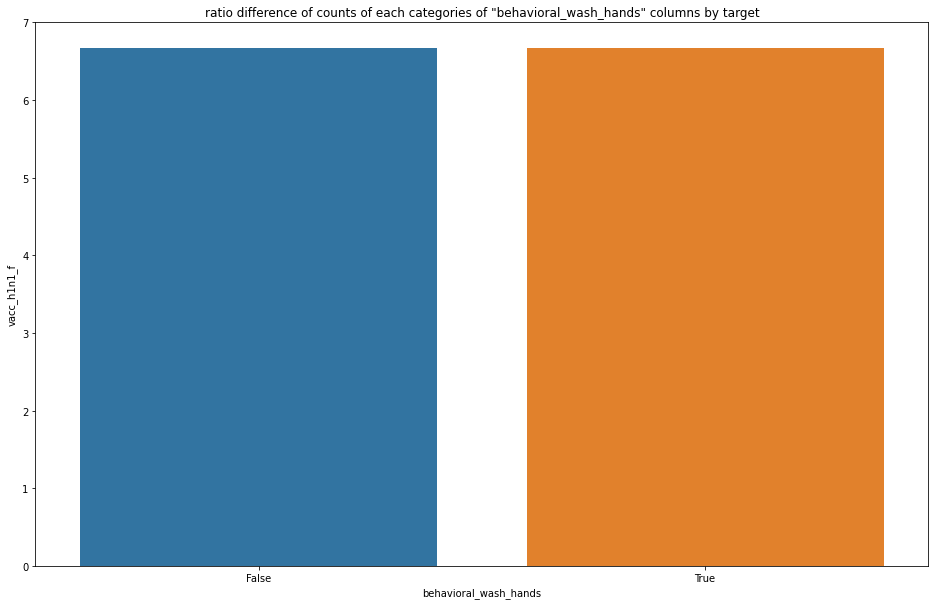

In [199]:
EDA_plot2(df,'behavioral_wash_hands')

##### behavioral_large_gatherings

- Description : Has reduced time at large gatherings.

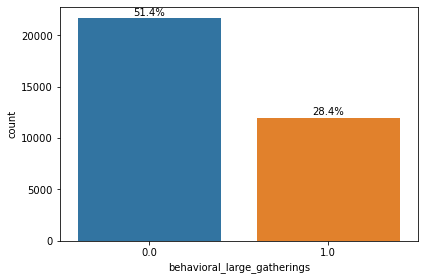

In [200]:
EDA_plot1(df,'behavioral_large_gatherings')

In [201]:
type_feature['behavioral_large_gatherings'] = 'bool'

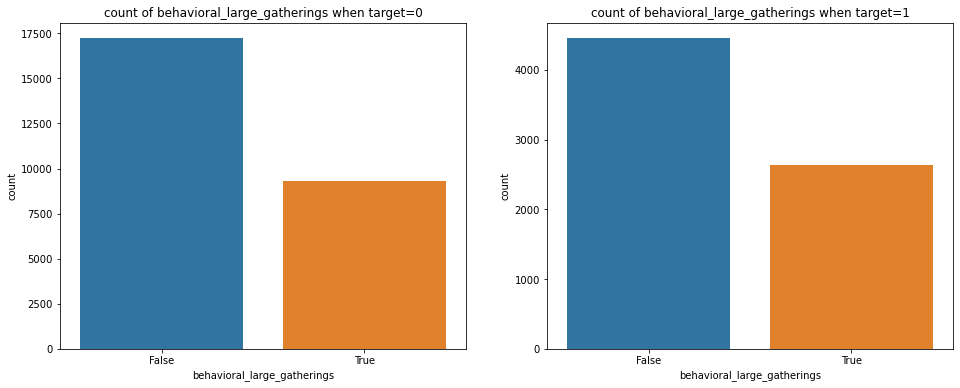

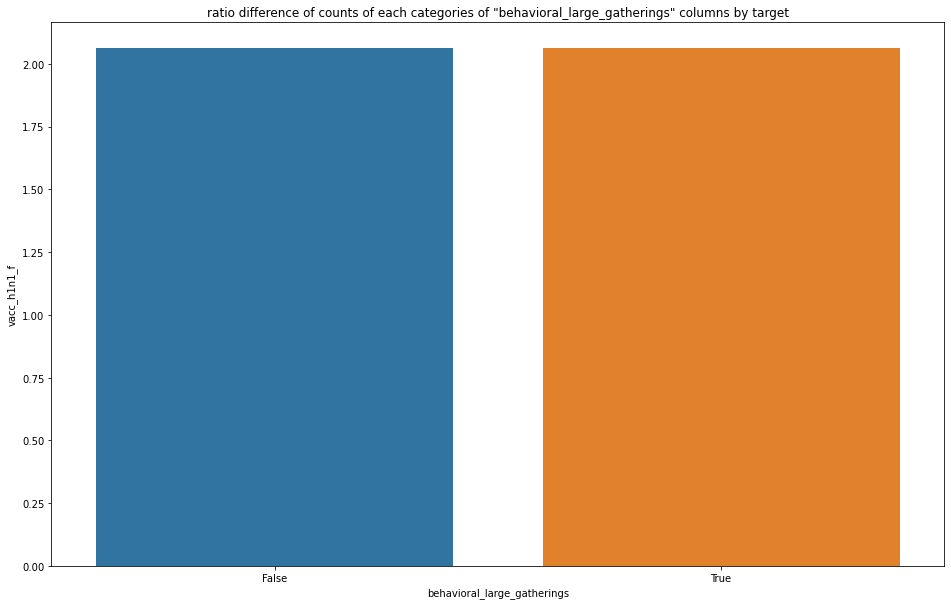

In [202]:
EDA_plot2(df,'behavioral_large_gatherings')

##### behavioral_outside_home

- Description : Has reduced contact with people outside of own household.

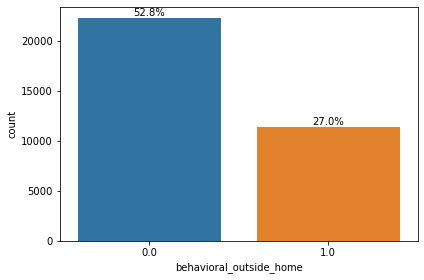

In [203]:
EDA_plot1(df,'behavioral_outside_home')

In [204]:
type_feature['behavioral_outside_home'] = 'bool'

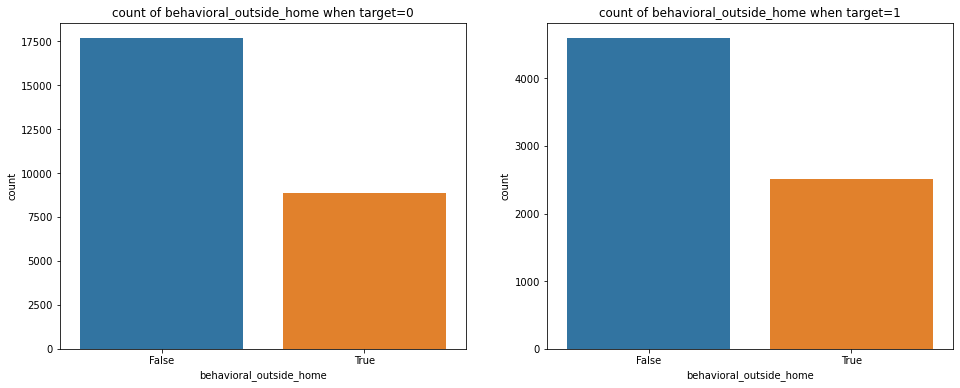

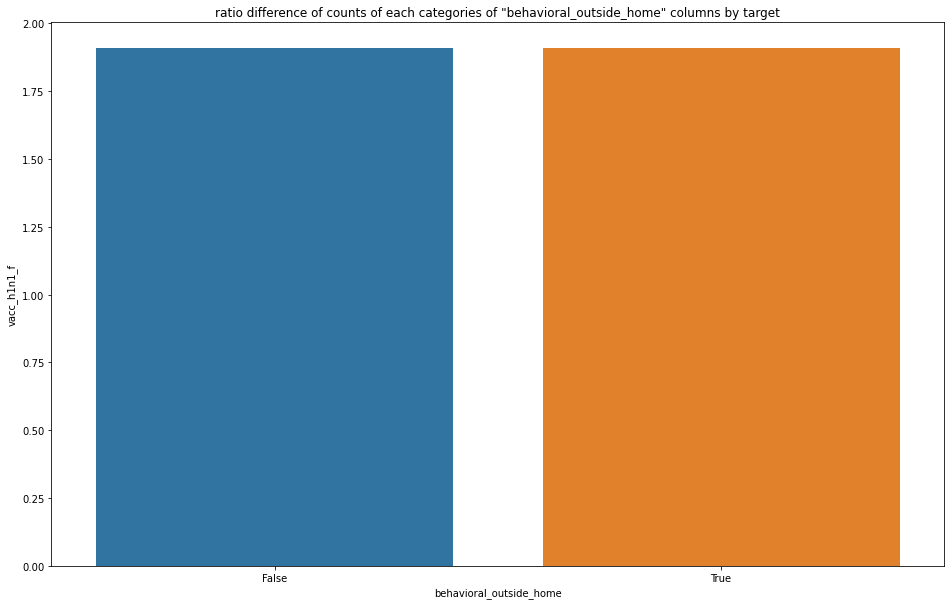

In [205]:
EDA_plot2(df,'behavioral_outside_home')

##### behavioral_touch_face

- Description : Has avoided touching eyes, nose, or mouth.

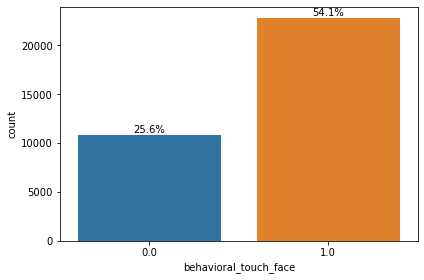

In [206]:
EDA_plot1(df,'behavioral_touch_face')

- Note : boolean

In [207]:
type_feature['behavioral_touch_face'] = 'bool'

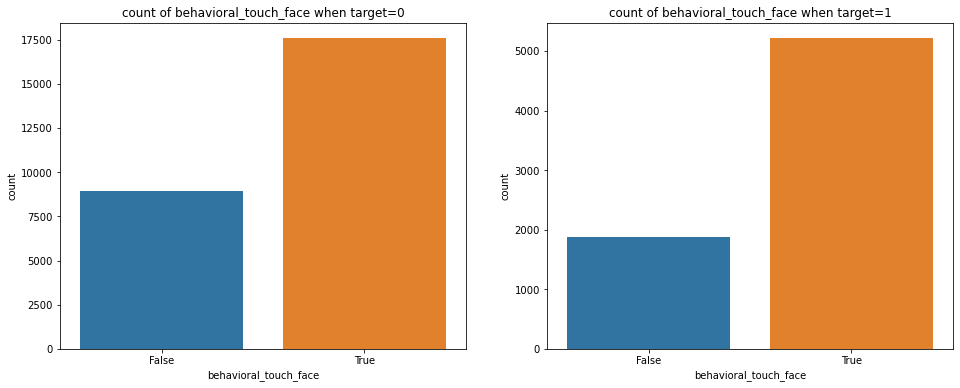

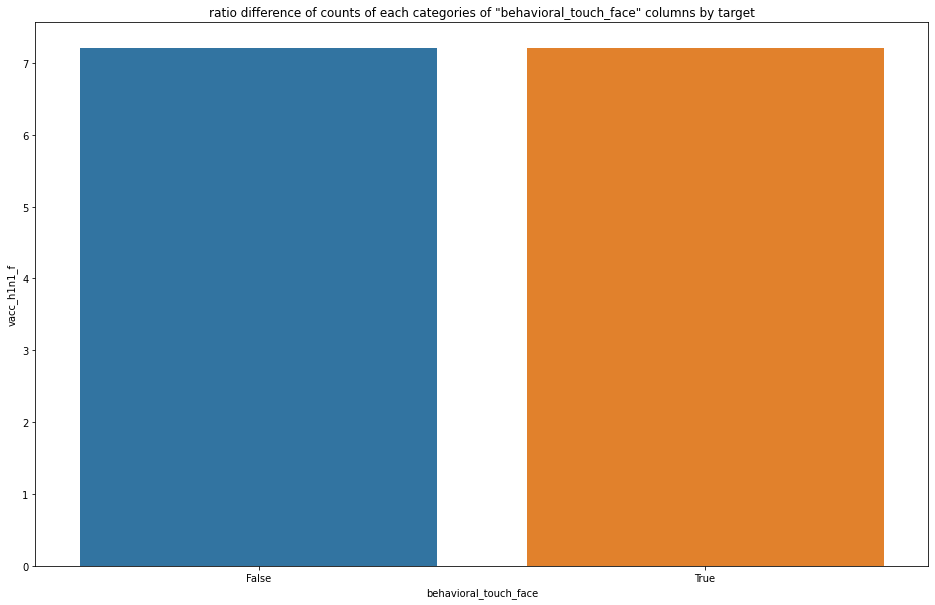

In [208]:
EDA_plot2(df,'behavioral_touch_face')

##### doctor_recc_h1n1

- Description : H1N1 flu vaccine was recommended by doctor.

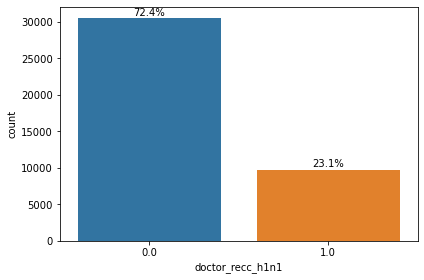

In [209]:
EDA_plot1(df,'doctor_recc_h1n1')

In [210]:
type_feature['doctor_recc_h1n1'] = 'bool'

- Note : boolean

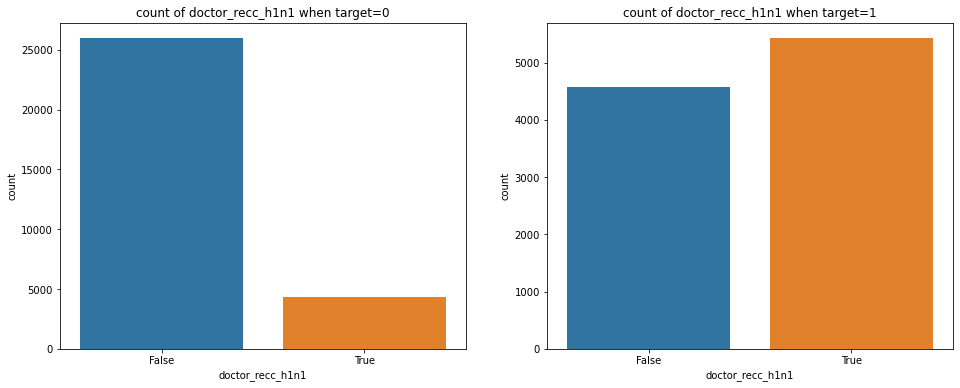

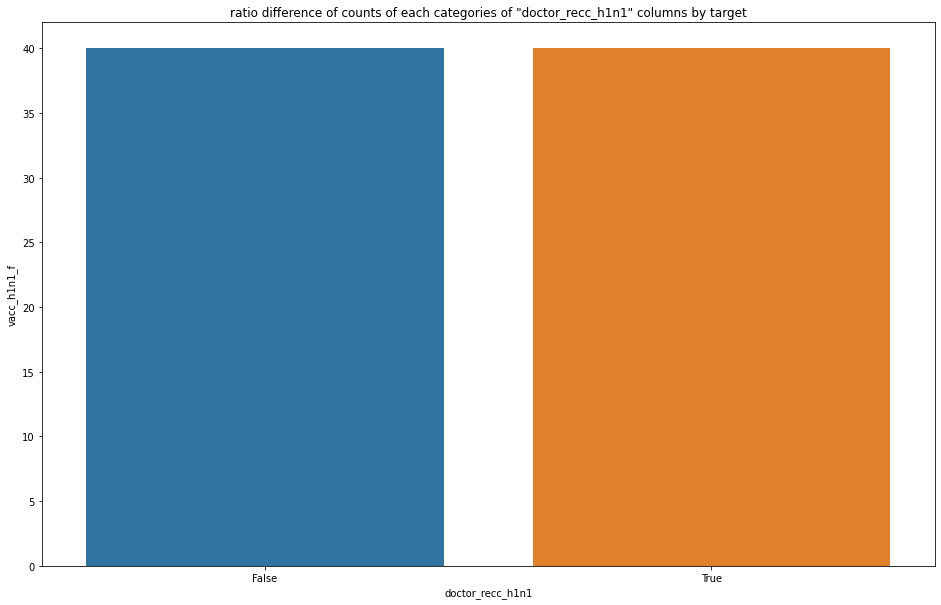

In [211]:
EDA_plot2(df,'doctor_recc_h1n1')

##### doctor_recc_seasonal

- Description : Seasonal flu vaccine was recommended by doctor.

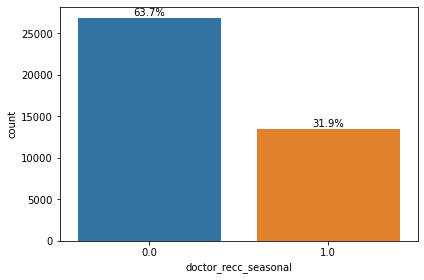

In [212]:
EDA_plot1(df,'doctor_recc_seasonal')

- Note : boolean, seasonal

In [213]:
type_feature['doctor_recc_seasonal'] = 'bool'

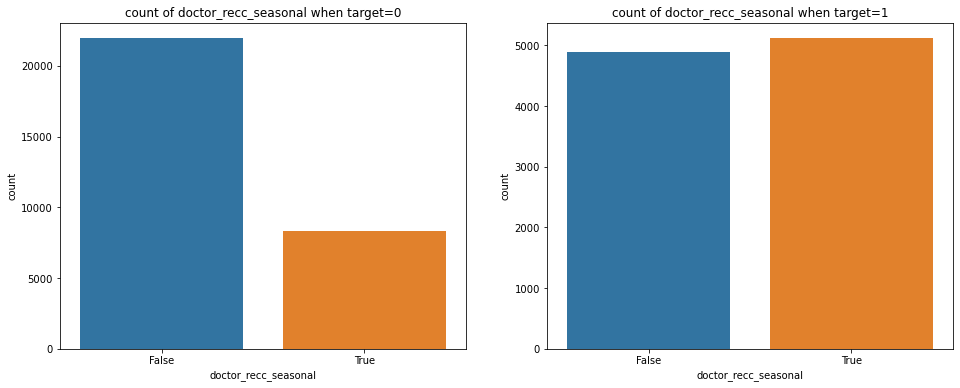

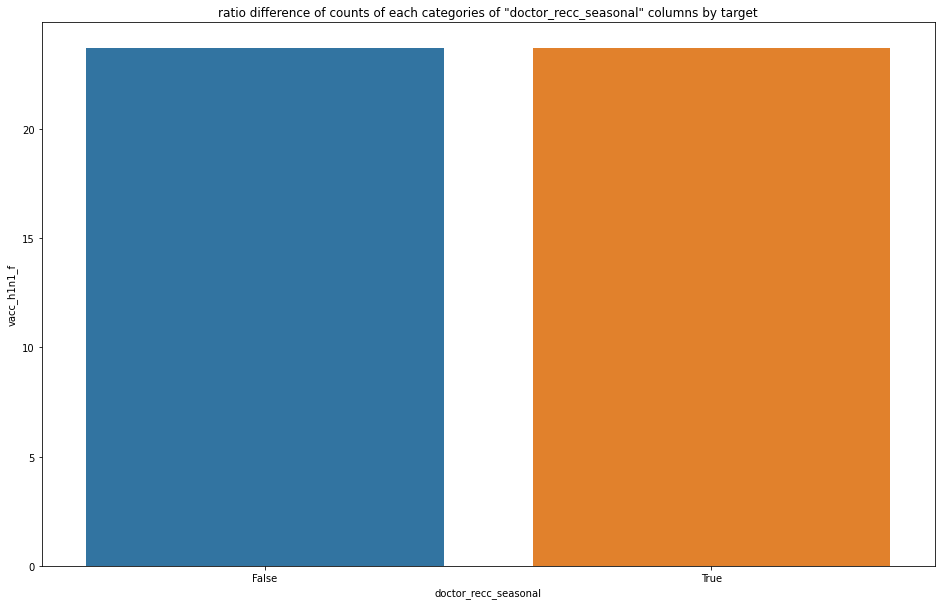

In [214]:
EDA_plot2(df,'doctor_recc_seasonal')

##### chronic_med_condition

- Description : Has any of the following chronic medical conditions: asthma or an other lung condition, diabetes, a heart condition, a kidney condition, sickle cell anemia or other anemia, a neurological or neuromuscular condition, a liver condition, or a weakened immune system caused by a chronic illness or by medicines taken for a chronic illness. 

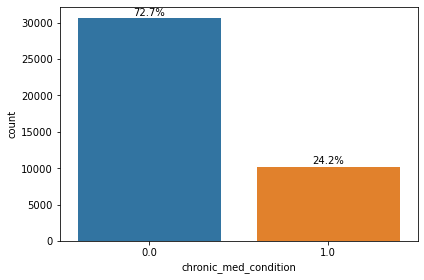

In [215]:
EDA_plot1(df,'chronic_med_condition')

- Note : boolean

In [216]:
type_feature['chronic_med_condition'] = 'bool'

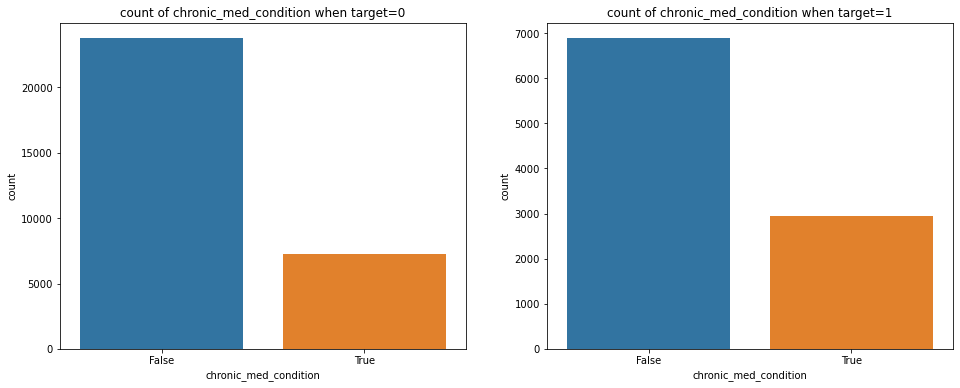

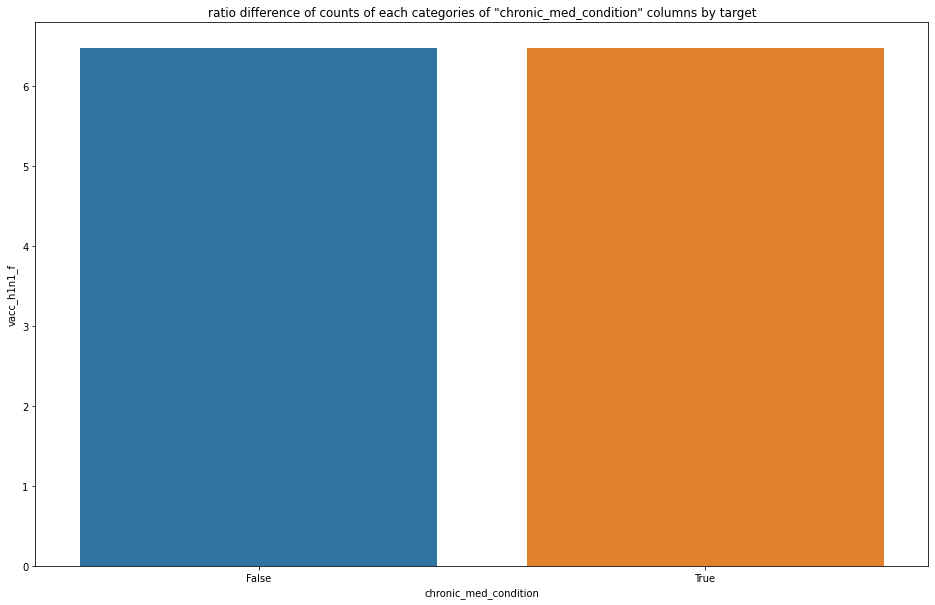

In [217]:
EDA_plot2(df,'chronic_med_condition')

##### child_under_6_months

- Description : Has regular close contact with a child under the age of six months.

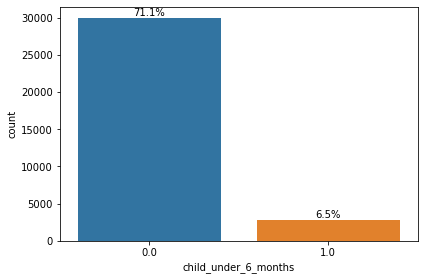

In [218]:
EDA_plot1(df,'child_under_6_months')

- Note : boolean, Imbalanced

In [219]:
type_feature['child_under_6_months'] = 'bool'

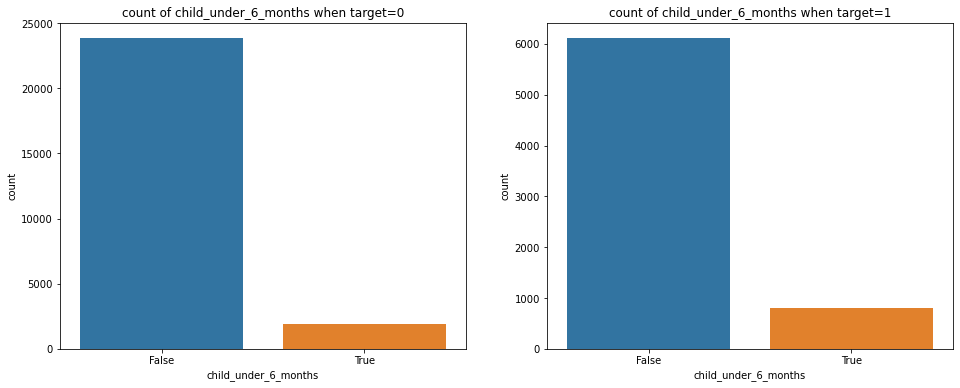

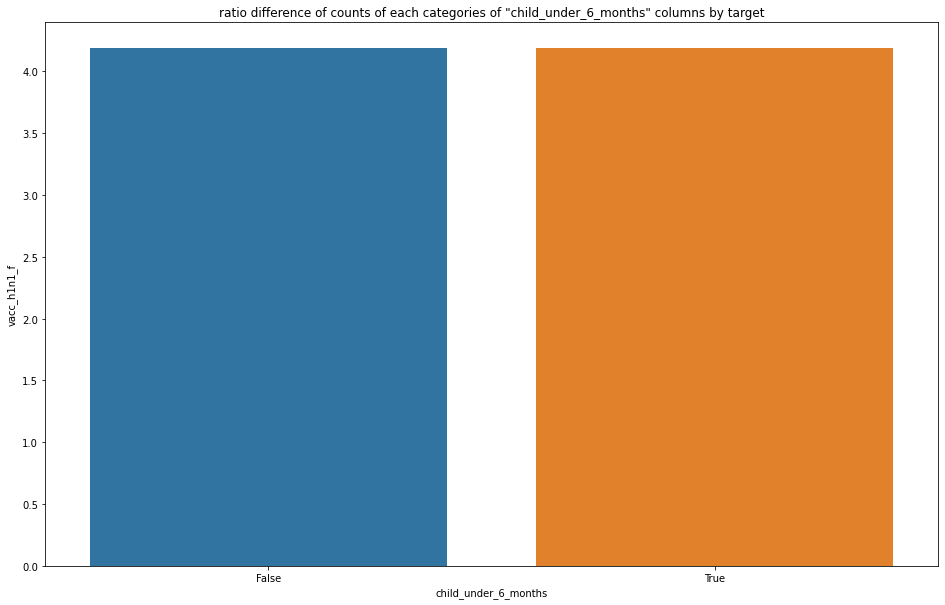

In [220]:
EDA_plot2(df,'child_under_6_months')

##### health_insurance

- Description : Has health insurance.

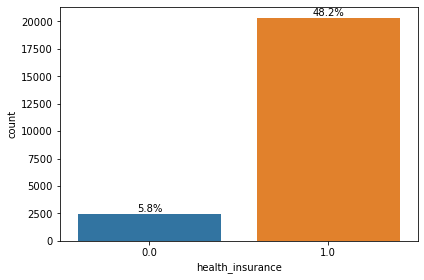

In [221]:
EDA_plot1(df,'health_insurance')

- Note : boolean

In [222]:
type_feature['health_insurance'] = 'bool'

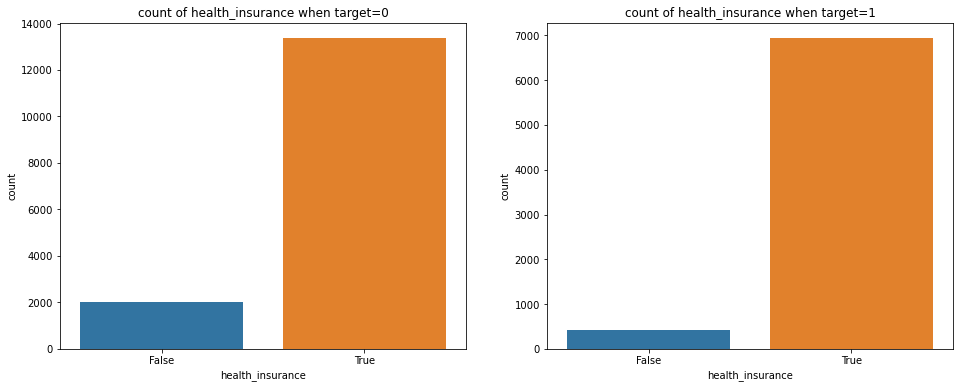

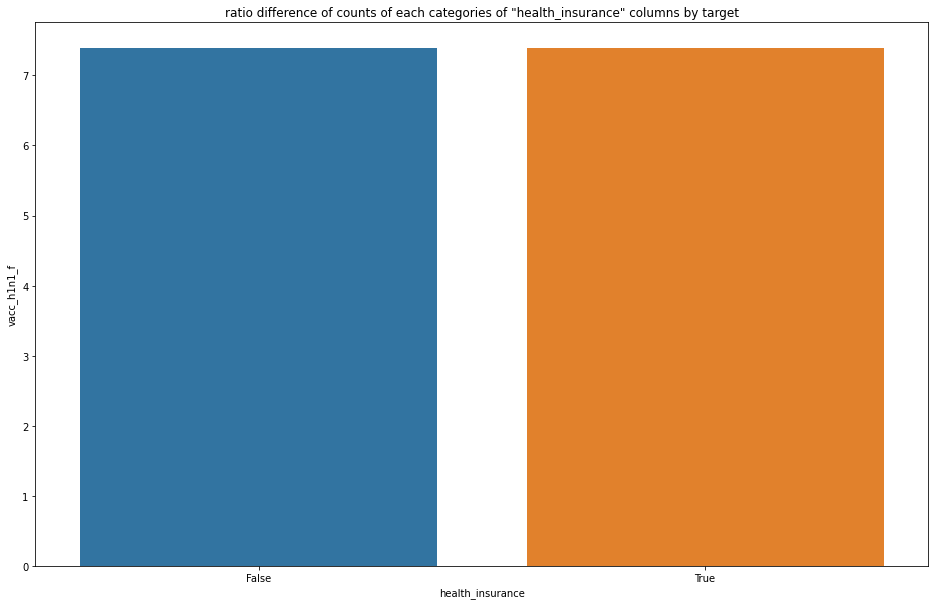

In [223]:
EDA_plot2(df,'health_insurance')

##### health_worker

- Description : Is a healthcare worker.

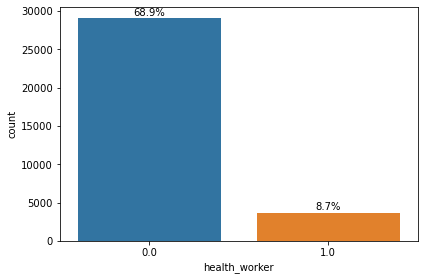

In [224]:
EDA_plot1(df,'health_worker')

- Note : boolean

In [225]:
type_feature['health_worker'] = 'bool'

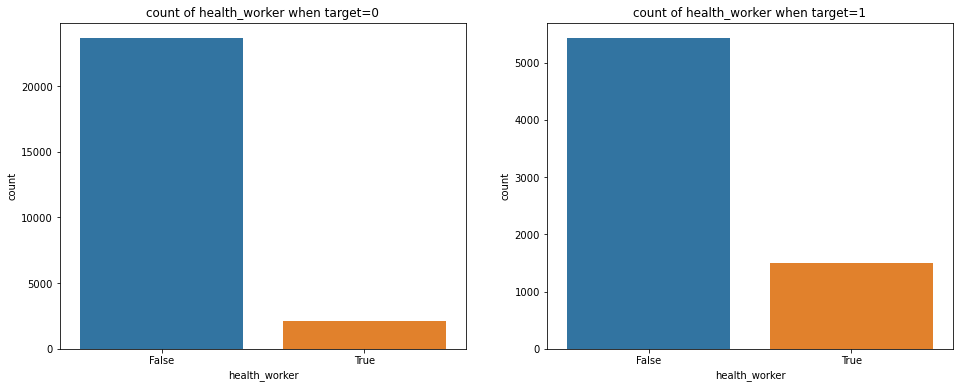

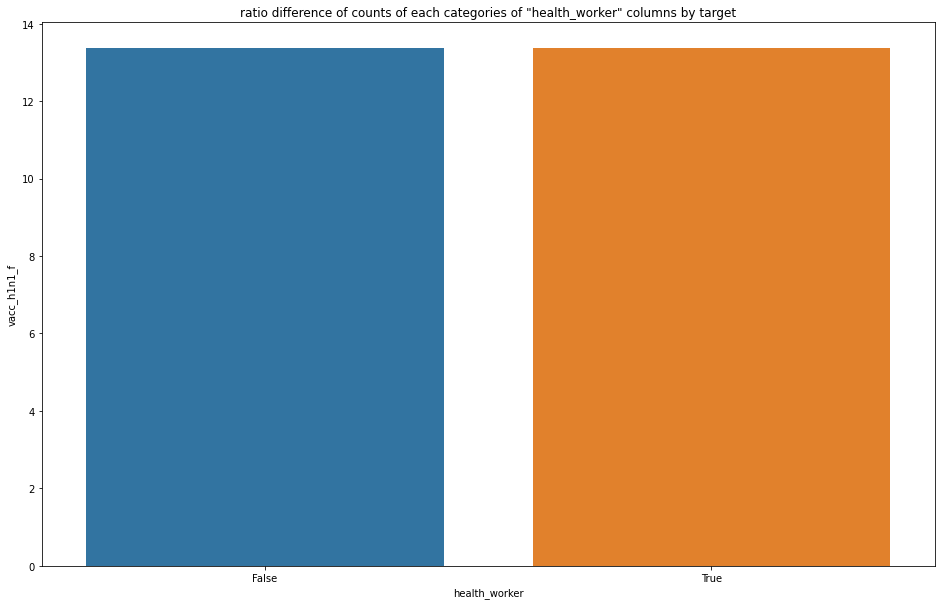

In [226]:
EDA_plot2(df,'health_worker')

##### opinion_h1n1_vacc_effective

- Description : Respondent's opinion about H1N1 vaccine effectiveness.   

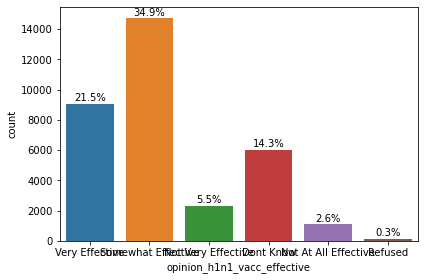

In [227]:
EDA_plot1(df,'opinion_h1n1_vacc_effective')

- Note : ordered categorical type, Don't Know/Refused -> nan

In [228]:
df['opinion_h1n1_vacc_effective'].replace('Dont Know',np.nan,inplace=True)
df['opinion_h1n1_vacc_effective'].replace('Refused',np.nan,inplace=True)
df['opinion_h1n1_vacc_effective'].replace('Not At All Effective',0,inplace=True)
df['opinion_h1n1_vacc_effective'].replace('Not Very Effective',1,inplace=True)
df['opinion_h1n1_vacc_effective'].replace('Somewhat Effective',2,inplace=True)
df['opinion_h1n1_vacc_effective'].replace('Very Effective',3,inplace=True)
type_feature['opinion_h1n1_vacc_effective'] = 'ordinal'

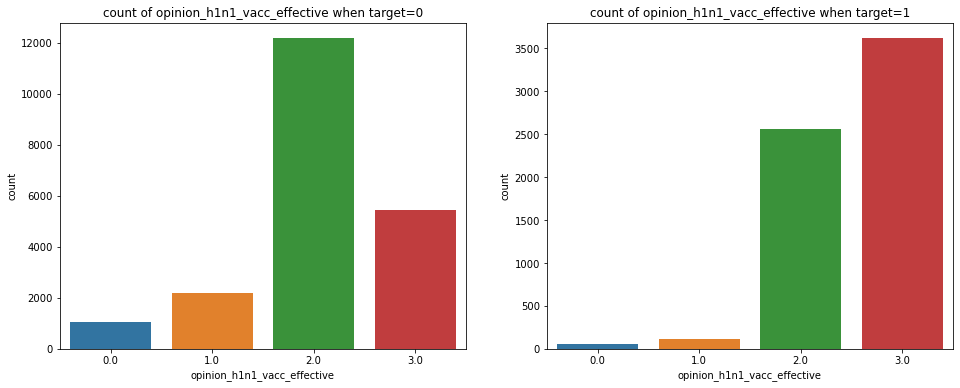

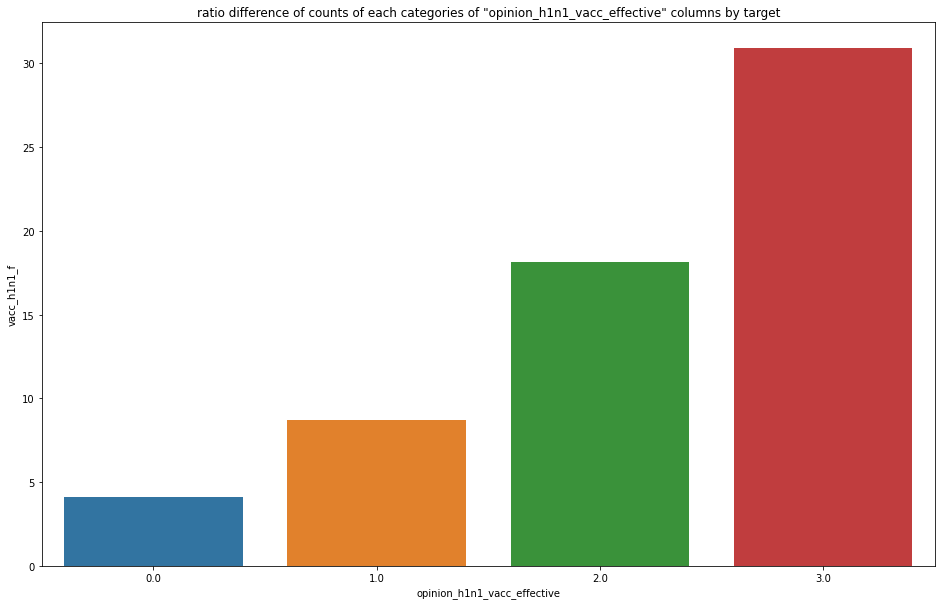

In [229]:
EDA_plot2(df,'opinion_h1n1_vacc_effective')

##### opinion_h1n1_risk
Remarks : Don't Know, Refused -> nan

- Description : Respondent's opinion about risk of getting sick with H1N1 flu without vaccine.  

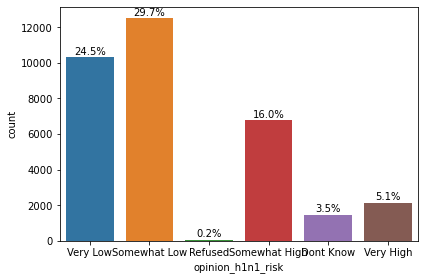

In [230]:
EDA_plot1(df,'opinion_h1n1_risk')

- Note : ordered categorical type, Don't Know/Refused -> nan

In [231]:
df['opinion_h1n1_risk'].replace('Dont Know',np.nan,inplace=True)
df['opinion_h1n1_risk'].replace('Refused',np.nan,inplace=True)
df['opinion_h1n1_risk'].replace('Very Low',1,inplace=True)
df['opinion_h1n1_risk'].replace('Somewhat Low',2,inplace=True)
df['opinion_h1n1_risk'].replace('Somewhat High',3,inplace=True)
df['opinion_h1n1_risk'].replace('Very High',4,inplace=True)
type_feature['opinion_h1n1_risk'] = 'ordinal'

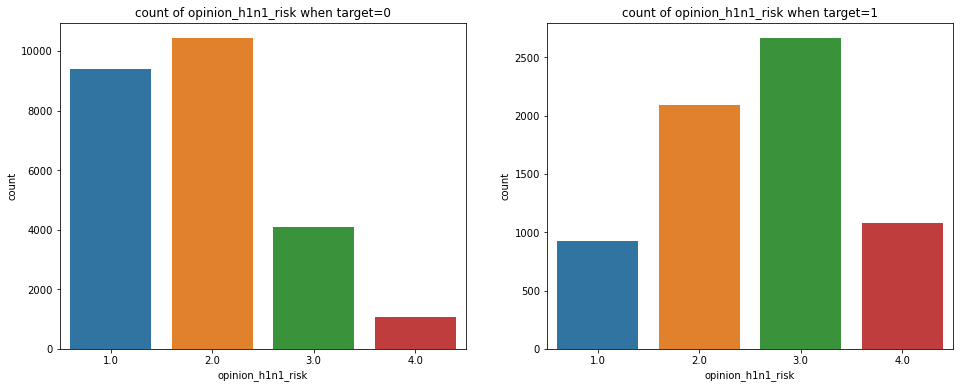

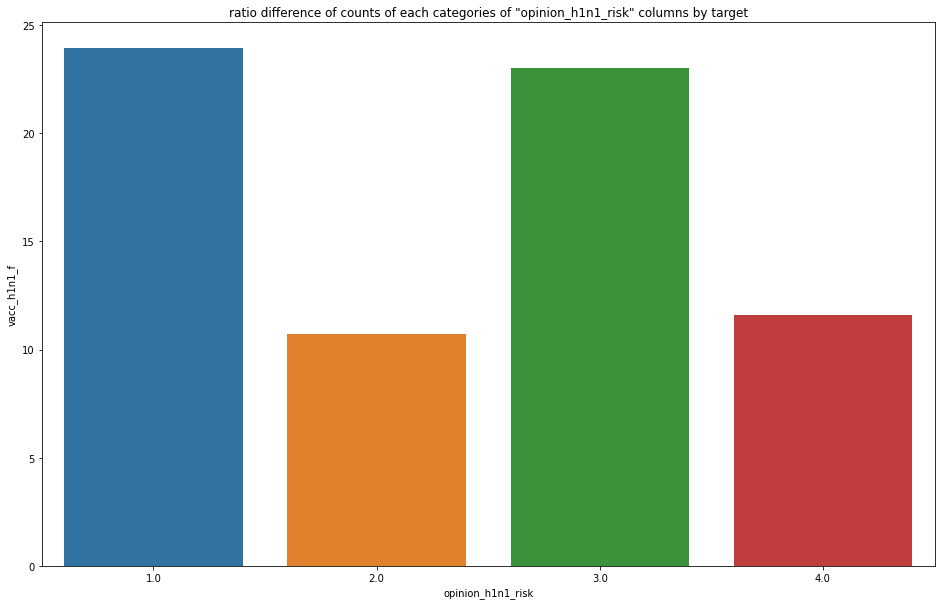

In [232]:
EDA_plot2(df,'opinion_h1n1_risk')

##### opinion_h1n1_sick_from_vacc

- Description : Respondent's worry of getting sick from taking H1N1 vaccine.   

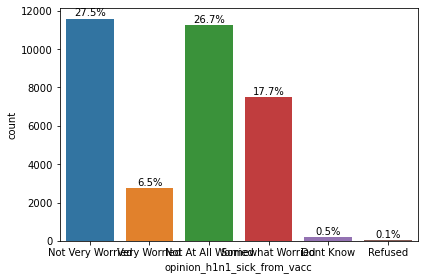

In [233]:
EDA_plot1(df,'opinion_h1n1_sick_from_vacc')

- Note : ordered categorical type, Don't Know/Refused -> nan

In [234]:
df['opinion_h1n1_sick_from_vacc'].replace('Dont Know',np.nan,inplace=True)
df['opinion_h1n1_sick_from_vacc'].replace('Refused',np.nan,inplace=True)
df['opinion_h1n1_sick_from_vacc'].replace('Not At All Worried',0,inplace=True)
df['opinion_h1n1_sick_from_vacc'].replace('Not Very Worried',1,inplace=True)
df['opinion_h1n1_sick_from_vacc'].replace('Somewhat Worried',2,inplace=True)
df['opinion_h1n1_sick_from_vacc'].replace('Very Worried',3,inplace=True)
type_feature['opinion_h1n1_sick_from_vacc'] = 'ordinal'

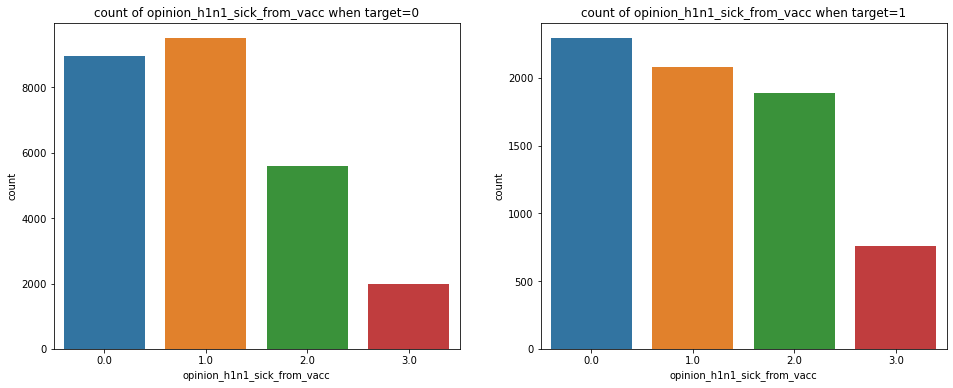

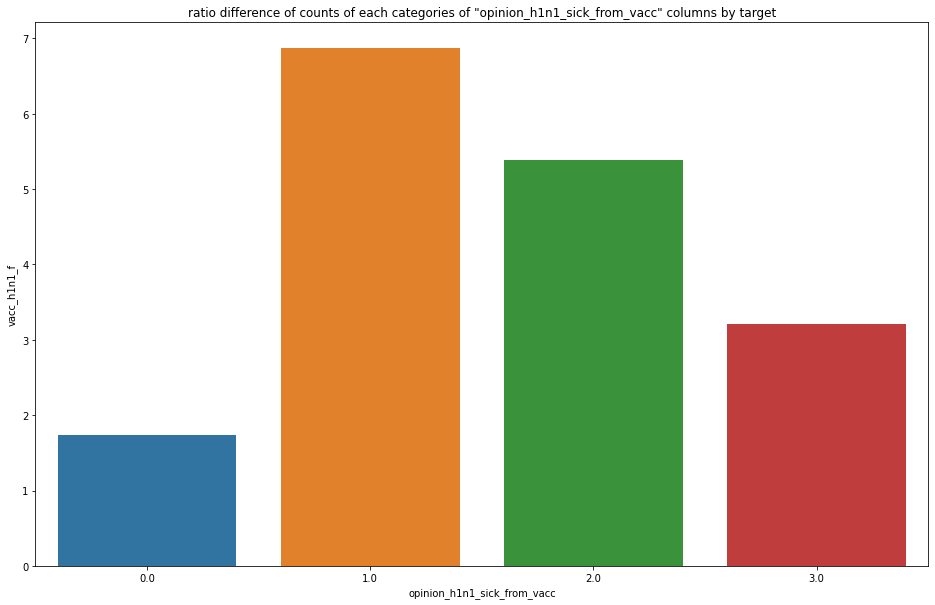

In [235]:
EDA_plot2(df,'opinion_h1n1_sick_from_vacc')

##### opinion_seas_vacc_effective

- Description : Respondent's opinion about seasonal flu vaccine effectiveness.   

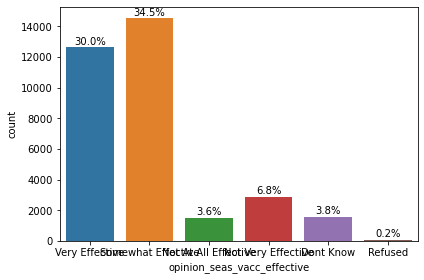

In [236]:
EDA_plot1(df,'opinion_seas_vacc_effective')

- Note : ordered categorical type, Don't Know/Refused -> nan

In [237]:
df['opinion_seas_vacc_effective'].replace('Dont Know',np.nan,inplace=True)
df['opinion_seas_vacc_effective'].replace('Refused',np.nan,inplace=True)
df['opinion_seas_vacc_effective'].replace('Not At All Effective',0,inplace=True)
df['opinion_seas_vacc_effective'].replace('Not Very Effective',1,inplace=True)
df['opinion_seas_vacc_effective'].replace('Somewhat Effective',2,inplace=True)
df['opinion_seas_vacc_effective'].replace('Very Effective',3,inplace=True)
type_feature['opinion_seas_vacc_effective'] = 'ordinal'

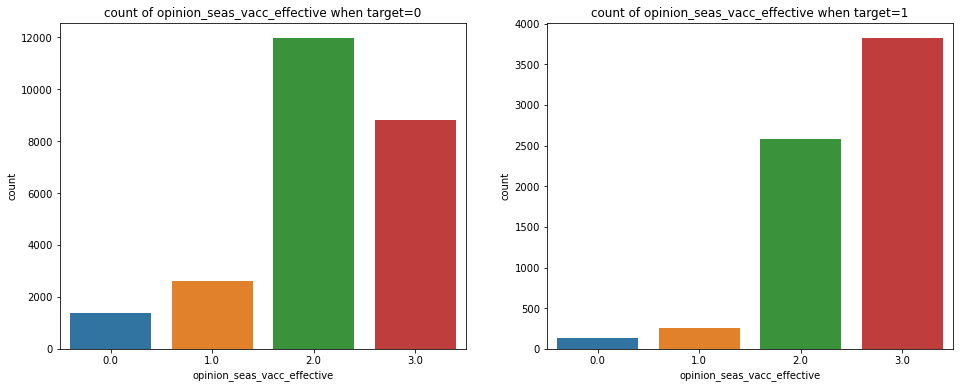

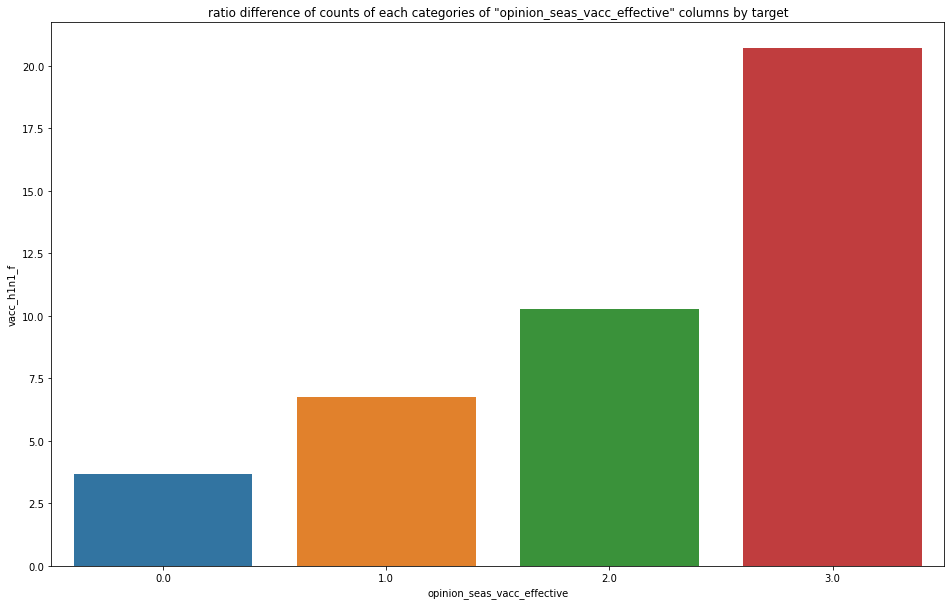

In [238]:
EDA_plot2(df,'opinion_seas_vacc_effective')

##### opinion_seas_risk

- Description : Respondent's opinion about risk of getting sick with seasonal flu without vaccine.   

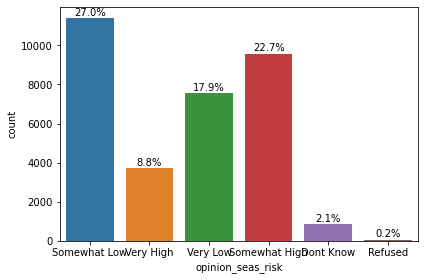

In [239]:
EDA_plot1(df,'opinion_seas_risk')

- Note : ordered categorical type, Don't Know/Refused -> nan, seasonal

In [240]:
df['opinion_seas_risk'].replace('Dont Know',np.nan,inplace=True)
df['opinion_seas_risk'].replace('Refused',np.nan,inplace=True)
df['opinion_seas_risk'].replace('Very Low',1,inplace=True)
df['opinion_seas_risk'].replace('Somewhat Low',2,inplace=True)
df['opinion_seas_risk'].replace('Somewhat High',3,inplace=True)
df['opinion_seas_risk'].replace('Very High',4,inplace=True)
type_feature['opinion_seas_risk'] = 'ordinal'

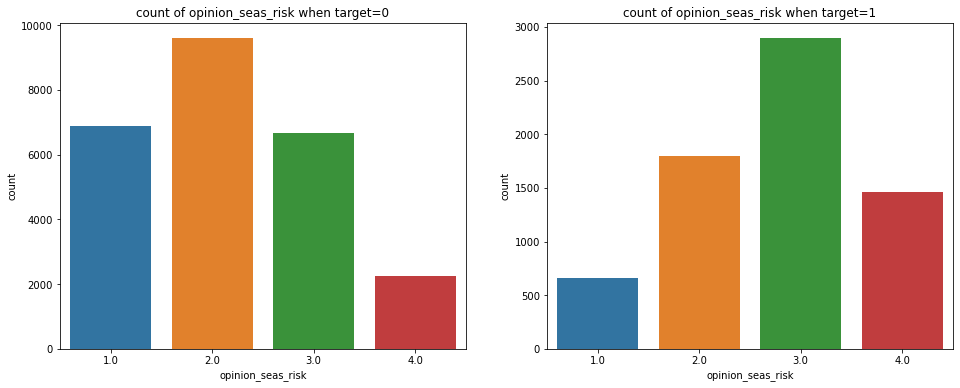

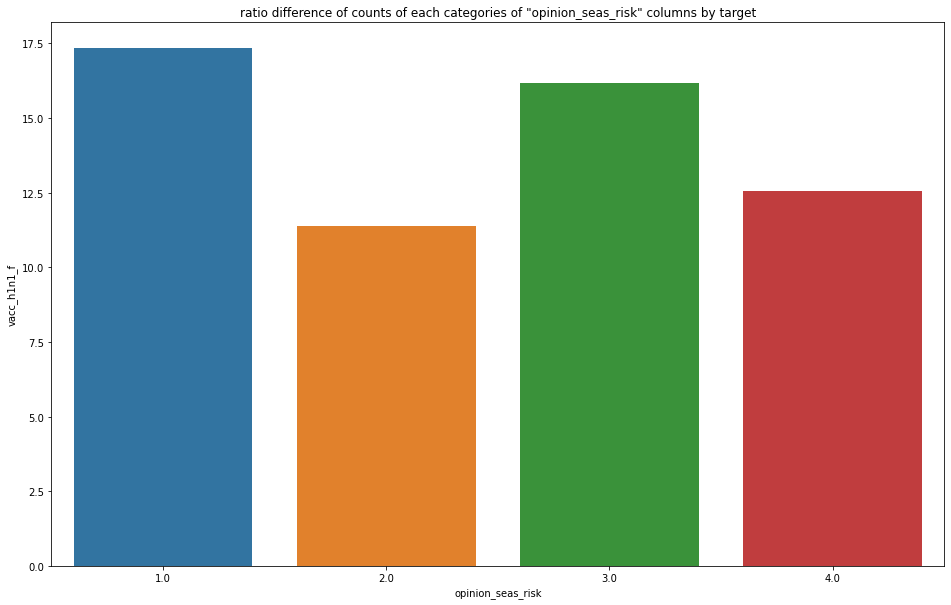

In [241]:
EDA_plot2(df,'opinion_seas_risk')

##### opinion_seas_sick_from_vacc

- Description : Respondent's worry of getting sick from taking seasonal flu vaccine.  

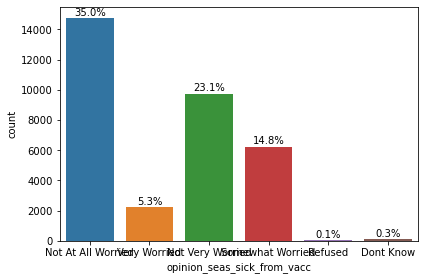

In [242]:
EDA_plot1(df,'opinion_seas_sick_from_vacc')

- Note : ordered categorical type, Don't Know/Refused -> nan, seasonal

In [243]:
df['opinion_seas_sick_from_vacc'].replace('Dont Know',np.nan,inplace=True)
df['opinion_seas_sick_from_vacc'].replace('Refused',np.nan,inplace=True)
df['opinion_seas_sick_from_vacc'].replace('Not At All Worried',0,inplace=True)
df['opinion_seas_sick_from_vacc'].replace('Not Very Worried',1,inplace=True)
df['opinion_seas_sick_from_vacc'].replace('Somewhat Worried',2,inplace=True)
df['opinion_seas_sick_from_vacc'].replace('Very Worried',3,inplace=True)
type_feature['opinion_seas_sick_from_vacc'] = 'ordinal'

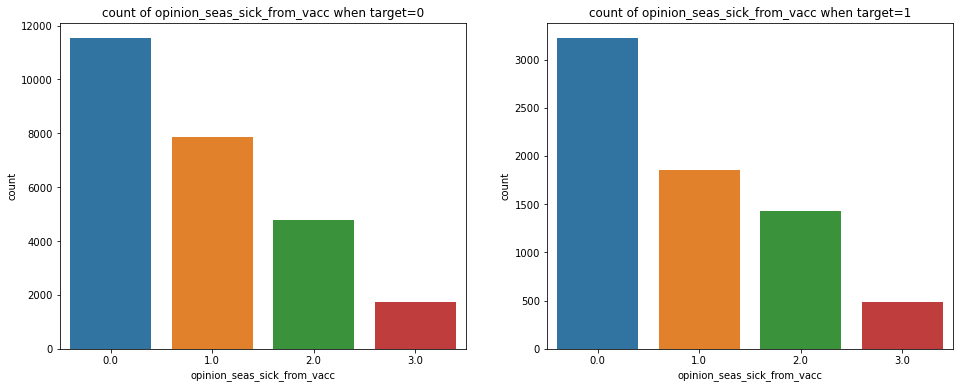

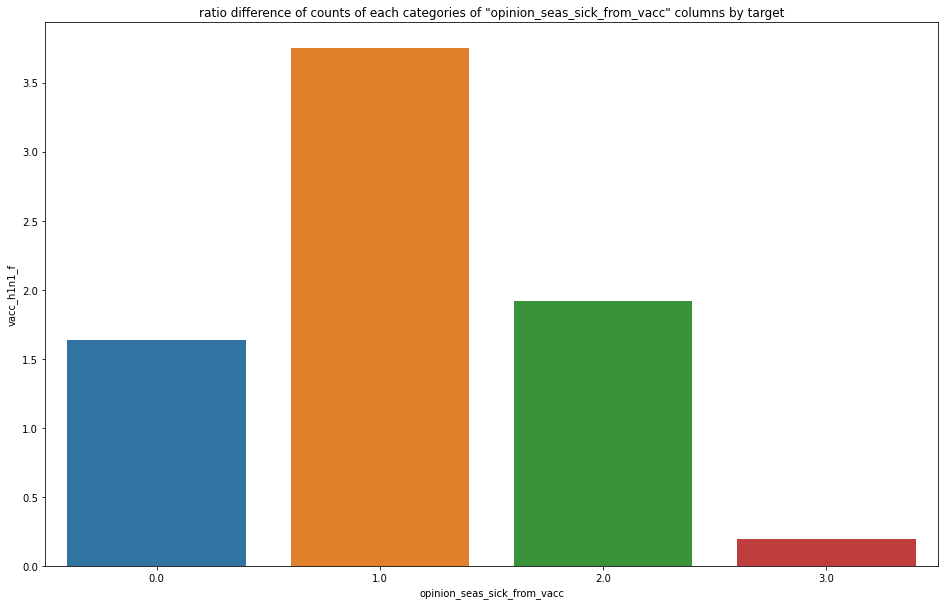

In [244]:
EDA_plot2(df,'opinion_seas_sick_from_vacc')

##### agegrp

- Description : Age group of respondent.   

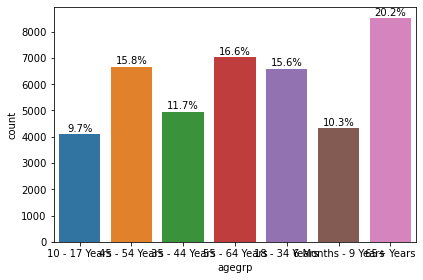

In [245]:
EDA_plot1(df,'agegrp')

- Note : ordered categorical type

In [246]:
df['agegrp'].replace('6 Months - 9 Years',1,inplace=True)
df['agegrp'].replace('10 - 17 Years',2,inplace=True)
df['agegrp'].replace('18 - 34 Years',3,inplace=True)
df['agegrp'].replace('35 - 44 Years',4,inplace=True)
df['agegrp'].replace('45 - 54 Years',5,inplace=True)
df['agegrp'].replace('55 - 64 Years',6,inplace=True)
df['agegrp'].replace('65+ Years',7,inplace=True)
type_feature['agegrp'] = 'ordinal'

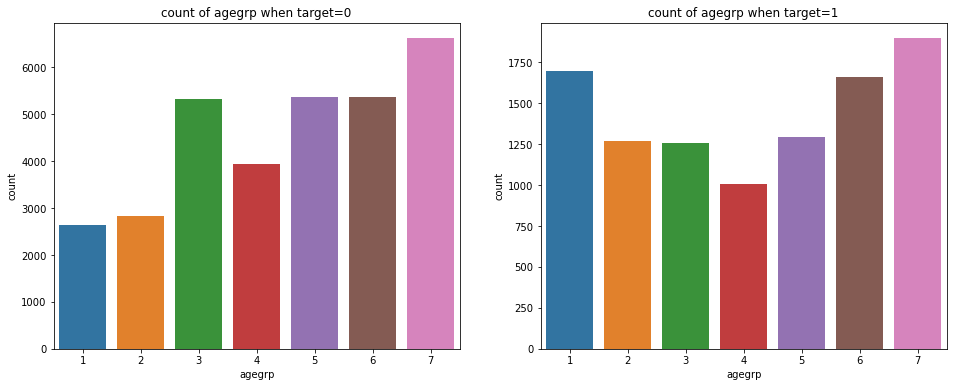

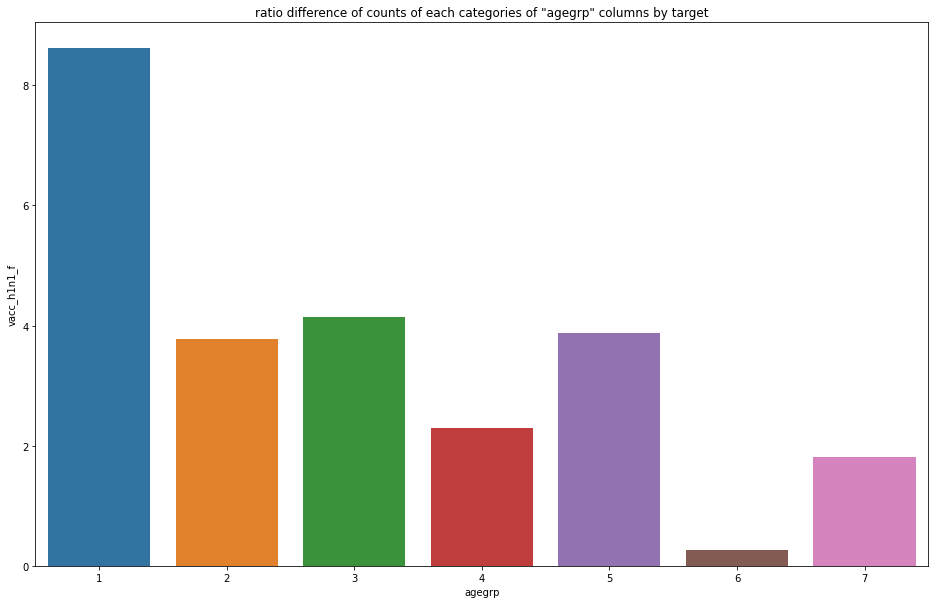

In [247]:
EDA_plot2(df,'agegrp')

##### education_comp

- Description : Self-reported education level.   
1 = < 12 Years; 2 = 12 Years; 3 = Some College; 4 = College Graduate   

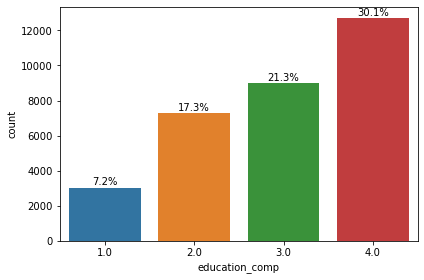

In [248]:
EDA_plot1(df,'education_comp')

- Note : ordered categorical type

In [249]:
type_feature['education_comp'] = 'ordinal'

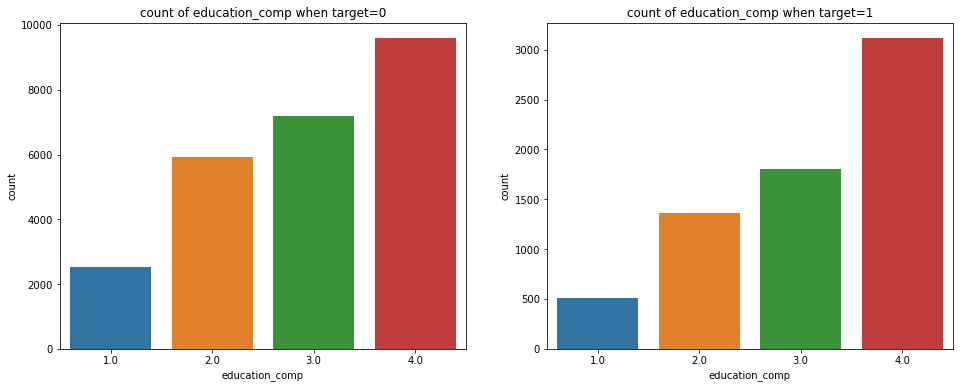

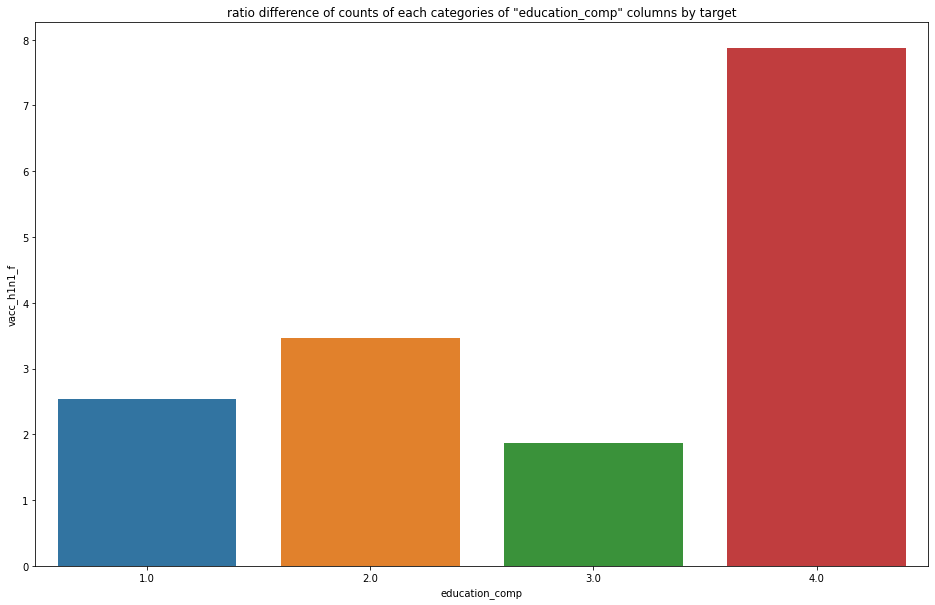

In [250]:
EDA_plot2(df,'education_comp')

##### raceeth4_i

- Description : Race of respondent.   
1 = Hispanic; 2 = Non-Hispanic, Black Only; 3 = Non-Hispanic, White Only; 4 = Non-Hispanic, Other or Multiple Races   

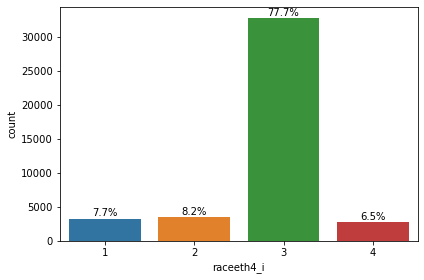

In [251]:
EDA_plot1(df,'raceeth4_i')

- Note : categorical type

In [252]:
df['raceeth4_i'].replace(1,'Hispanic',inplace=True)
df['raceeth4_i'].replace(2,'Non-Hispanic, Black Only',inplace=True)
df['raceeth4_i'].replace(3,'Non-Hispanic, White Only',inplace=True)
df['raceeth4_i'].replace(4,'Non-Hispanic, Other or Multiple Races ',inplace=True)
type_feature['raceeth4_i'] = 'nominal'

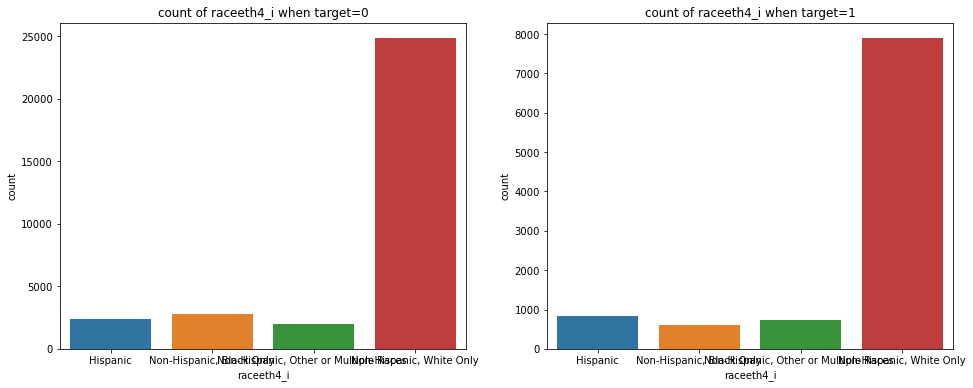

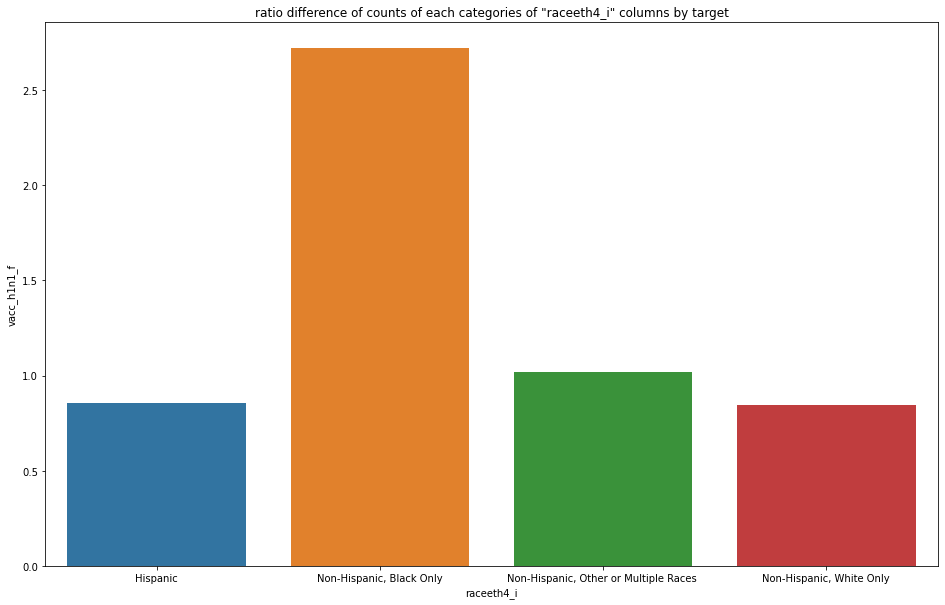

In [253]:
EDA_plot2(df,'raceeth4_i')

##### sex_i

- Description : Sex of respondent.   
1 = Male; 2 = Female   

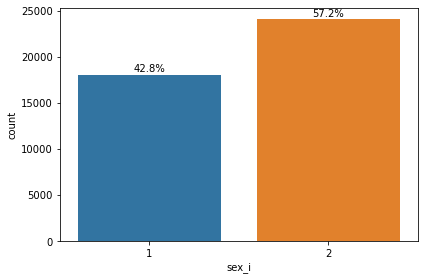

In [254]:
EDA_plot1(df,'sex_i')

- Note : boolean, Male=True, Female=False

In [255]:
df['sex_i'].replace(2,0,inplace=True)
type_feature['sex_i'] = 'bool'

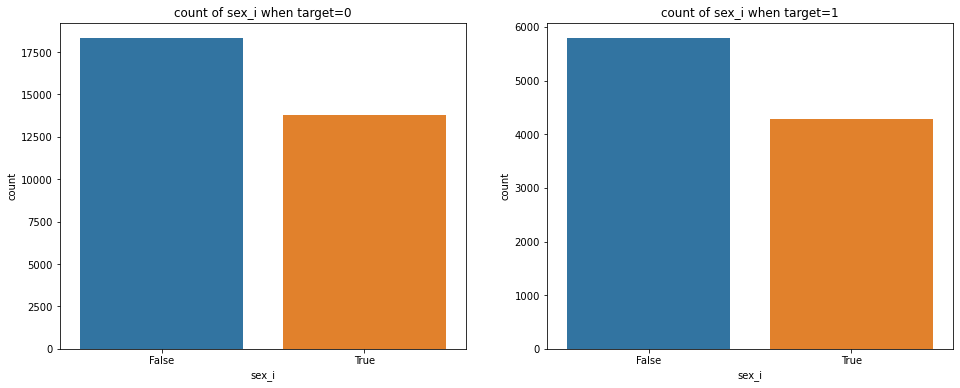

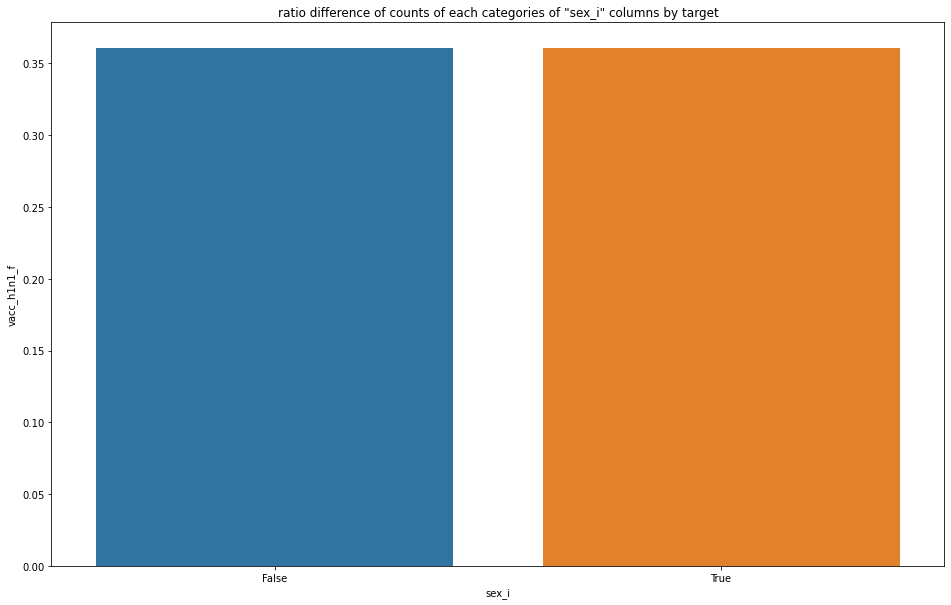

In [256]:
EDA_plot2(df,'sex_i')

##### inc_pov

- Description : Household annual income of respondent with respect to 2008 Census poverty thresholds.   
1 = > $75,000; 2 = <= $75,000; 3 = Below Poverty; 4 = Unknown   

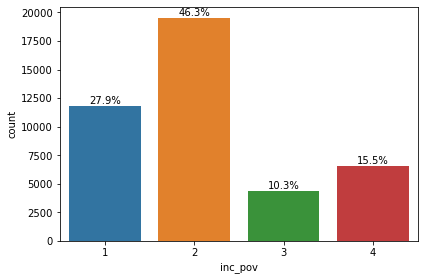

In [257]:
EDA_plot1(df,'inc_pov')

- Note : ordered categorical type, 4(Unknown) -> np.nan, 3(Below Poverty) -> 1, 1(>=$7500) -> 3

In [258]:
df['inc_pov'].replace(4,np.nan,inplace=True)
df['inc_pov'].replace(3,5,inplace=True)
df['inc_pov'].replace(1,3,inplace=True)
df['inc_pov'].replace(5,1,inplace=True)
type_feature['inc_pov'] = 'ordinal'

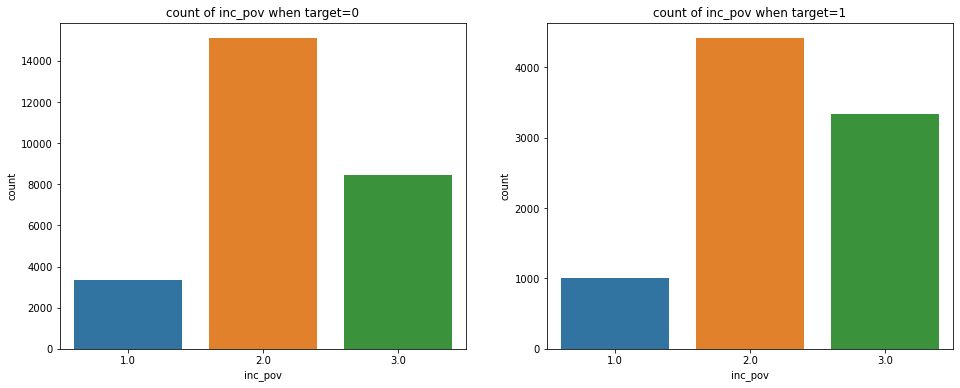

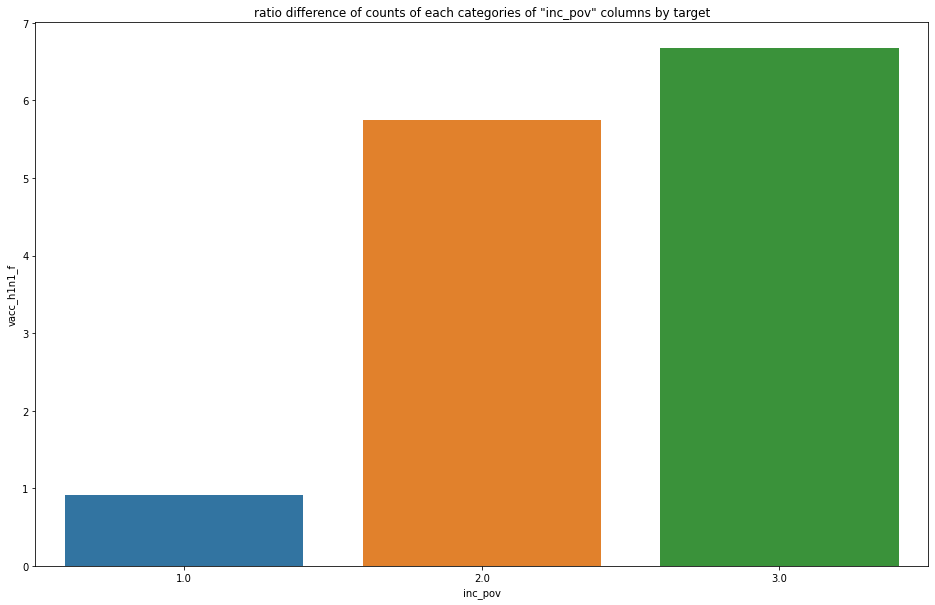

In [259]:
EDA_plot2(df,'inc_pov')

##### marital

- Description : Marital status of respondent.   
1 = Married; 2 = Not Married   

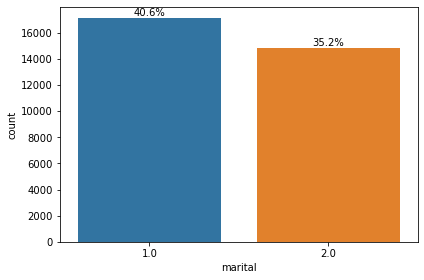

In [260]:
EDA_plot1(df,'marital')

- Note : boolean

In [261]:
type_feature['marital'] = 'bool'

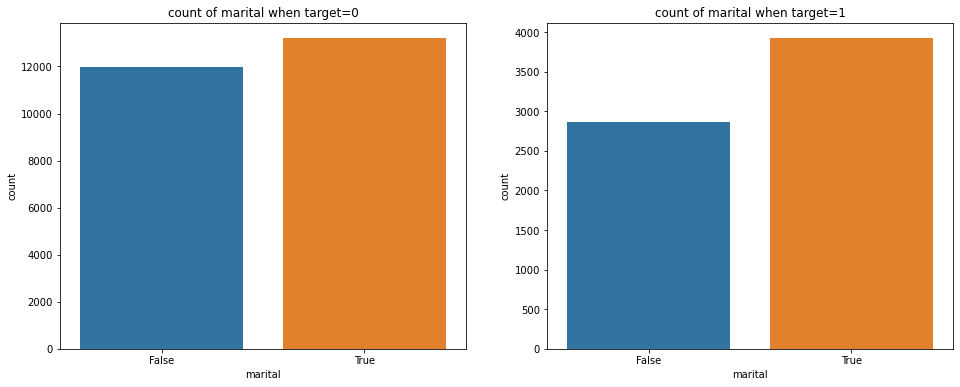

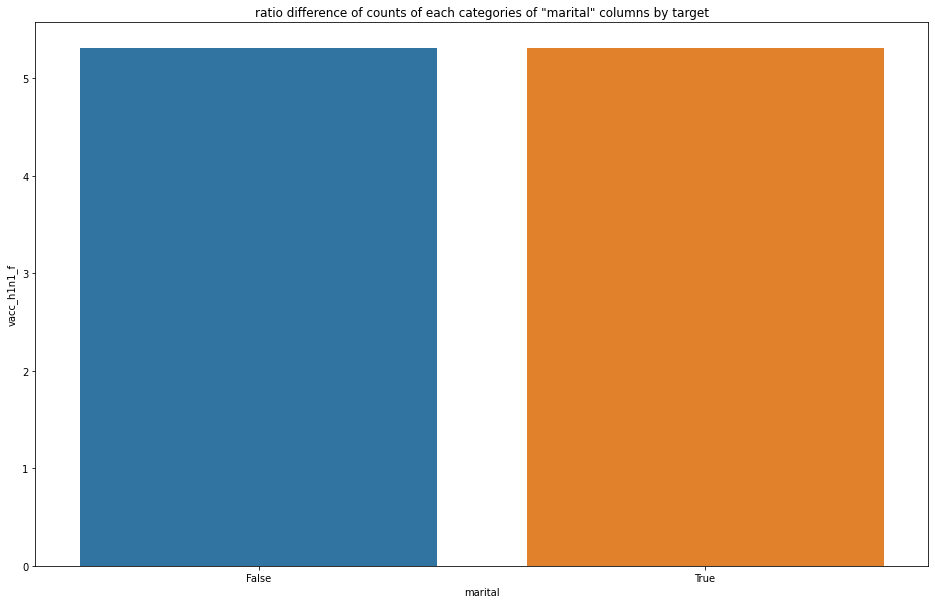

In [262]:
EDA_plot2(df,'marital')

##### rent_own_r

- Description : Housing situation of respondent.   
1 = Home is Owned; 2 = Home is Rented or Other Arrangement   

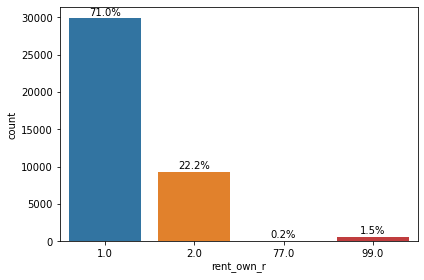

In [263]:
EDA_plot1(df,'rent_own_r')

- Note : boolean, Outliers(77,99 -> np.nan)

In [264]:
df['rent_own_r'].replace(77,np.nan,inplace=True)
df['rent_own_r'].replace(99,np.nan,inplace=True)
df['rent_own_r'].replace(2,0,inplace=True)
type_feature['rent_own_r'] = 'bool'

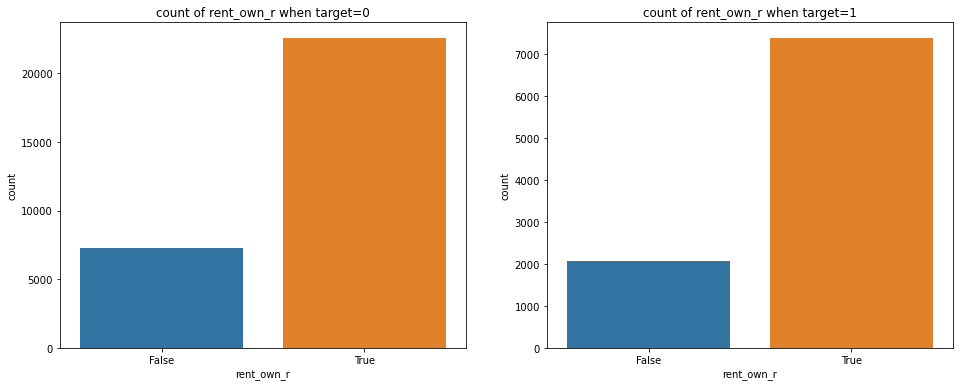

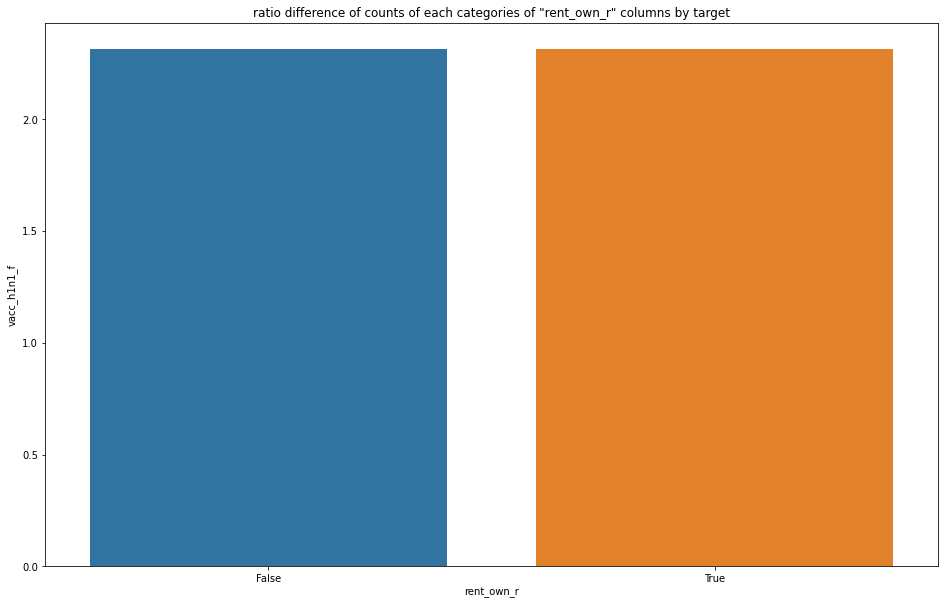

In [265]:
EDA_plot2(df,'rent_own_r')

##### employment_status

- Description : Employment status of respondent.   

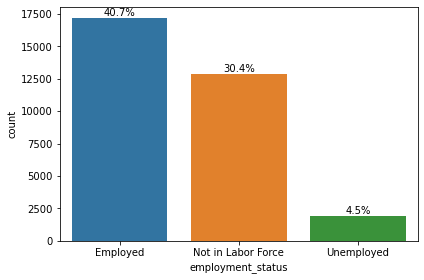

In [266]:
EDA_plot1(df,'employment_status')

- Note : ordered categorical type

In [267]:
df['employment_status'].replace('Unemployed',0,inplace=True)
df['employment_status'].replace('Not in Labor Force',1,inplace=True)
df['employment_status'].replace('Employed',2,inplace=True)
type_feature['employment_status'] = 'ordinal'

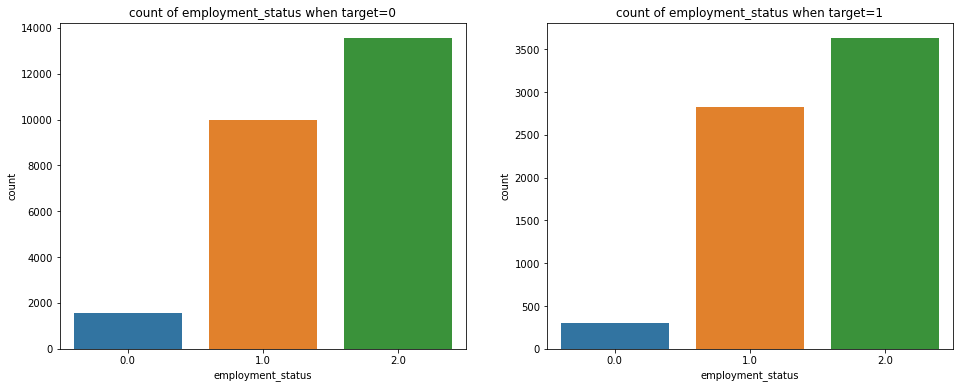

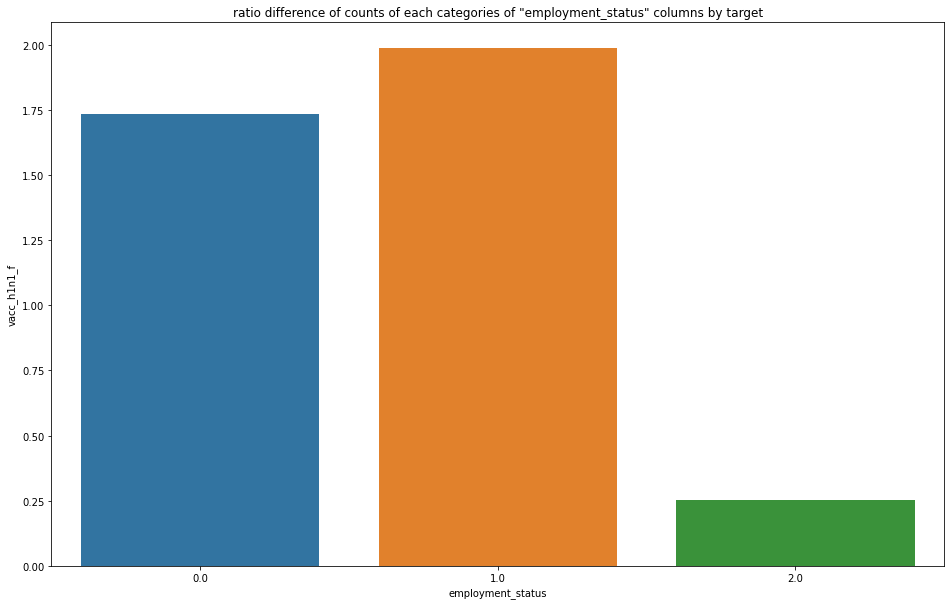

In [268]:
EDA_plot2(df,'employment_status')

##### census_region

- Description : True census region of residence   
1=northeast; 2=midwest; 3=south; 4=west   

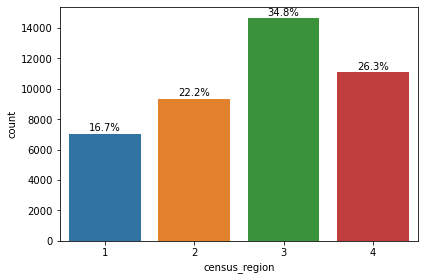

In [269]:
EDA_plot1(df,'census_region')

- Note : categorical type, location information

In [270]:
df['census_region'].replace(1,'northeast',inplace=True)
df['census_region'].replace(2,'midwest',inplace=True)
df['census_region'].replace(3,'south',inplace=True)
df['census_region'].replace(4,'west',inplace=True)
type_feature['census_region'] = 'nominal'

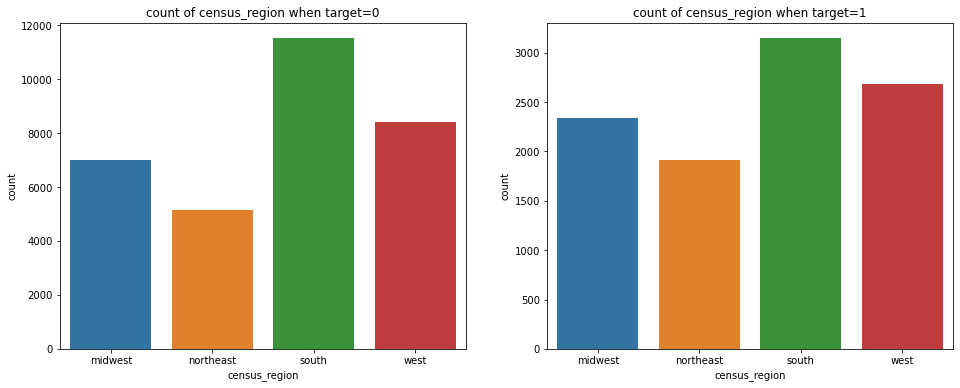

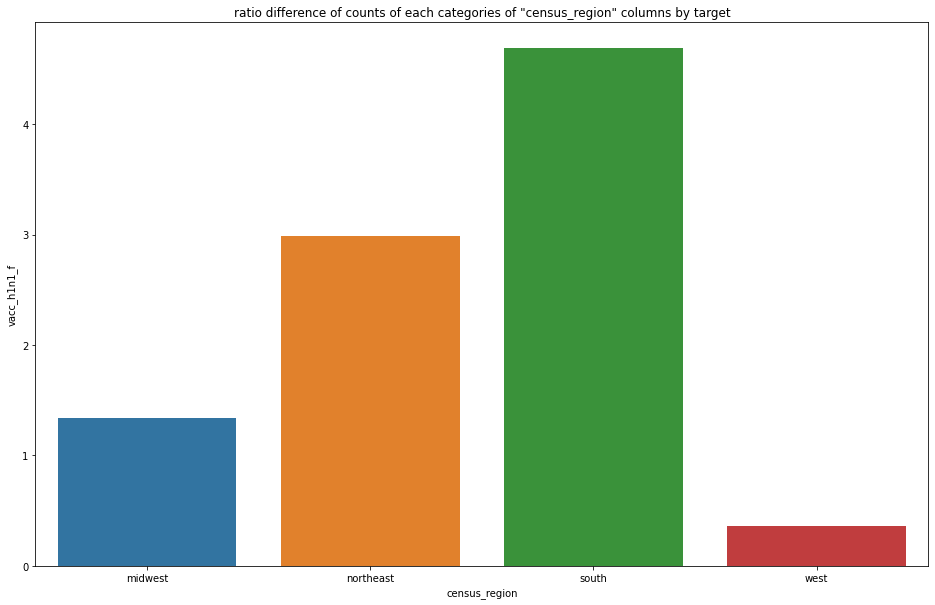

In [271]:
EDA_plot2(df,'census_region')

##### census_msa

- Description : Respondent's residence within metropolitan statistical areas (MSA) as defined by the U.S. Census.   

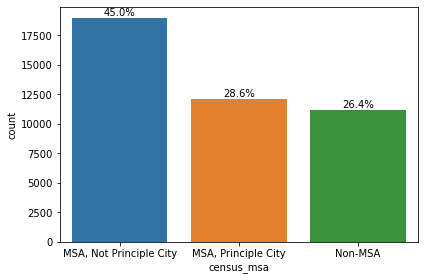

In [272]:
EDA_plot1(df,'census_msa')

- Note : ordered categorical type, location information

In [273]:
df['census_msa'].replace('Non-MSA',0,inplace=True)
df['census_msa'].replace('MSA, Not Principle City',1,inplace=True)
df['census_msa'].replace('MSA, Principle City',2,inplace=True)
type_feature['census_msa'] = 'ordinal'

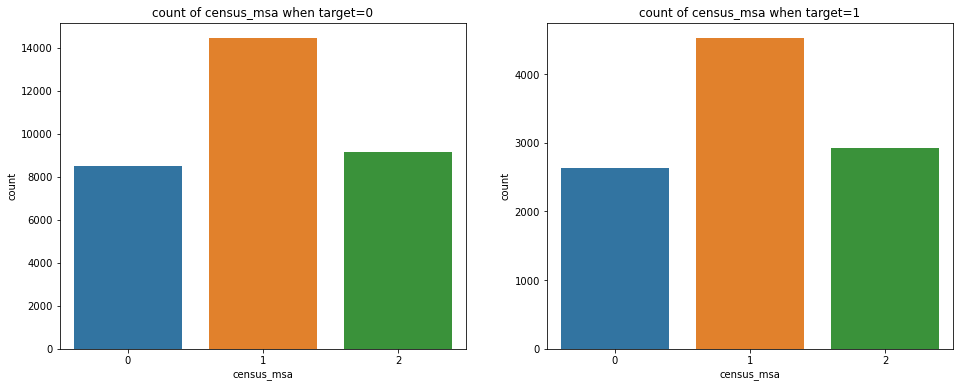

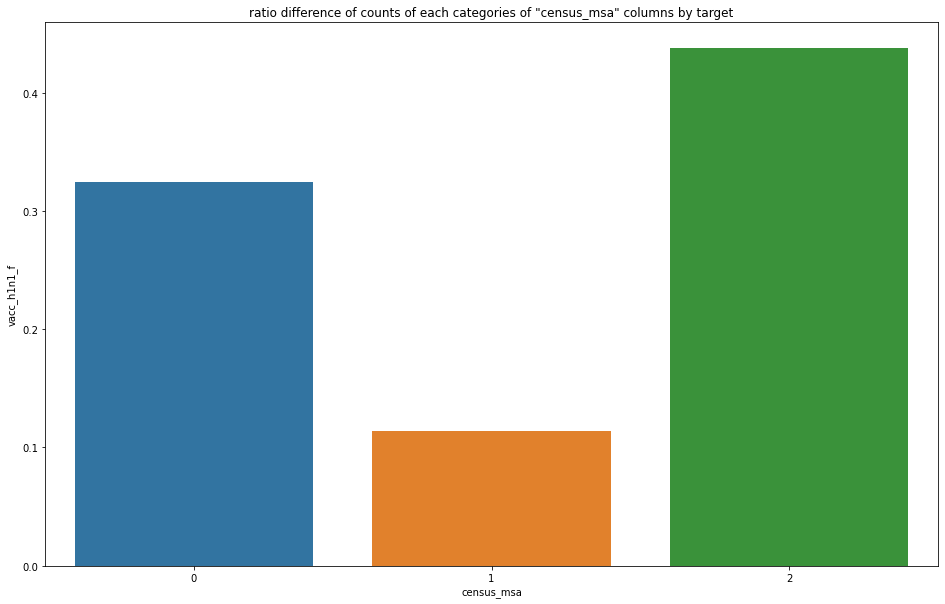

In [274]:
EDA_plot2(df,'census_msa')

##### n_adult_r

- Description : Number of other adults in household.   

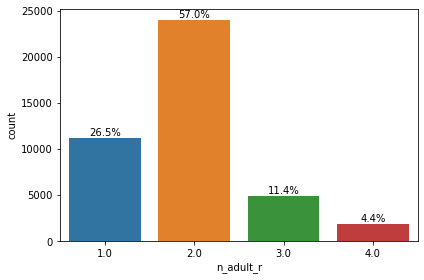

In [275]:
EDA_plot1(df,'n_adult_r')

- Note : ordered categorical type, corr with n_people_r

In [276]:
type_feature['n_adult_r'] = 'interval'

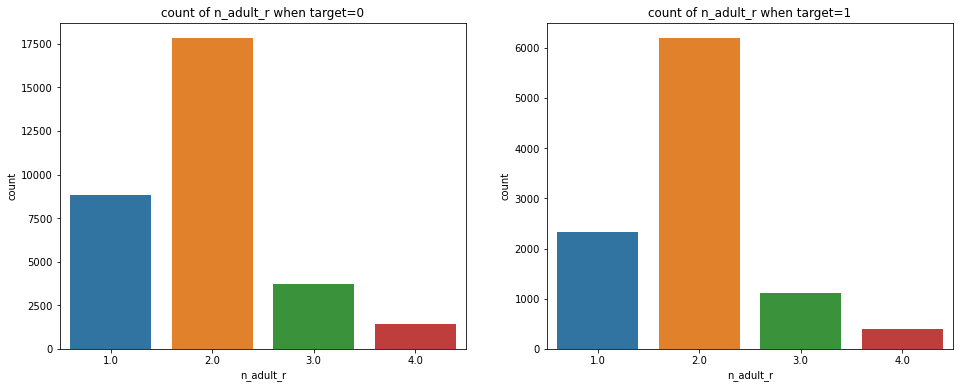

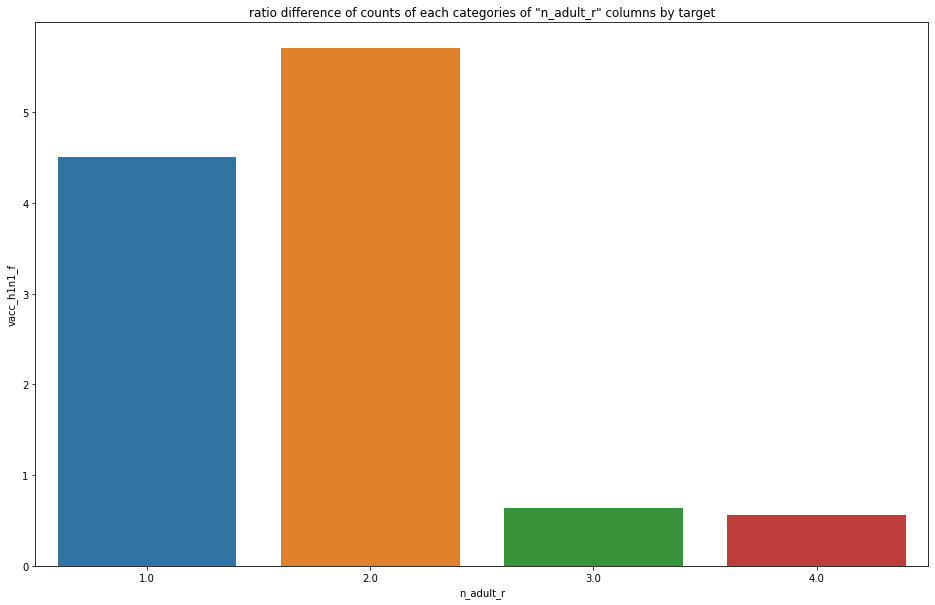

In [277]:
EDA_plot2(df,'n_adult_r')

##### household_children

- Description : Number of children in household.   

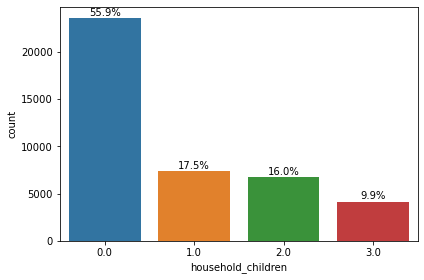

In [278]:
EDA_plot1(df,'household_children')

- Note : ordered categorical type, corr with n_people_r

In [279]:
type_feature['household_children'] = 'interval'

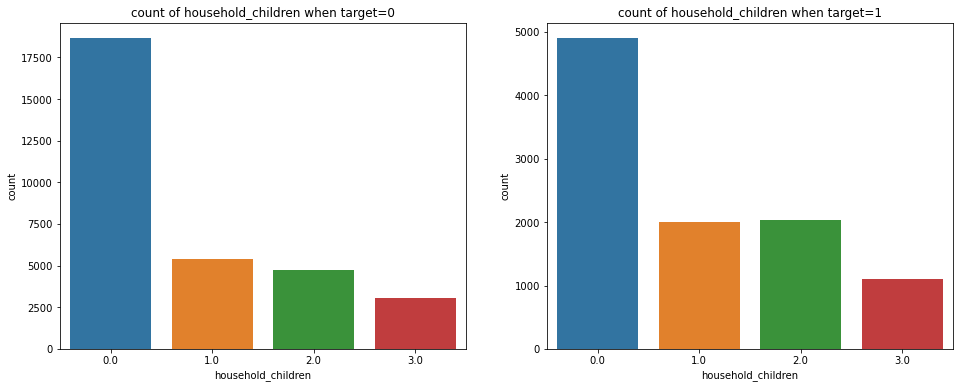

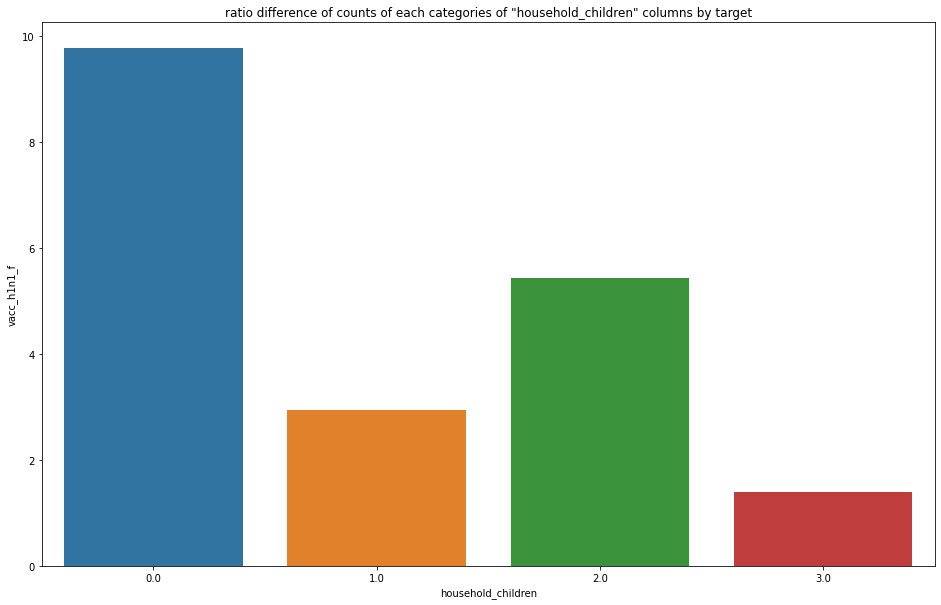

In [280]:
EDA_plot2(df,'household_children')

##### n_people_r

- Description : Number of adults in the household.   

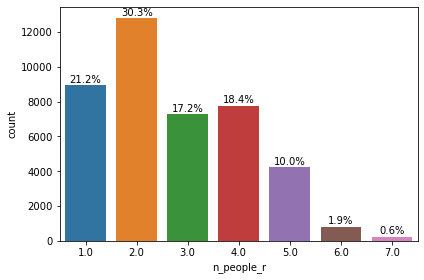

In [281]:
EDA_plot1(df,'n_people_r')

- Note : ordered categorical type, corr with n_adult_r and household_children

In [282]:
type_feature['n_people_r'] = 'interval'

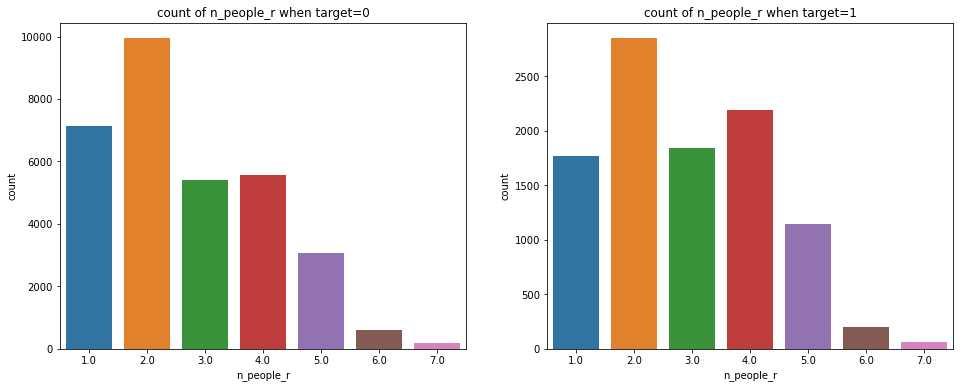

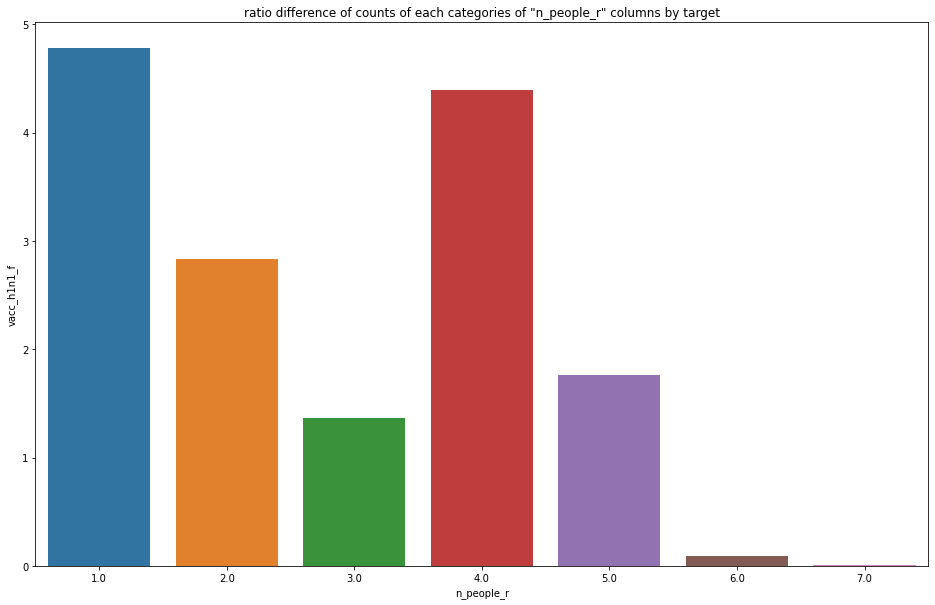

In [283]:
EDA_plot2(df,'n_people_r')

##### employment_industry

- Description : Type of industry respondent is employed in.   

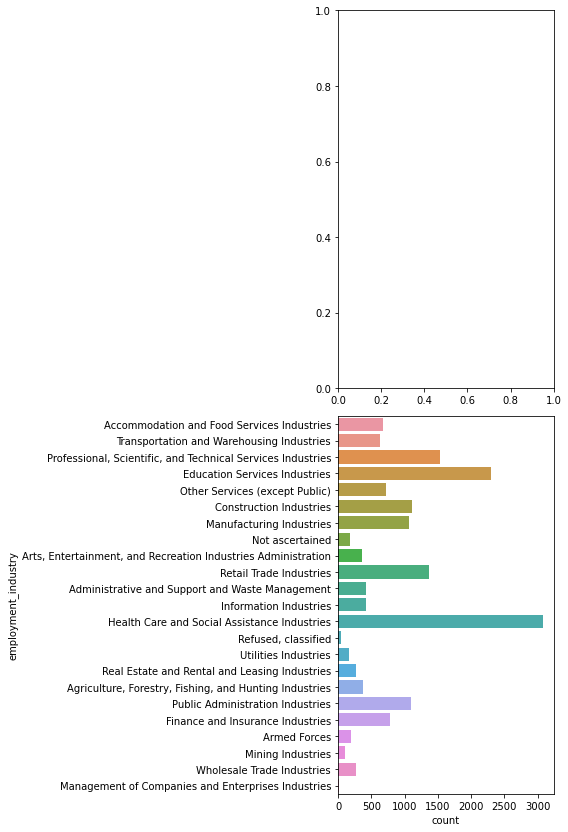

In [284]:
EDA_plot1(df,'employment_industry')

- Note : categorical type, Refused/classified -> np.nan, high cardinality, corr with employment_status and employment_occupation

In [285]:
df['employment_industry'].replace('Refused, classified',np.nan,inplace=True)
df['employment_industry'].replace('Not ascertained',np.nan,inplace=True)
type_feature['employment_industry'] = 'nominal'

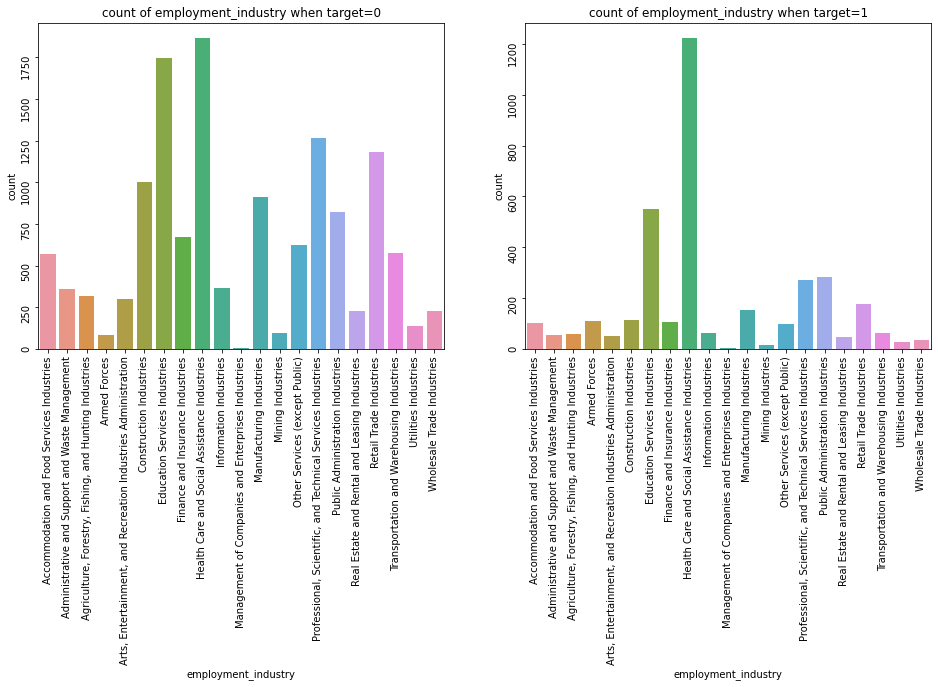

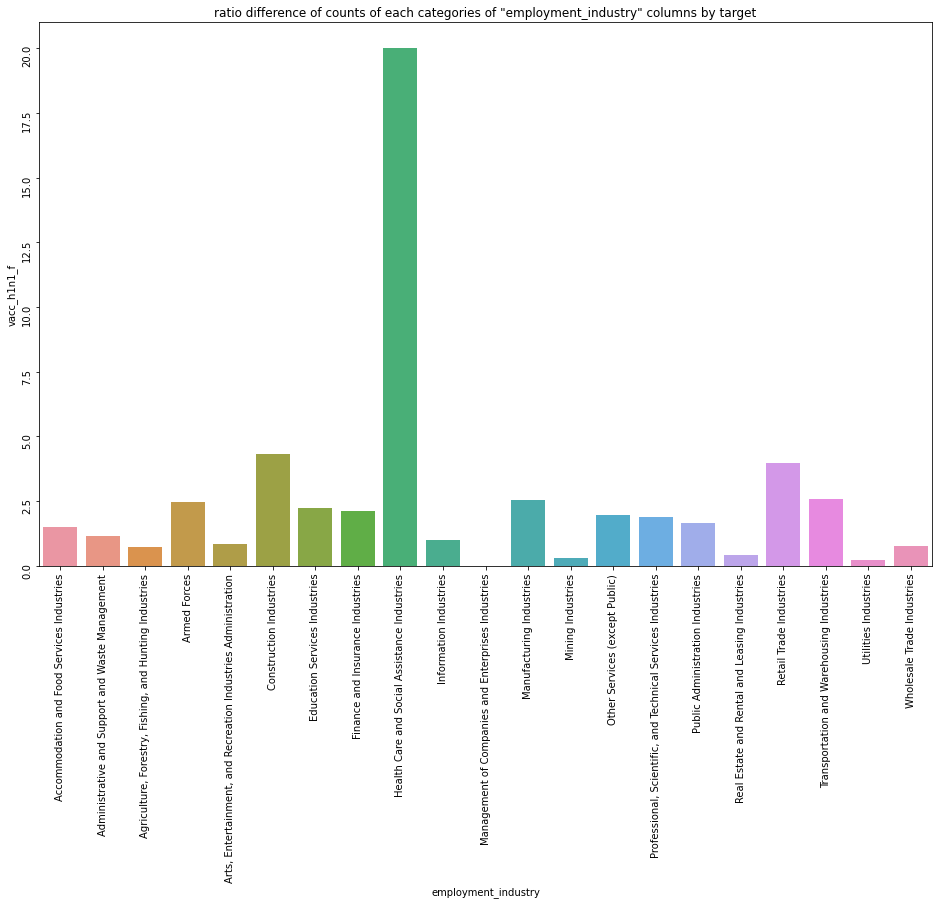

In [286]:
EDA_plot2(df,'employment_industry',rot=90)

##### employment_occupation

- Description : Type of occupation of respondent. Values are represented as short random character strings.   

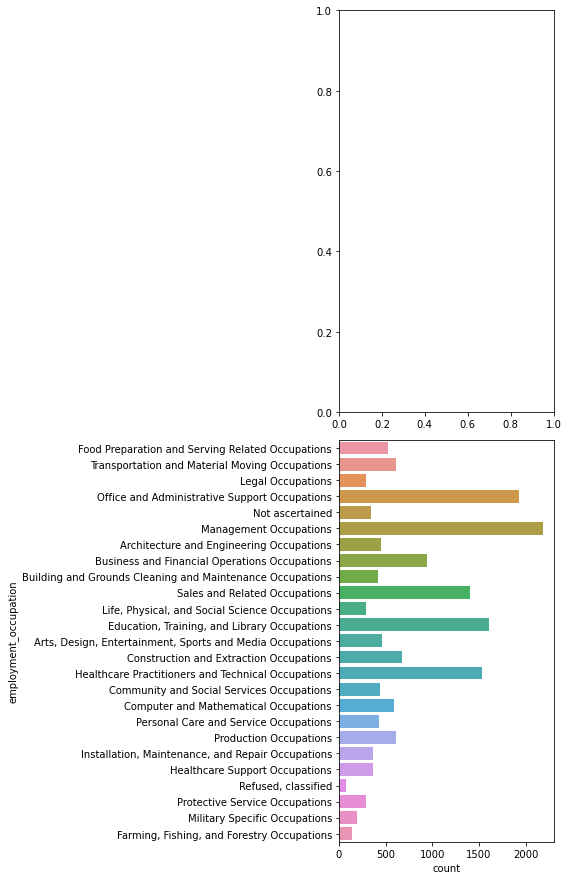

In [287]:
EDA_plot1(df,'employment_occupation')

- Note : categorical type, Refused/classified -> np.nan, high cardinality, corr with employment_status and employment_industry

In [288]:
df['employment_occupation'].replace('Refused, classified',np.nan,inplace=True)
df['employment_occupation'].replace('Not ascertained',np.nan,inplace=True)
type_feature['employment_occupation'] = 'nominal'

[nan 'Food Preparation and Serving Related Occupations'
 'Transportation and Material Moving Occupations' 'Legal Occupations'
 'Office and Administrative Support Occupations' 'Not ascertained'
 'Management Occupations' 'Architecture and Engineering Occupations'
 'Business and Financial Operations Occupations'
 'Building and Grounds Cleaning and Maintenance Occupations'
 'Sales and Related Occupations'
 'Life, Physical, and Social Science Occupations'
 'Education, Training, and Library Occupations'
 'Arts, Design, Entertainment, Sports and Media Occupations'
 'Construction and Extraction Occupations'
 'Healthcare Practitioners and Technical Occupations'
 'Community and Social Services Occupations'
 'Computer and Mathematical Occupations'
 'Personal Care and Service Occupations' 'Production Occupations'
 'Installation, Maintenance, and Repair Occupations'
 'Healthcare Support Occupations' 'Refused, classified'
 'Protective Service Occupations' 'Military Specific Occupations'
 'Farming, F

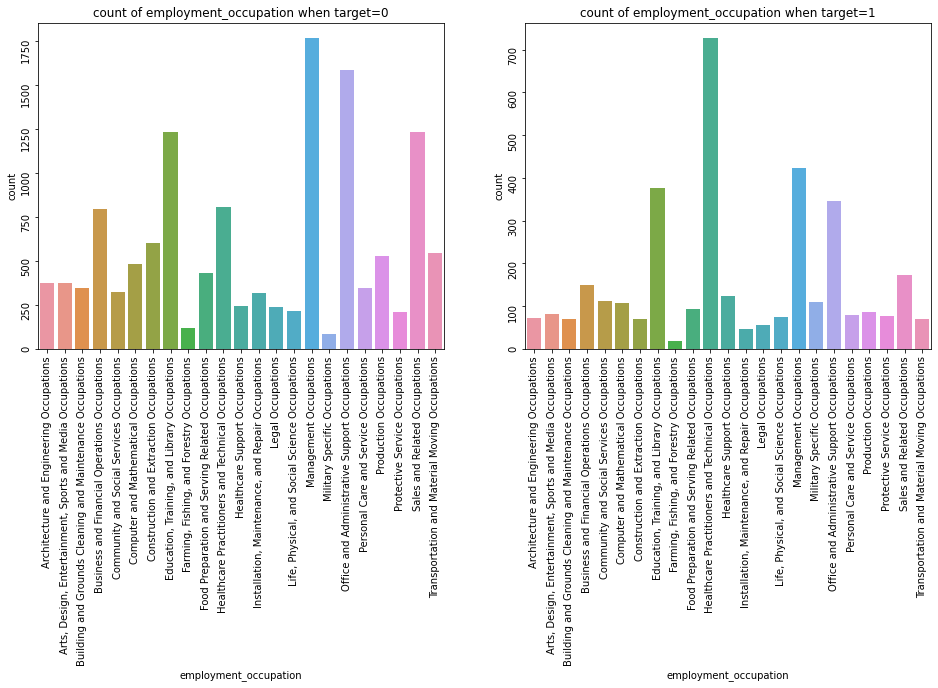

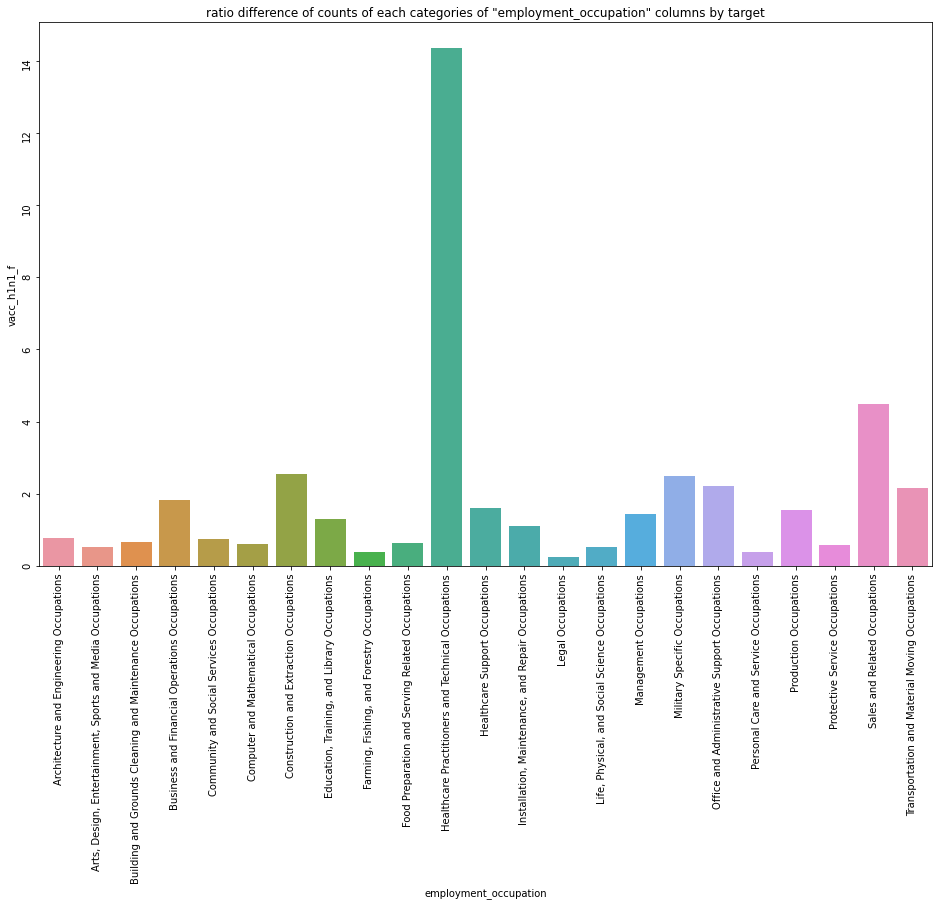

In [289]:
EDA_plot2(df,'employment_occupation',rot=90)

##### hhs_region

- Description : HHS surveillance region number   
    - Region 1: CT,ME,MA,NH,RI,VT   
    - Region 2: NJ,NY   
    - Region 3: DE,DC,MD,PA,VA,WV   
    - Region 4: AL,FL,GA,KY,MS,NC,SC,TN   
    - Region 5: IL,IN,MI,MN,OH,WI   
    - Region 6: AR,LA,NM,OK,TX   
    - Region 7: IA,KS,MO,NE   
    - Region 8: CO,MT,ND,SD,UT,WY   
    - Region 9: AZ,CA,HI,NV   
    - Region 10: AK,ID,OR,WA   

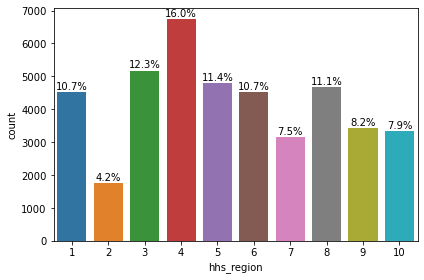

In [290]:
EDA_plot1(df,'hhs_region')

- Note : categorical type, location information, high cardinality

In [291]:
df['hhs_region']=df['hhs_region'].map(lambda x: 'Region'+str(x))
type_feature['hhs_region'] = 'nominal'

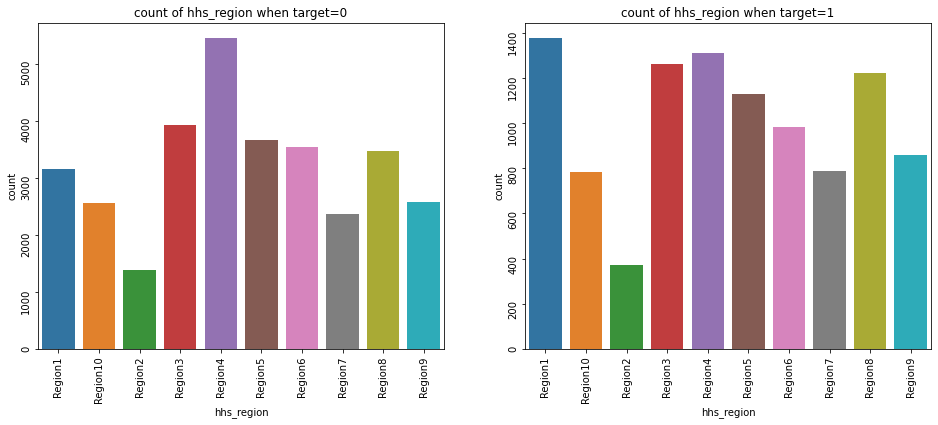

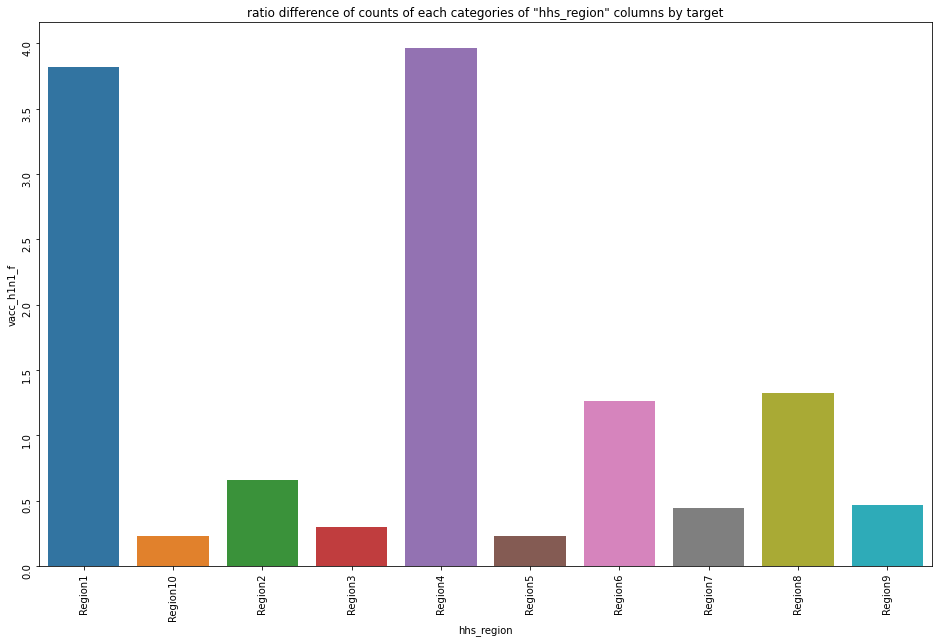

In [292]:
EDA_plot2(df,'hhs_region',rot=90)

##### state

- Description : State of residence   

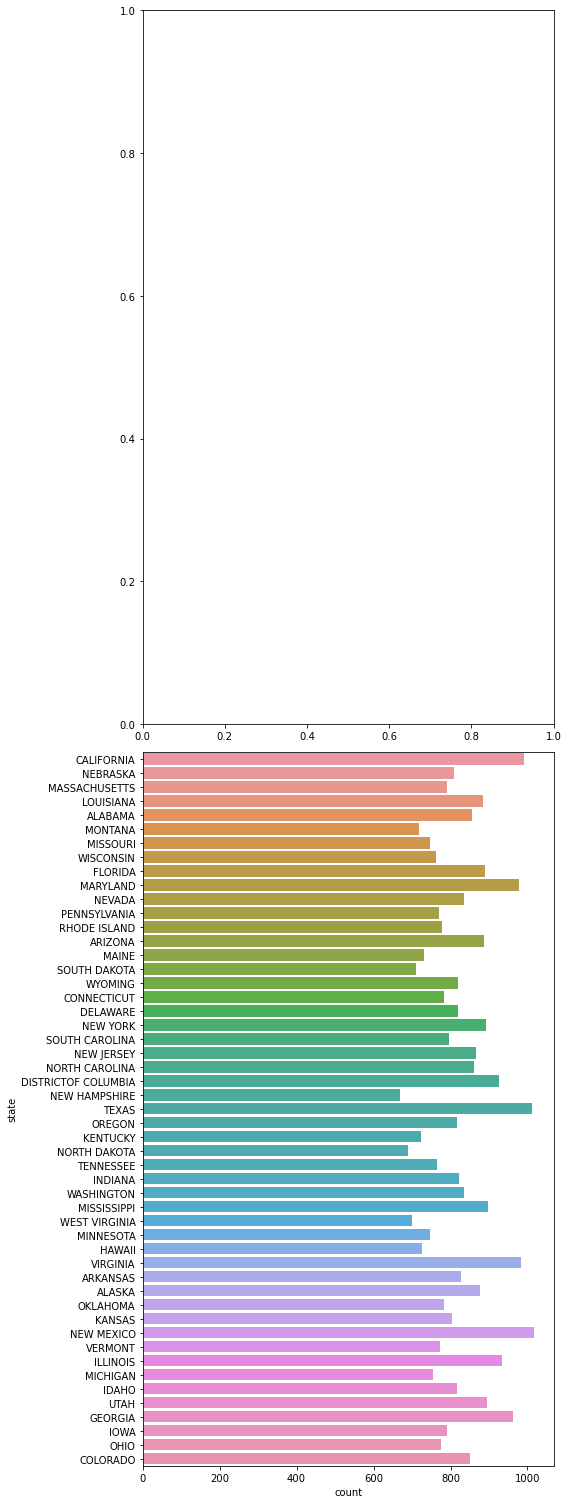

In [293]:
EDA_plot1(df,'state')

- Note : categorical type, local information, high cardinality

In [294]:
df['state'].replace('ALABAMA','AL',inplace=True)
df['state'].replace('ALASKA','AK',inplace=True)
df['state'].replace('ARIZONA','AZ',inplace=True)
df['state'].replace('ARKANSAS','AR',inplace=True)
df['state'].replace('CALIFORNIA','CA',inplace=True)
df['state'].replace('COLORADO','CO',inplace=True)
df['state'].replace('CONNECTICUT','CT',inplace=True)
df['state'].replace('DELAWARE','DE',inplace=True)
df['state'].replace('DISTRICTOF COLUMBIA','DC',inplace=True)
df['state'].replace('FLORIDA','FL',inplace=True)
df['state'].replace('GEORGIA','GA',inplace=True)
df['state'].replace('HAWAII','HI',inplace=True)
df['state'].replace('IDAHO','ID',inplace=True)
df['state'].replace('ILLINOIS','IL',inplace=True)
df['state'].replace('INDIANA','IN',inplace=True)
df['state'].replace('IOWA','IA',inplace=True)
df['state'].replace('KANSAS','KS',inplace=True)
df['state'].replace('KENTUCKY','KY',inplace=True)
df['state'].replace('LOUISIANA','LA',inplace=True)
df['state'].replace('MAINE','ME',inplace=True)
df['state'].replace('MARYLAND','MD',inplace=True)
df['state'].replace('MASSACHUSETTS','MA',inplace=True)
df['state'].replace('MICHIGAN','MI',inplace=True)
df['state'].replace('MINNESOTA','MN',inplace=True)
df['state'].replace('MISSISSIPPI','MS',inplace=True)
df['state'].replace('MISSOURI','MO',inplace=True)
df['state'].replace('MONTANA','MT',inplace=True)
df['state'].replace('NEBRASKA','NE',inplace=True)
df['state'].replace('NEVADA','NV',inplace=True)
df['state'].replace('NEW HAMPSHIRE','NH',inplace=True)
df['state'].replace('NEW JERSEY','NJ',inplace=True)
df['state'].replace('NEW MEXICO','NM',inplace=True)
df['state'].replace('NEW YORK','NY',inplace=True)
df['state'].replace('NORTH CAROLINA','NC',inplace=True)
df['state'].replace('NORTH DAKOTA','ND',inplace=True)
df['state'].replace('OHIO','OH',inplace=True)
df['state'].replace('OKLAHOMA','OK',inplace=True)
df['state'].replace('OREGON','OR',inplace=True)
df['state'].replace('PENNSYLVANIA','PA',inplace=True)
df['state'].replace('RHODE ISLAND','RI',inplace=True)
df['state'].replace('SOUTH CAROLINA','SC',inplace=True)
df['state'].replace('SOUTH DAKOTA','SD',inplace=True)
df['state'].replace('TENNESSEE','TN',inplace=True)
df['state'].replace('TEXAS','TX',inplace=True)
df['state'].replace('UTAH','UT',inplace=True)
df['state'].replace('VERMONT','VT',inplace=True)
df['state'].replace('VIRGINIA','VA',inplace=True)
df['state'].replace('WASHINGTON','WA',inplace=True)
df['state'].replace('WEST VIRGINIA','WV',inplace=True)
df['state'].replace('WISCONSIN','WI',inplace=True)
df['state'].replace('WYOMING','WY',inplace=True)
type_feature['state'] = 'nominal'

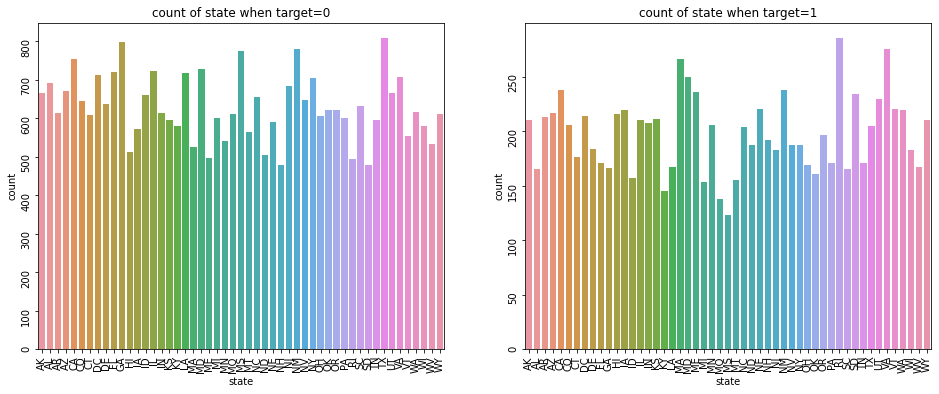

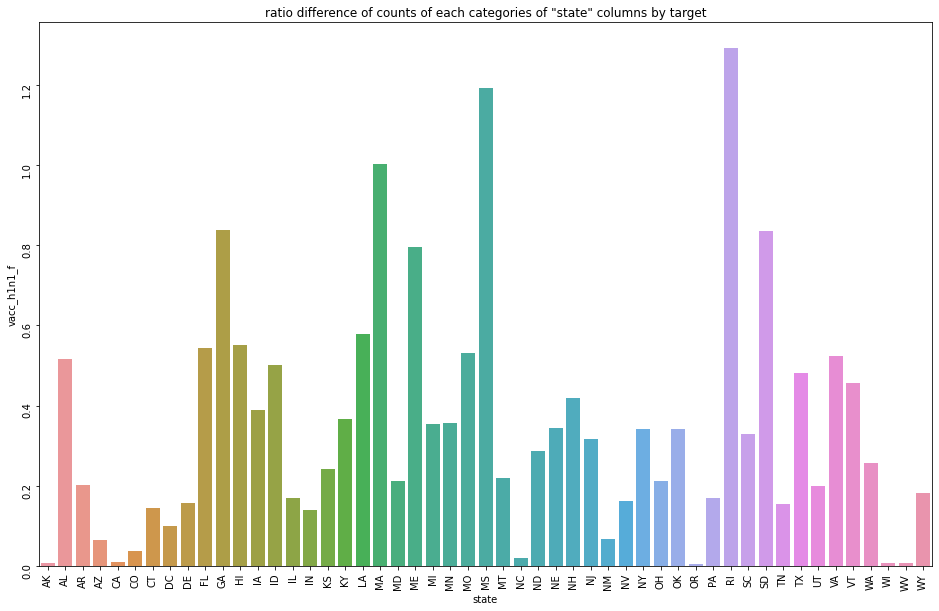

In [295]:
EDA_plot2(df,'state',rot=90)

##### map visualization
feature : state, hhs_region, census_region

In [296]:
import json
import requests
from matplotlib.patches import Polygon
url = (
    "https://raw.githubusercontent.com/python-visualization/folium/master/examples/data"
)
state_geo = f"{url}/us-states.json"
dc={"type":"Feature","id":"DC","properties":{"name":"District of Columbia"},"geometry":{"type":"Polygon","coordinates":[[[-77.040741, 38.791222],[-76.909294, 38.895284],[-77.035264, 38.993869],[-77.117418, 38.933623]]]}}
state_geo=dict(json.loads(requests.get(state_geo).text))['features']
state_geo.append(dc)

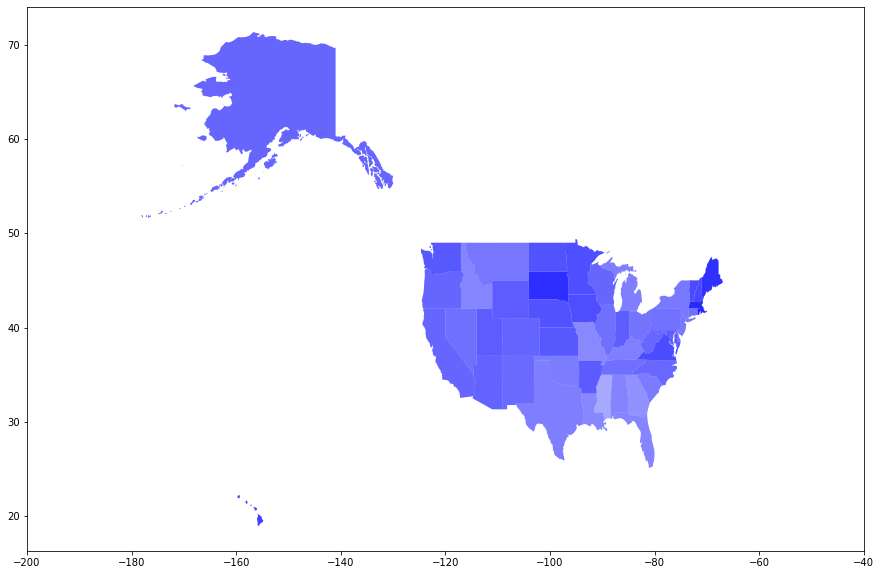

In [297]:
# vaccine rate group by state
vacc_rate_geo=df[['state','vacc_h1n1_f']].groupby(['state']).agg(lambda x: sum(x)/len(x))
x=np.array([-170,-65])
y=np.array([20,60])
plt.figure(figsize=(15,10))
plt.plot(x,y,color='None')
for s in state_geo:
    coor=s['geometry']['coordinates']
    if len(coor)==1:
        p=Polygon(coor[0],facecolor=(0,0,1,vacc_rate_geo.loc[s['id']]['vacc_h1n1_f']*2.5))
        plt.gca().add_patch(p)
    else:
        for island in coor:
            p=Polygon(island[0],facecolor=(0,0,1,vacc_rate_geo.loc[s['id']]['vacc_h1n1_f']*2.5))
            plt.gca().add_patch(p)
plt.xlim([-200,-40])
plt.show()

In [298]:
# region relationships, census_msa can't be seperated by state
hhs={}
for i in range(10):
    hhs[f'Region{i+1}']=[]
census={
    'west':[],
    'midwest':[],
    'northeast':[],
    'south':[]
}
for s in df['state'].unique():
    hhs[df[df['state']==s]['hhs_region'].unique()[0]].append(s)
    census[df[df['state']==s]['census_region'].unique()[0]].append(s)
region_dict={}
for s in df['state'].unique():
    region_dict[s]=[df[df['state']==s]['hhs_region'].unique()[0],df[df['state']==s]['census_region'].unique()[0]]

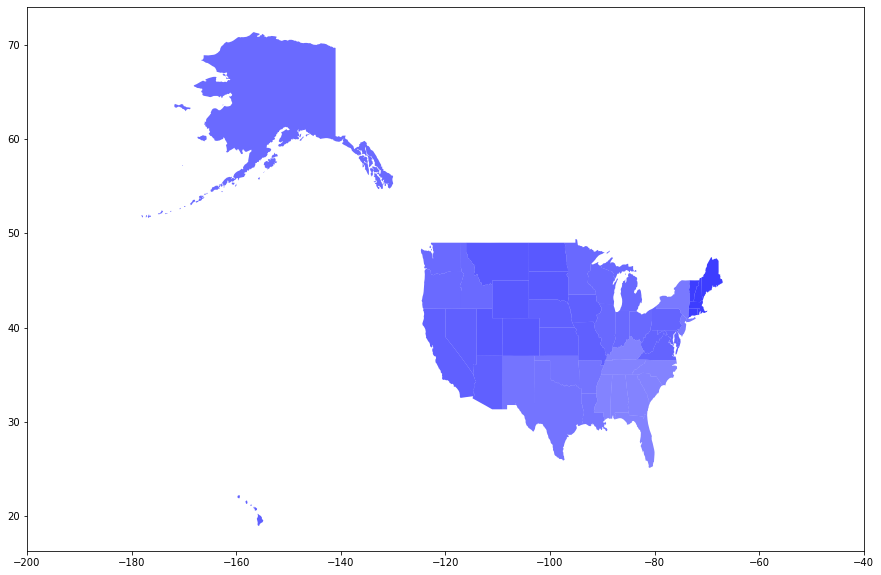

In [299]:
# vaccine rate group by hhs_region
vacc_rate_hhs=df[['hhs_region','vacc_h1n1_f']].groupby(['hhs_region']).agg(lambda x: sum(x)/len(x))
x=np.array([-170,-65])
y=np.array([20,60])
plt.figure(figsize=(15,10))
plt.plot(x,y,color='None')
for s in state_geo:
    coor=s['geometry']['coordinates']
    if len(coor)==1:
        p=Polygon(coor[0],facecolor=(0,0,1,vacc_rate_hhs.loc[region_dict[s['id']][0]]['vacc_h1n1_f']*2.5))
        plt.gca().add_patch(p)
    else:
        for island in coor:
            p=Polygon(island[0],facecolor=(0,0,1,vacc_rate_hhs.loc[region_dict[s['id']][0]]['vacc_h1n1_f']*2.5))
            plt.gca().add_patch(p)
plt.xlim([-200,-40])
plt.show()

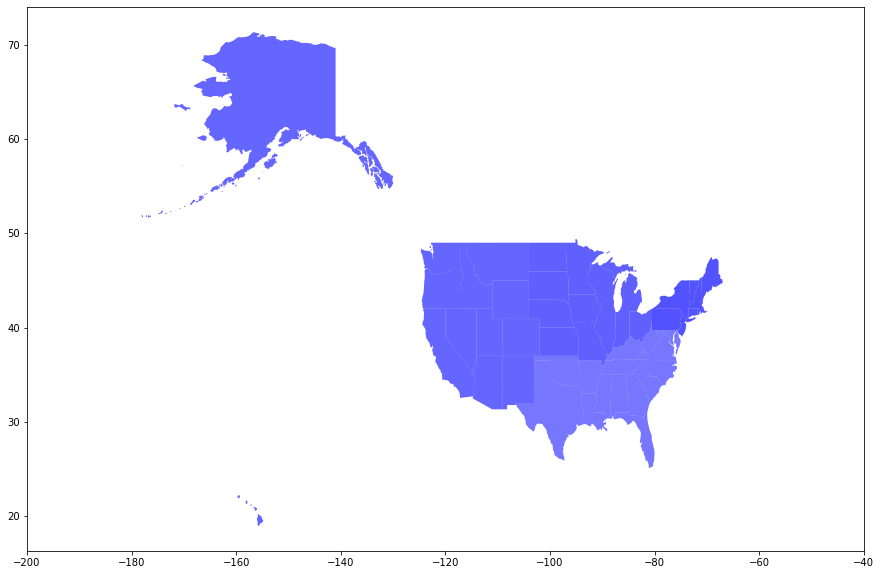

In [300]:
# vaccine rate group by census_region
vacc_rate_census=df[['census_region','vacc_h1n1_f']].groupby(['census_region']).agg(lambda x: sum(x)/len(x))
x=np.array([-170,-65])
y=np.array([20,60])
plt.figure(figsize=(15,10))
plt.plot(x,y,color='None')
for s in state_geo:
    coor=s['geometry']['coordinates']
    if len(coor)==1:
        p=Polygon(coor[0],facecolor=(0,0,1,vacc_rate_census.loc[region_dict[s['id']][1]]['vacc_h1n1_f']*2.5))
        plt.gca().add_patch(p)
    else:
        for island in coor:
            p=Polygon(island[0],facecolor=(0,0,1,vacc_rate_census.loc[region_dict[s['id']][1]]['vacc_h1n1_f']*2.5))
            plt.gca().add_patch(p)
plt.xlim([-200,-40])
plt.show()

(state, hhs_region, census_region)x(vacc_h1n1_f, ...) more EDA probability

#### Multivariate analysis

##### Missing pattern and Structurally missing data

In [301]:
#dummy variable of missing values
df_MV=df[:].isna()
df_MV.columns = map(lambda x: x+'_mv',df.columns)
df_MV.head()

,h1n1_concern_mv,h1n1_knowledge_mv,behavioral_antiviral_meds_mv,behavioral_avoidance_mv,behavioral_face_mask_mv,behavioral_wash_hands_mv,behavioral_large_gatherings_mv,behavioral_outside_home_mv,behavioral_touch_face_mv,doctor_recc_h1n1_mv,...,census_msa_mv,n_adult_r_mv,household_children_mv,n_people_r_mv,employment_industry_mv,employment_occupation_mv,hhs_region_mv,state_mv,vacc_h1n1_f_mv,vacc_seas_f_mv
0,True,True,True,True,True,True,True,True,True,False,...,False,False,False,False,True,True,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


<AxesSubplot:>

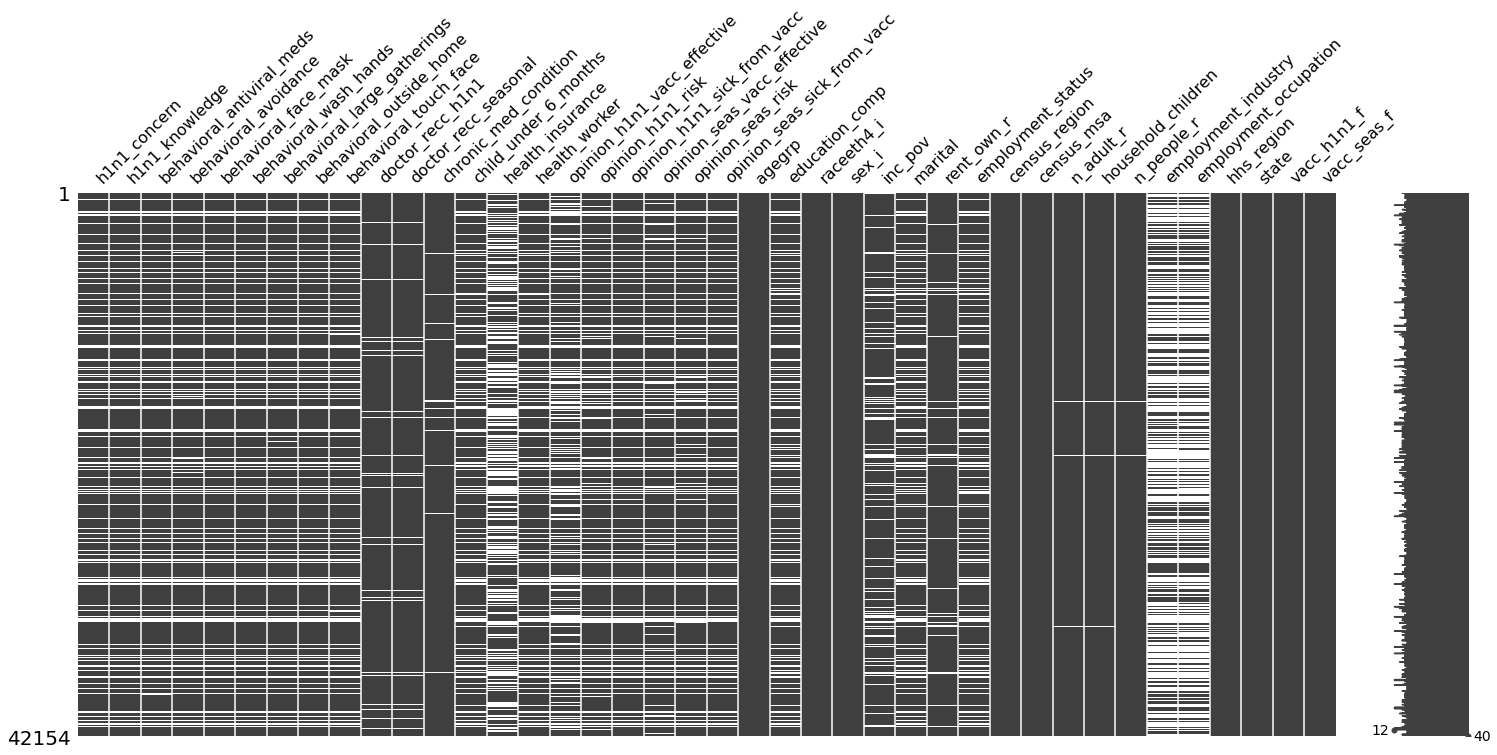

In [302]:
msno.matrix(df)

<AxesSubplot:>

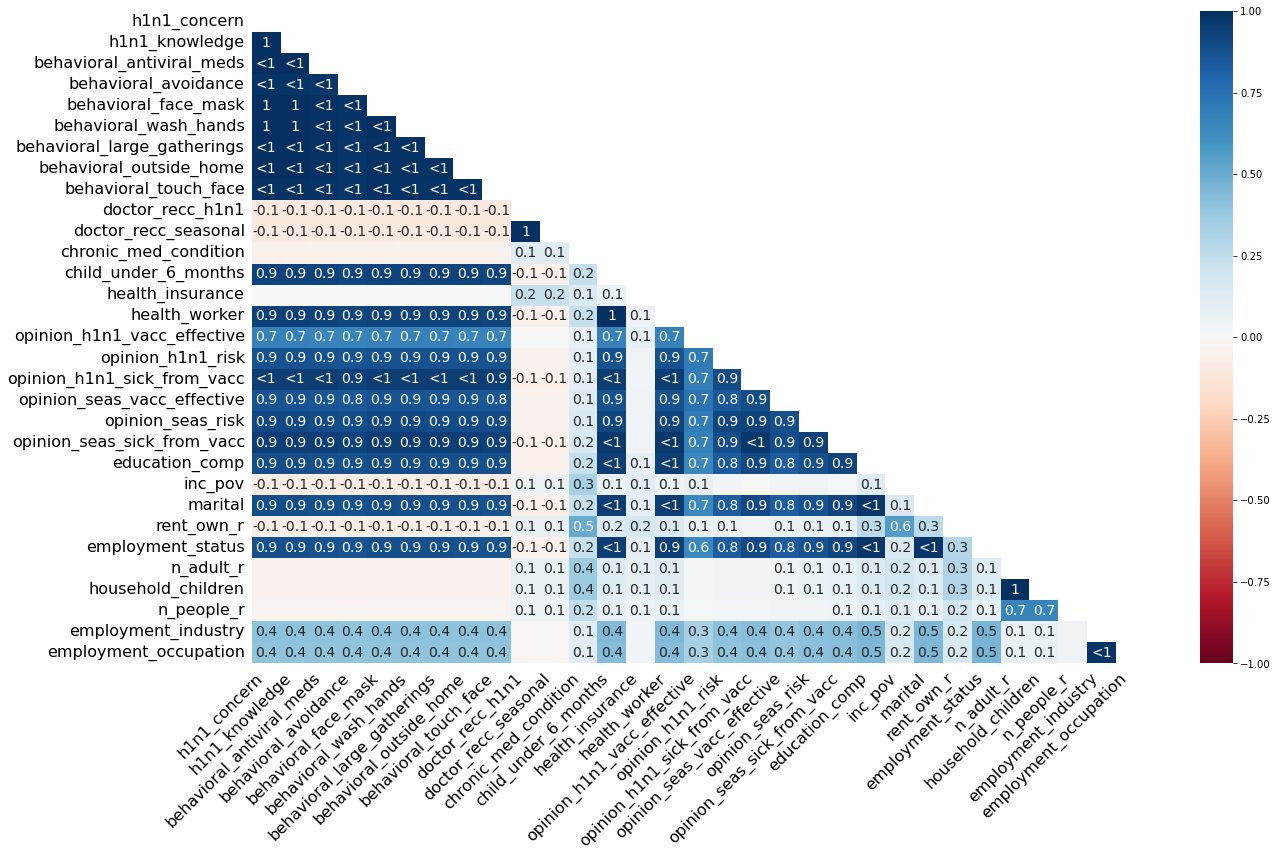

In [303]:
msno.heatmap(df)

<AxesSubplot:ylabel='Density'>

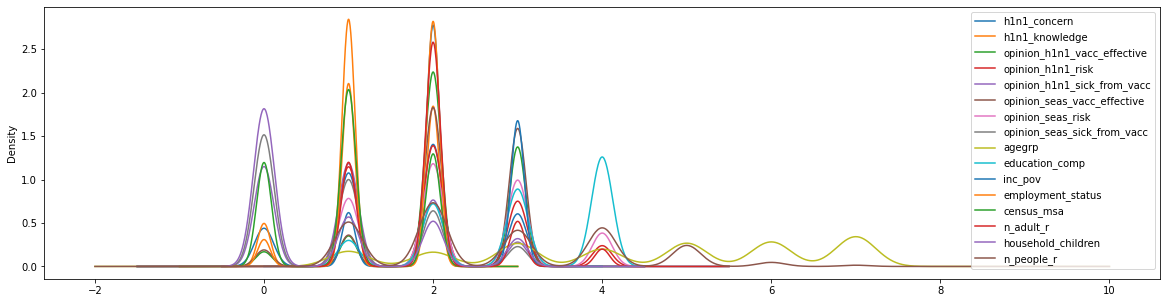

In [304]:
df.plot.density(figsize=(20,5))

- Missing patterns   
    - pattern_A
        - h1n1_concern
        - h1n1_knowledge
        - behavioral_antiviral_meds
        - behavioral_avoidance
        - behavioral_face_mask
        - behavioral_wash_hands
        - behavioral_large_gatherings
        - behavioral_outside_home
        - behavioral_touch_face
        - child_under_6_months
        - health_worker
        - opinion_h1n1_vacc_effective *
        - opinion_h1n1_risk
        - opinion_h1n1_sick_from_vacc
        - opinion_seas_vacc_effective
        - opinion_seas_risk
        - opinion_seas_sick_from_vacc
        - education_comp
        - marital
        - employment_status
    - pattern_B
        - doctor_recc_h1n1
        - doctor_recc_seasonal
    - pattern_C
        - n_adult_r
        - househole_children
        - n_people_r
    - pattern_D
        - employment_industry
        - employment_occupation

- Structurally missing data

In [305]:
#corr 직접 구해야함. corr()메소드는 50개만 구함, 이거따로 바로 위로올라갈지도
df_MV_corr=pd.concat([df,df_MV],axis=1)
df.shape, df_MV.shape, df_MV_corr.shape
#이 방법 말고 structurely missing data 검출가능한가?
# smd는 특정 카테고리가 특정 feature에서 전부 nan값이 떠야함 아니면 대부분?
# 즉 특정 카테고리가 특정 feature에서 전부 nan이 뜨는 경우들 중 smd가 있음.

((42154, 40), (42154, 40), (42154, 80))

In [306]:
#agegrp에 하기전에 무직 Null값채우기 해야함. 개별분석에서 agegrp이랑 겹치는줄알고 지움
df[df['employment_status']=='Unemployed']['employment_industry'].value_counts()

Series([], Name: employment_industry, dtype: int64)

Filling some MVs with age_group
- 1: '6 Months - 9 Years'
- 2: '10 - 17 Years'
- 3: '18 - 34 Years'
- 4: '35 - 44 Years'
- 5: '45 - 54 Years'
- 6: '55 - 64 Years'
- 7: '65+ Years'


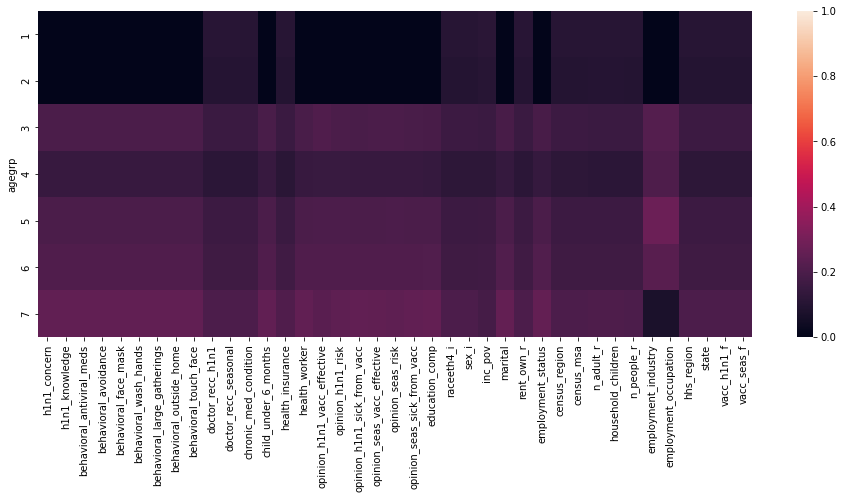

In [307]:
fig, ax = plt.subplots(figsize=(16,6),nrows=1,ncols=1)
ax=sns.heatmap(df.groupby('agegrp').count().apply(lambda x: x/x.sum()),vmin=0,vmax=1,ax=ax)


In [308]:
#1,2,7그룹으로 결측치 채우기
df['child_under_6_months']=df.apply(lambda x: 0 if x['agegrp'] in (1,2) else x['child_under_6_months'],axis=1)
df['health_worker']=df.apply(lambda x: 1 if x['agegrp'] in (1,2) else x['health_worker'],axis=1)
df['education_comp']=df.apply(lambda x: 1 if x['agegrp'] in (1,2) else x['education_comp'],axis=1)
df['marital']=df.apply(lambda x: False if x['agegrp'] in (1,2) else x['marital'],axis=1)
df['employment_status']=df.apply(lambda x: 0 if x['agegrp'] in (1,2) else x['employment_status'],axis=1)
df['employment_industry']=df.apply(lambda x: 'student' if x['agegrp'] in (1,2) else x['employment_industry'],axis=1)
df['employment_occupation']=df.apply(lambda x: 'student' if x['agegrp'] in (1,2) else x['employment_occupation'],axis=1)
df['employment_status']=df.apply(lambda x: 0 if x['agegrp'] == 7 else x['employment_status'],axis=1)
df['employment_industry']=df.apply(lambda x: 'homekeeper' if x['agegrp'] == 7 else x['employment_industry'],axis=1)
df['employment_occupation']=df.apply(lambda x: 'homekeeper' if x['agegrp'] == 7 else x['employment_occupation'],axis=1)


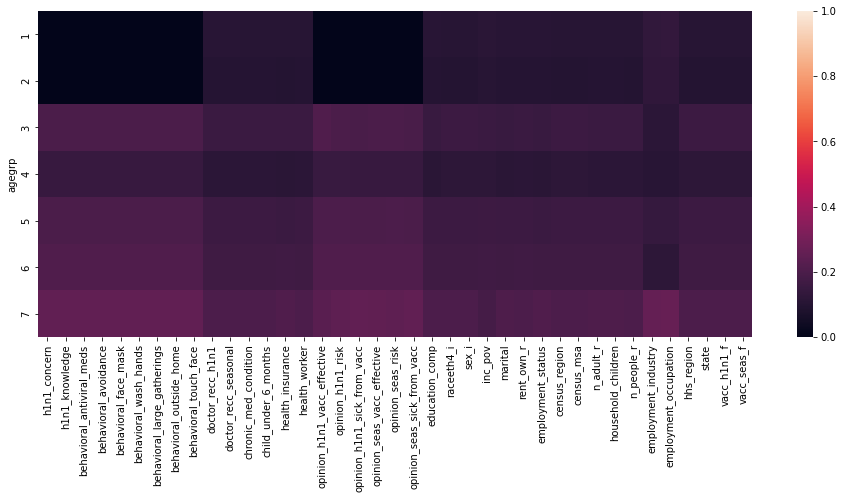

In [309]:
fig, ax = plt.subplots(figsize=(16,6),nrows=1,ncols=1)
ax=sns.heatmap(df.groupby('agegrp').count().apply(lambda x: x/x.sum()),vmin=0,vmax=1,ax=ax)

<AxesSubplot:>

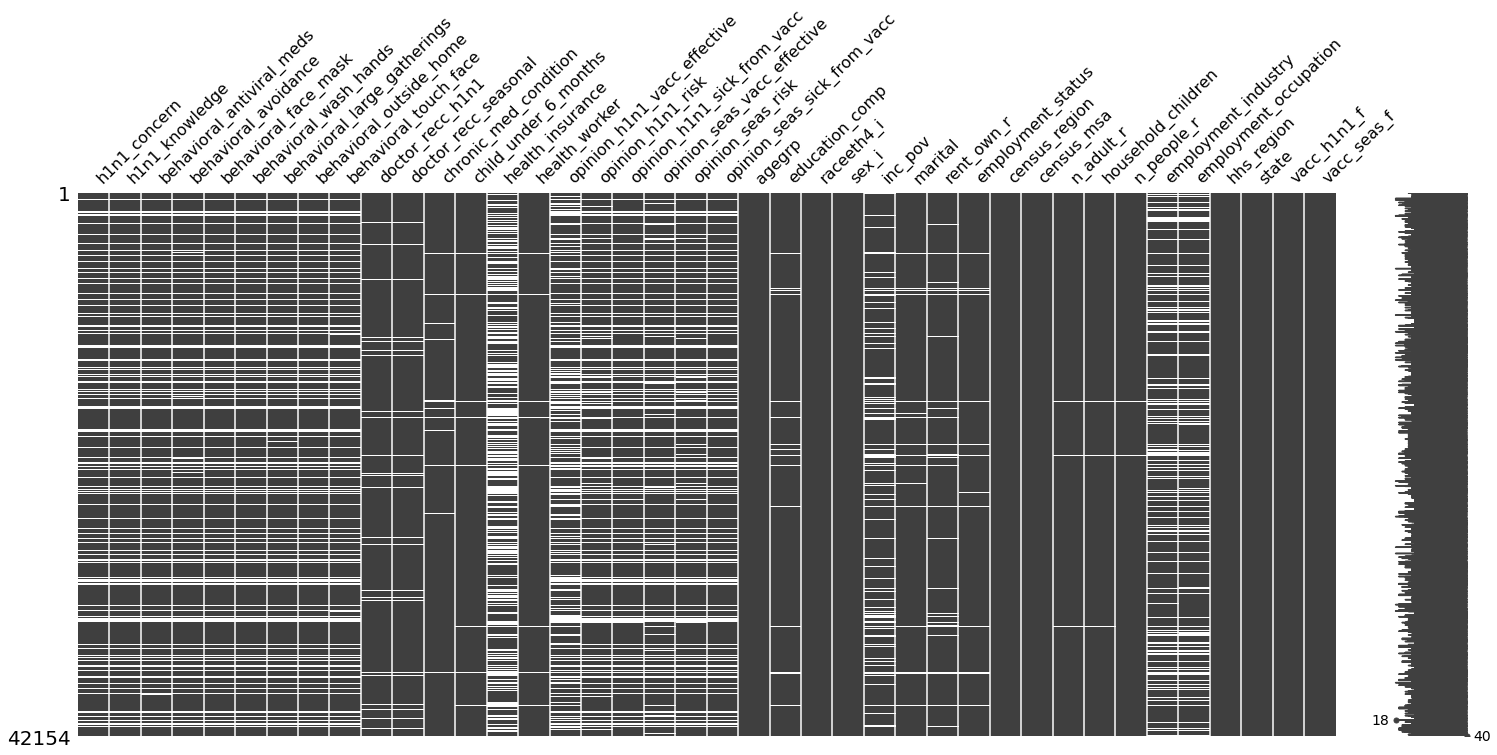

In [310]:
msno.matrix(df)

In [311]:
# n_people_r = n_adult_r + household_children
for i in range(len(df)):
    pList=[df['n_people_r'][i], df['n_adult_r'][i], df['household_children'][i]]
    if np.isnan(pList).sum()==1:
        if np.isnan(pList[0]):
            df['n_people_r'][i] = df['n_adult_r'][i] + df['household_children'][i]
        elif np.isnan(pList[1]):
            df['n_adult_r'][i] = df['n_people_r'][i] - df['household_children'][i]
        else:
            df['household_children'][i] = df['n_people_r'][i] - df['n_adult_r'][i]
            

MCAR

In [312]:
# feature - MV_dummy_feature chi2 test
# H0 : they are independent.
# Ha : they are not independent.
# p<0.05 : dismiss H0 and select Ha.
# p>0.05 : don't know.
# p<0.05 for at least 1 featrue : It is related to some features so it is not MCAR.
# p>0.05 for all features : It can be MCAR. more analysis needed. store at suspect.
suspect=[]
for i in df_MV.columns:
    molu=True
    if df_MV[i].sum()==0:
        print(f'there is no MV in {i}')
        continue
    for j in df.columns:
        obs=pd.crosstab(df_MV[i],df[j])
        p=scipy.stats.chi2_contingency(obs)[1]
        if p<0.05 :
            print(f'{i} is not MCAR')
            molu=False
            break
    if molu:
        print(f'{i} can be MCAR')
        suspect.append(i)


h1n1_concern_mv is not MCAR
h1n1_knowledge_mv is not MCAR
behavioral_antiviral_meds_mv is not MCAR
behavioral_avoidance_mv is not MCAR
behavioral_face_mask_mv is not MCAR
behavioral_wash_hands_mv is not MCAR
behavioral_large_gatherings_mv is not MCAR
behavioral_outside_home_mv is not MCAR
behavioral_touch_face_mv is not MCAR
doctor_recc_h1n1_mv is not MCAR
doctor_recc_seasonal_mv is not MCAR
chronic_med_condition_mv is not MCAR
child_under_6_months_mv is not MCAR
health_insurance_mv is not MCAR
health_worker_mv is not MCAR
opinion_h1n1_vacc_effective_mv is not MCAR
opinion_h1n1_risk_mv is not MCAR
opinion_h1n1_sick_from_vacc_mv is not MCAR
opinion_seas_vacc_effective_mv is not MCAR
opinion_seas_risk_mv is not MCAR
opinion_seas_sick_from_vacc_mv is not MCAR
there is no MV in agegrp_mv
education_comp_mv is not MCAR
there is no MV in raceeth4_i_mv
there is no MV in sex_i_mv
inc_pov_mv is not MCAR
marital_mv is not MCAR
rent_own_r_mv is not MCAR
employment_status_mv is not MCAR
there is no

In [313]:
print(suspect)

[]


##### Test of Independence

In [317]:
# nominal-nominal : chi2 and fisher
# bool-ordinal : Mann Whitney U test groupby bool
# nominal-ordinal : Kruskal–Wallis groupby nominal
# ordinal-ordinal : Mann Whitney U test

for i in itertools.combinations(df.columns,2):
    if not set(i)-set(('nominal','bool')):
        obs=pd.crosstab(df[i[0]],df[i[1]])
        obsl=list(itertools.chain.from_iterable(np.array(obs)))
        l=len(obsl)
        a=len(list(itertools.filterfalse(lambda x: x<5,map(lambda x: x[0]*x[1]/sum(obsl),itertools.permutations(obsl,2)))))
        if a<l/5: # fisher
            if l==4:
                p=scipy.stats.fisher_exact(obs)
                if p<0.05:
                    print(f'{i[0]} and {i[1]} are NOT independent, p={p:.3f}')
        else: # chi2
            p=scipy.stats.chi2_contingency(obs,correction=False)[1]
            if p<0.05:
                print(f'{i[0]} and {i[1]} are NOT independent, p={p:.3f}')

    elif not set(i)-set(('ordinal','interval')): # 
        p=scipy.stats.mannwhitneyu(i[0],i[1])
        if p[1]<0.05:
            print(i[0],i[1],p)
    elif set(i)==set(('bool','interval')) or set(i)==set(('bool','ordinal')):
        if i[0]=='bool':
            a=df[df[i[0]]==1]
            b=df[df[i[0]]==0]
        else:
            a=df[df[i[1]]==1]
            b=df[df[i[1]]==0]
        p=scipy.stats.mannwhitneyu(a,b)
        if p[1]<0.05:
            print(i[0],i[1],p)
    else:
        catlist=[]
        if i[0]=='nominal':
            for cat in df[i[0]].unique():
                catlist.append(df[df[i[0]]==cat][i[1]])
        else:
            for cat in df[i[1]].unique():
                catlist.append(df[df[i[1]]==cat][i[0]])
        p=scipy.stats.kruskal(*catlist)
        if p[1]<0.05:
            print(i[0],i[1],p)

agegrp raceeth4_i KruskalResult(statistic=1547.4654784589627, pvalue=0.0)
agegrp sex_i KruskalResult(statistic=388.5056966746149, pvalue=1.7506143490412794e-86)
agegrp census_region KruskalResult(statistic=26.926243913559276, pvalue=6.100732889970908e-06)
agegrp census_msa KruskalResult(statistic=125.65708990342466, pvalue=5.174991269624616e-28)
agegrp hhs_region KruskalResult(statistic=31.003962246930378, pvalue=0.00029556894092389686)
agegrp state KruskalResult(statistic=246.38230204117266, pvalue=9.398086480137904e-28)
agegrp vacc_h1n1_f KruskalResult(statistic=240.4030667542313, pvalue=3.2123235626992174e-54)
agegrp vacc_seas_f KruskalResult(statistic=1543.7292799819413, pvalue=0.0)
raceeth4_i sex_i KruskalResult(statistic=13.78704516038518, pvalue=0.0002047431842929651)
raceeth4_i census_region KruskalResult(statistic=871.6176932757821, pvalue=1.268303610414832e-188)
raceeth4_i census_msa KruskalResult(statistic=928.7125936050917, pvalue=2.1509120946546747e-202)
raceeth4_i hhs_reg

##### category reduction

##### Correlation

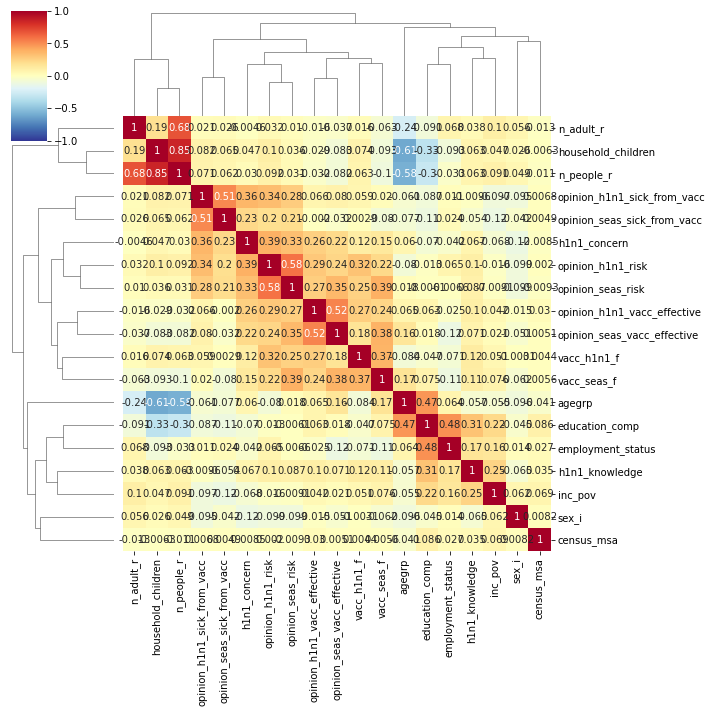

In [ ]:
corr = df.corr(method='pearson')
sns.clustermap(corr, 
               annot = True,      # 실제 값 화면에 나타내기
               cmap = 'RdYlBu_r',  # Red, Yellow, Blue 색상으로 표시
               vmin = -1, vmax = 1, #컬러차트 -1 ~ 1 범위로 표시
              )

In [ ]:
a=df['behavioral_antiviral_meds']
b=df['behavioral_avoidance']
c=pd.crosstab(a,b)

obsl=list(itertools.chain.from_iterable(np.array(c)))
d=len(obsl)
e=len(list(itertools.filterfalse(lambda x: x>5,map(lambda x: x[0]*x[1]/sum(obsl),itertools.permutations(obsl,2)))))
list(itertools.filterfalse(lambda x: x<5,map(lambda x: x[0]*x[1]/sum(obsl),itertools.permutations(obsl,2))))

[6031.272523062178,
 76.14511201629328,
 371.7673116089613,
 6031.272523062178,
 198.14002036659878,
 967.3895112016294,
 76.14511201629328,
 198.14002036659878,
 12.213340122199593,
 371.7673116089613,
 967.3895112016294,
 12.213340122199593]

##### Factor analysis

PCA

##### Clustering

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances

# X shoudl be a numpy matrix, very likely sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html#scipy.sparse.csr_matrix
# T1 > T2 for overlapping clusters
# T1 = Distance to centroid point to not include in other clusters
# T2 = Distance to centroid point to include in cluster
# T1 > T2 for overlapping clusters
# T1 < T2 will have points which reside in no clusters
# T1 == T2 will cause all points to reside in mutually exclusive clusters
# Distance metric can be any from here: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.pairwise_distances.html
# filemap may be a list of point names in their order in X. If included, row numbers from X will be replaced with names from filemap. 
 
def canopy(X, T1, T2, distance_metric='euclidean', filemap=None):
    canopies = dict()
    X1_dist = pairwise_distances(X, metric=distance_metric)
    canopy_points = set(range(X.shape[0]))
    while canopy_points:
        point = canopy_points.pop()
        i = len(canopies)
        canopies[i] = {"c":point, "points": list(np.where(X1_dist[point] < T2)[0])}
        canopy_points = canopy_points.difference(set(np.where(X1_dist[point] < T1)[0]))
    if filemap:
        for canopy_id in canopies.keys():
            canopy = canopies.pop(canopy_id)
            canopy2 = {"c":filemap[canopy['c']], "points":list()}
            for point in canopy['points']:
                canopy2["points"].append(filemap[point])
            canopies[canopy_id] = canopy2
    return canopies

In [ ]:
cnp=canopy(df_encode.dropna(),8,5)
print(len(cnp))
print(cnp)

6
{0: {'c': 0, 'points': [0, 64, 73, 76, 219, 288, 356, 387, 590, 613, 640, 665, 722, 743, 764, 807, 848, 876, 927, 1090, 1114, 1137, 1148, 1199, 1209, 1490, 1511, 1575, 1610, 1626, 1627, 1649, 1717, 1746, 1787, 1826, 1864, 1967, 1982, 2064, 2094, 2112, 2183, 2187, 2208, 2221, 2272, 2282, 2332, 2371, 2386, 2441, 2470, 2506, 2546, 2564, 2591, 2615, 2639, 2651, 2656, 2724, 2740, 2843, 2849, 2947, 2963, 2993, 3041, 3069, 3085, 3096, 3181, 3185, 3294, 3300, 3348, 3367, 3400, 3459, 3472, 3476, 3485, 3495, 3516, 3534, 3539, 3619, 3654, 3667, 3717, 3726, 3764, 3798, 3875, 3919, 3938, 3943, 4053, 4069, 4231, 4233, 4274, 4296, 4314, 4326, 4378, 4383, 4442, 4471, 4547, 4567, 4596, 4599, 4604, 4606, 4625, 4659, 4666, 4786, 4793, 4795, 4815, 4823, 4910, 4958, 4967, 5025, 5048, 5050, 5051, 5088, 5135, 5187, 5240, 5272, 5296, 5343, 5353, 5394, 5448, 5473, 5489, 5577, 5599, 5614, 5682, 5782, 5841, 5916, 5917, 5951, 5965, 5999, 6059, 6129, 6141, 6173, 6175, 6178, 6228, 6243, 6407, 6414, 6500, 6517, 66

In [ ]:
!pip install kpod

In [ ]:
# import the k_pod method
from kPOD import k_pod

# set the number of clusters desired (in this example, 3)
K = 6

# use previously existing data to perform clustering
clustering_results = k_pod(df_encode, K)

# k_pod outputs a tuple with the cluster assignments and centers
print(clustering_results)


# save the cluster assignments and centers
cluster_assignments = clustering_results[0]
cluster_centers = clustering_results[1]

(array([0., 3., 5., ..., 0., 3., 0.]), [array([1.121247225945596, 1.146555739949074, 0.2845161685419794,
       0.7235277725419688, 0.27475320573495615, 0.7885625360721131,
       0.42828171943166266, 0.42100132597101436, 0.6765460091103526,
       0.27915233487364577, 0.3100744638640653, 0.13137856044034274,
       0.3420973953941767, 0.8744332468007551, 0.3511024472580065,
       1.4638089838367023, 1.4069452540374885, 0.8446031616953481,
       1.4990580740076462, 1.5148265446689526, 0.7615435704257167,
       2.229273603981957, 2.2423642794507703, 0.08624980556851765,
       0.20197542386063153, 0.797869030953492, 0.5017109970446415,
       2.2413110787840544, 0.712510187941039, 0.7526227897879745,
       1.3545370272745092, 0.3414994555918494, 0.3815523409550474,
       0.4396484678799191, 1.0158656089594027, 2.1929386091413123,
       1.756791406906941, 3.950393766067687, 0.5088510501417612,
       0.6265520130914646, 0.7150172849418378, 0.6284566714532756,
       0.7073672146446

42154

In [321]:
(len(df), len(clustering_results[0]))

NameError: name 'clustering_results' is not defined

Functionization

In [ ]:
def EDA(df):
    df['opinion_h1n1_vacc_effective'].replace('Dont Know',np.nan,inplace=True)
    df['opinion_h1n1_vacc_effective'].replace('Refused',np.nan,inplace=True)
    df['opinion_h1n1_vacc_effective'].replace('Not At All Effective',0,inplace=True)
    df['opinion_h1n1_vacc_effective'].replace('Not Very Effective',1,inplace=True)
    df['opinion_h1n1_vacc_effective'].replace('Somewhat Effective',2,inplace=True)
    df['opinion_h1n1_vacc_effective'].replace('Very Effective',3,inplace=True)
    df['opinion_h1n1_risk'].replace('Dont Know',np.nan,inplace=True)
    df['opinion_h1n1_risk'].replace('Refused',np.nan,inplace=True)
    df['opinion_h1n1_risk'].replace('Very Low',1,inplace=True)
    df['opinion_h1n1_risk'].replace('Somewhat Low',2,inplace=True)
    df['opinion_h1n1_risk'].replace('Somewhat High',3,inplace=True)
    df['opinion_h1n1_risk'].replace('Very High',4,inplace=True)
    df['opinion_h1n1_sick_from_vacc'].replace('Dont Know',np.nan,inplace=True)
    df['opinion_h1n1_sick_from_vacc'].replace('Refused',np.nan,inplace=True)
    df['opinion_h1n1_sick_from_vacc'].replace('Not At All Worried',0,inplace=True)
    df['opinion_h1n1_sick_from_vacc'].replace('Not Very Worried',1,inplace=True)
    df['opinion_h1n1_sick_from_vacc'].replace('Somewhat Worried',2,inplace=True)
    df['opinion_h1n1_sick_from_vacc'].replace('Very Worried',3,inplace=True)
    df['opinion_seas_vacc_effective'].replace('Dont Know',np.nan,inplace=True)
    df['opinion_seas_vacc_effective'].replace('Refused',np.nan,inplace=True)
    df['opinion_seas_vacc_effective'].replace('Not At All Effective',0,inplace=True)
    df['opinion_seas_vacc_effective'].replace('Not Very Effective',1,inplace=True)
    df['opinion_seas_vacc_effective'].replace('Somewhat Effective',2,inplace=True)
    df['opinion_seas_vacc_effective'].replace('Very Effective',3,inplace=True)
    df['opinion_seas_risk'].replace('Dont Know',np.nan,inplace=True)
    df['opinion_seas_risk'].replace('Refused',np.nan,inplace=True)
    df['opinion_seas_risk'].replace('Very Low',1,inplace=True)
    df['opinion_seas_risk'].replace('Somewhat Low',2,inplace=True)
    df['opinion_seas_risk'].replace('Somewhat High',3,inplace=True)
    df['opinion_seas_risk'].replace('Very High',4,inplace=True)
    df['opinion_seas_sick_from_vacc'].replace('Dont Know',np.nan,inplace=True)
    df['opinion_seas_sick_from_vacc'].replace('Refused',np.nan,inplace=True)
    df['opinion_seas_sick_from_vacc'].replace('Not At All Worried',0,inplace=True)
    df['opinion_seas_sick_from_vacc'].replace('Not Very Worried',1,inplace=True)
    df['opinion_seas_sick_from_vacc'].replace('Somewhat Worried',2,inplace=True)
    df['opinion_seas_sick_from_vacc'].replace('Very Worried',3,inplace=True)
    df['agegrp'].replace('6 Months - 9 Years',1,inplace=True)
    df['agegrp'].replace('10 - 17 Years',2,inplace=True)
    df['agegrp'].replace('18 - 34 Years',3,inplace=True)
    df['agegrp'].replace('35 - 44 Years',4,inplace=True)
    df['agegrp'].replace('45 - 54 Years',5,inplace=True)
    df['agegrp'].replace('55 - 64 Years',6,inplace=True)
    df['agegrp'].replace('65+ Years',7,inplace=True)
    df['raceeth4_i'].replace(1,'Hispanic',inplace=True)
    df['raceeth4_i'].replace(2,'Non-Hispanic, Black Only',inplace=True)
    df['raceeth4_i'].replace(3,'Non-Hispanic, White Only',inplace=True)
    df['raceeth4_i'].replace(4,'Non-Hispanic, Other or Multiple Races ',inplace=True)
    df['sex_i'].replace(2,0,inplace=True)
    df['inc_pov'].replace(4,np.nan,inplace=True)
    df['inc_pov'].replace(3,5,inplace=True)
    df['inc_pov'].replace(1,3,inplace=True)
    df['inc_pov'].replace(5,1,inplace=True)
    df['rent_own_r'].replace(77,np.nan,inplace=True)
    df['rent_own_r'].replace(99,np.nan,inplace=True)
    df['rent_own_r'].replace(2,0,inplace=True)
    df['employment_status'].replace('Unemployed',0,inplace=True)
    df['employment_status'].replace('Not in Labor Force',1,inplace=True)
    df['employment_status'].replace('Employed',2,inplace=True)
    df['census_region'].replace(1,'northeast',inplace=True)
    df['census_region'].replace(2,'midwest',inplace=True)
    df['census_region'].replace(3,'south',inplace=True)
    df['census_region'].replace(4,'west',inplace=True)
    df['census_msa'].replace('Non-MSA',0,inplace=True)
    df['census_msa'].replace('MSA, Not Principle City',1,inplace=True)
    df['census_msa'].replace('MSA, Principle City',2,inplace=True)
    df['employment_industry'].replace('Refused, classified',np.nan,inplace=True)
    df['employment_industry'].replace('Not ascertained',np.nan,inplace=True)
    df['employment_occupation'].replace('Refused, classified',np.nan,inplace=True)
    df['employment_occupation'].replace('Not ascertained',np.nan,inplace=True)
    df['hhs_region']=df['hhs_region'].map(lambda x: 'Region'+str(x))
    df['state'].replace('ALABAMA','AL',inplace=True)
    df['state'].replace('ALASKA','AK',inplace=True)
    df['state'].replace('ARIZONA','AZ',inplace=True)
    df['state'].replace('ARKANSAS','AR',inplace=True)
    df['state'].replace('CALIFORNIA','CA',inplace=True)
    df['state'].replace('COLORADO','CO',inplace=True)
    df['state'].replace('CONNECTICUT','CT',inplace=True)
    df['state'].replace('DELAWARE','DE',inplace=True)
    df['state'].replace('DISTRICTOF COLUMBIA','DC',inplace=True)
    df['state'].replace('FLORIDA','FL',inplace=True)
    df['state'].replace('GEORGIA','GA',inplace=True)
    df['state'].replace('HAWAII','HI',inplace=True)
    df['state'].replace('IDAHO','ID',inplace=True)
    df['state'].replace('ILLINOIS','IL',inplace=True)
    df['state'].replace('INDIANA','IN',inplace=True)
    df['state'].replace('IOWA','IA',inplace=True)
    df['state'].replace('KANSAS','KS',inplace=True)
    df['state'].replace('KENTUCKY','KY',inplace=True)
    df['state'].replace('LOUISIANA','LA',inplace=True)
    df['state'].replace('MAINE','ME',inplace=True)
    df['state'].replace('MARYLAND','MD',inplace=True)
    df['state'].replace('MASSACHUSETTS','MA',inplace=True)
    df['state'].replace('MICHIGAN','MI',inplace=True)
    df['state'].replace('MINNESOTA','MN',inplace=True)
    df['state'].replace('MISSISSIPPI','MS',inplace=True)
    df['state'].replace('MISSOURI','MO',inplace=True)
    df['state'].replace('MONTANA','MT',inplace=True)
    df['state'].replace('NEBRASKA','NE',inplace=True)
    df['state'].replace('NEVADA','NV',inplace=True)
    df['state'].replace('NEW HAMPSHIRE','NH',inplace=True)
    df['state'].replace('NEW JERSEY','NJ',inplace=True)
    df['state'].replace('NEW MEXICO','NM',inplace=True)
    df['state'].replace('NEW YORK','NY',inplace=True)
    df['state'].replace('NORTH CAROLINA','NC',inplace=True)
    df['state'].replace('NORTH DAKOTA','ND',inplace=True)
    df['state'].replace('OHIO','OH',inplace=True)
    df['state'].replace('OKLAHOMA','OK',inplace=True)
    df['state'].replace('OREGON','OR',inplace=True)
    df['state'].replace('PENNSYLVANIA','PA',inplace=True)
    df['state'].replace('RHODE ISLAND','RI',inplace=True)
    df['state'].replace('SOUTH CAROLINA','SC',inplace=True)
    df['state'].replace('SOUTH DAKOTA','SD',inplace=True)
    df['state'].replace('TENNESSEE','TN',inplace=True)
    df['state'].replace('TEXAS','TX',inplace=True)
    df['state'].replace('UTAH','UT',inplace=True)
    df['state'].replace('VERMONT','VT',inplace=True)
    df['state'].replace('VIRGINIA','VA',inplace=True)
    df['state'].replace('WASHINGTON','WA',inplace=True)
    df['state'].replace('WEST VIRGINIA','WV',inplace=True)
    df['state'].replace('WISCONSIN','WI',inplace=True)
    df['state'].replace('WYOMING','WY',inplace=True)
    df['child_under_6_months']=df.apply(lambda x: 0 if x['agegrp'] in (1,2) else x['child_under_6_months'],axis=1)
    df['health_worker']=df.apply(lambda x: 1 if x['agegrp'] in (1,2) else x['health_worker'],axis=1)
    df['education_comp']=df.apply(lambda x: 1 if x['agegrp'] in (1,2) else x['education_comp'],axis=1)
    df['marital']=df.apply(lambda x: False if x['agegrp'] in (1,2) else x['marital'],axis=1)
    df['employment_status']=df.apply(lambda x: 0 if x['agegrp'] in (1,2) else x['employment_status'],axis=1)
    df['employment_industry']=df.apply(lambda x: 'student' if x['agegrp'] in (1,2) else x['employment_industry'],axis=1)
    df['employment_occupation']=df.apply(lambda x: 'student' if x['agegrp'] in (1,2) else x['employment_occupation'],axis=1)
    df['employment_status']=df.apply(lambda x: 0 if x['agegrp'] == 7 else x['employment_status'],axis=1)
    df['employment_industry']=df.apply(lambda x: 'homekeeper' if x['agegrp'] == 7 else x['employment_industry'],axis=1)
    df['employment_occupation']=df.apply(lambda x: 'homekeeper' if x['agegrp'] == 7 else x['employment_occupation'],axis=1)
    for i in range(len(df)):
        pList=[df['n_people_r'][i], df['n_adult_r'][i], df['household_children'][i]]
        if np.isnan(pList).sum()==1:
            if np.isnan(pList[0]):
                df['n_people_r'][i] = df['n_adult_r'][i] + df['household_children'][i]
            elif np.isnan(pList[1]):
                df['n_adult_r'][i] = df['n_people_r'][i] - df['household_children'][i]
            else:
                df['household_children'][i] = df['n_people_r'][i] - df['n_adult_r'][i]
    return df

## Data Preprocessing

### Type casting

In [ ]:
def type_casting(df):
    df['vacc_h1n1_f']=df['vacc_h1n1_f'].astype(bool)
    df['vacc_seas_f']=df['vacc_seas_f'].astype(bool)
    df['h1n1_concern']=df['h1n1_concern'].astype(pd.CategoricalDtype(ordered=True))
    df['h1n1_knowledge']=df['h1n1_knowledge'].astype(pd.CategoricalDtype(ordered=True))
    df['behavioral_antiviral_meds']=df['behavioral_antiviral_meds'].astype(bool)
    df['behavioral_avoidance']=df['behavioral_avoidance'].astype(bool)
    df['behavioral_face_mask']=df['behavioral_face_mask'].astype(bool)
    df['behavioral_wash_hands']=df['behavioral_wash_hands'].astype(bool)
    df['behavioral_large_gatherings']=df['behavioral_large_gatherings'].astype(bool)
    df['behavioral_outside_home']=df['behavioral_outside_home'].astype(bool)
    df['behavioral_touch_face']=df['behavioral_touch_face'].astype(bool)
    df['doctor_recc_h1n1']=df['doctor_recc_h1n1'].astype(bool)
    df['doctor_recc_seasonal']=df['doctor_recc_seasonal'].astype(bool)
    df['chronic_med_condition']=df['chronic_med_condition'].astype(bool)
    df['child_under_6_months']=df['child_under_6_months'].astype(bool)
    df['health_insurance']=df['health_insurance'].astype(bool)
    df['health_worker']=df['health_worker'].astype(bool)
    df['opinion_h1n1_vacc_effective']=df['opinion_h1n1_vacc_effective'].astype(pd.CategoricalDtype(ordered=True))
    df['opinion_h1n1_risk']=df['opinion_h1n1_risk'].astype(pd.CategoricalDtype(ordered=True))
    df['opinion_h1n1_sick_from_vacc']=df['opinion_h1n1_sick_from_vacc'].astype(pd.CategoricalDtype(ordered=True))
    df['opinion_seas_vacc_effective']=df['opinion_seas_vacc_effective'].astype(pd.CategoricalDtype(ordered=True))
    df['opinion_seas_risk']=df['opinion_seas_risk'].astype(pd.CategoricalDtype(ordered=True))
    df['opinion_seas_sick_from_vacc']=df['opinion_seas_sick_from_vacc'].astype(pd.CategoricalDtype(ordered=True))
    df['agegrp']=df['agegrp'].astype(pd.CategoricalDtype(ordered=True))
    df['education_comp']=df['education_comp'].astype(pd.CategoricalDtype(ordered=True))
    df['raceeth4_i']=df['raceeth4_i'].astype('category')
    df['sex_i']=df['sex_i'].astype(bool)
    df['inc_pov']=df['inc_pov'].astype(pd.CategoricalDtype(ordered=True))
    df['marital']=df['marital'].astype(bool)
    df['rent_own_r']=df['rent_own_r'].astype(bool)
    df['employment_status']=df['employment_status'].astype(pd.CategoricalDtype(ordered=True))
    df['census_region']=df['census_region'].astype('category')
    df['census_msa']=df['census_msa'].astype(pd.CategoricalDtype(ordered=True))
    df['n_adult_r']=df['n_adult_r'].astype(pd.CategoricalDtype(ordered=True))
    df['household_children']=df['household_children'].astype(pd.CategoricalDtype(ordered=True))
    df['n_people_r']=df['n_people_r'].astype(pd.CategoricalDtype(ordered=True))
    df['employment_industry']=df['employment_industry'].astype('category')
    df['employment_occupation']=df['employment_occupation'].astype('category')
    df['hhs_region']=df['hhs_region'].astype('category')
    df['state']=df['state'].astype('category')
    return df
df = type_casting(df)

### Feature Engineering

In [ ]:
df_temp=df.drop(['vacc_seas_f'],axis=1)
TARGET='vacc_h1n1_f'
FEATURES=[column for column in df_temp.columns if column!=TARGET]
X_train,X_val,y_train,y_val = train_test_split(df_temp[FEATURES],df_temp[TARGET],test_size=0.3,random_state=42)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((29507, 38), (29507,), (12647, 38), (12647,))

In [ ]:
from sklearn.utils.multiclass import type_of_target
type_of_target(y_train)

'binary'

In [ ]:
clf = LGBMClassifier(
    n_jobs=-1,
    n_estimators=1000,
    learning_rate=0.02,
    num_leaves=32,
    subsample=0.8,
    max_depth=12,
    silent=-1,
    verbose=-1
)

clf.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_val,y_val)],eval_metric='auc',verbose=100,early_stopping_rounds=50)

C:\Users\gram\anaconda3\envs\kaggle\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\gram\anaconda3\envs\kaggle\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\gram\anaconda3\envs\kaggle\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is depr

[100]	training's auc: 0.835264	training's binary_logloss: 0.419376	valid_1's auc: 0.811542	valid_1's binary_logloss: 0.433795
[200]	training's auc: 0.857362	training's binary_logloss: 0.391572	valid_1's auc: 0.816331	valid_1's binary_logloss: 0.423656
[300]	training's auc: 0.874137	training's binary_logloss: 0.373679	valid_1's auc: 0.817555	valid_1's binary_logloss: 0.421505


LGBMClassifier(learning_rate=0.02, max_depth=12, n_estimators=1000,
               num_leaves=32, silent=-1, subsample=0.8, verbose=-1)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

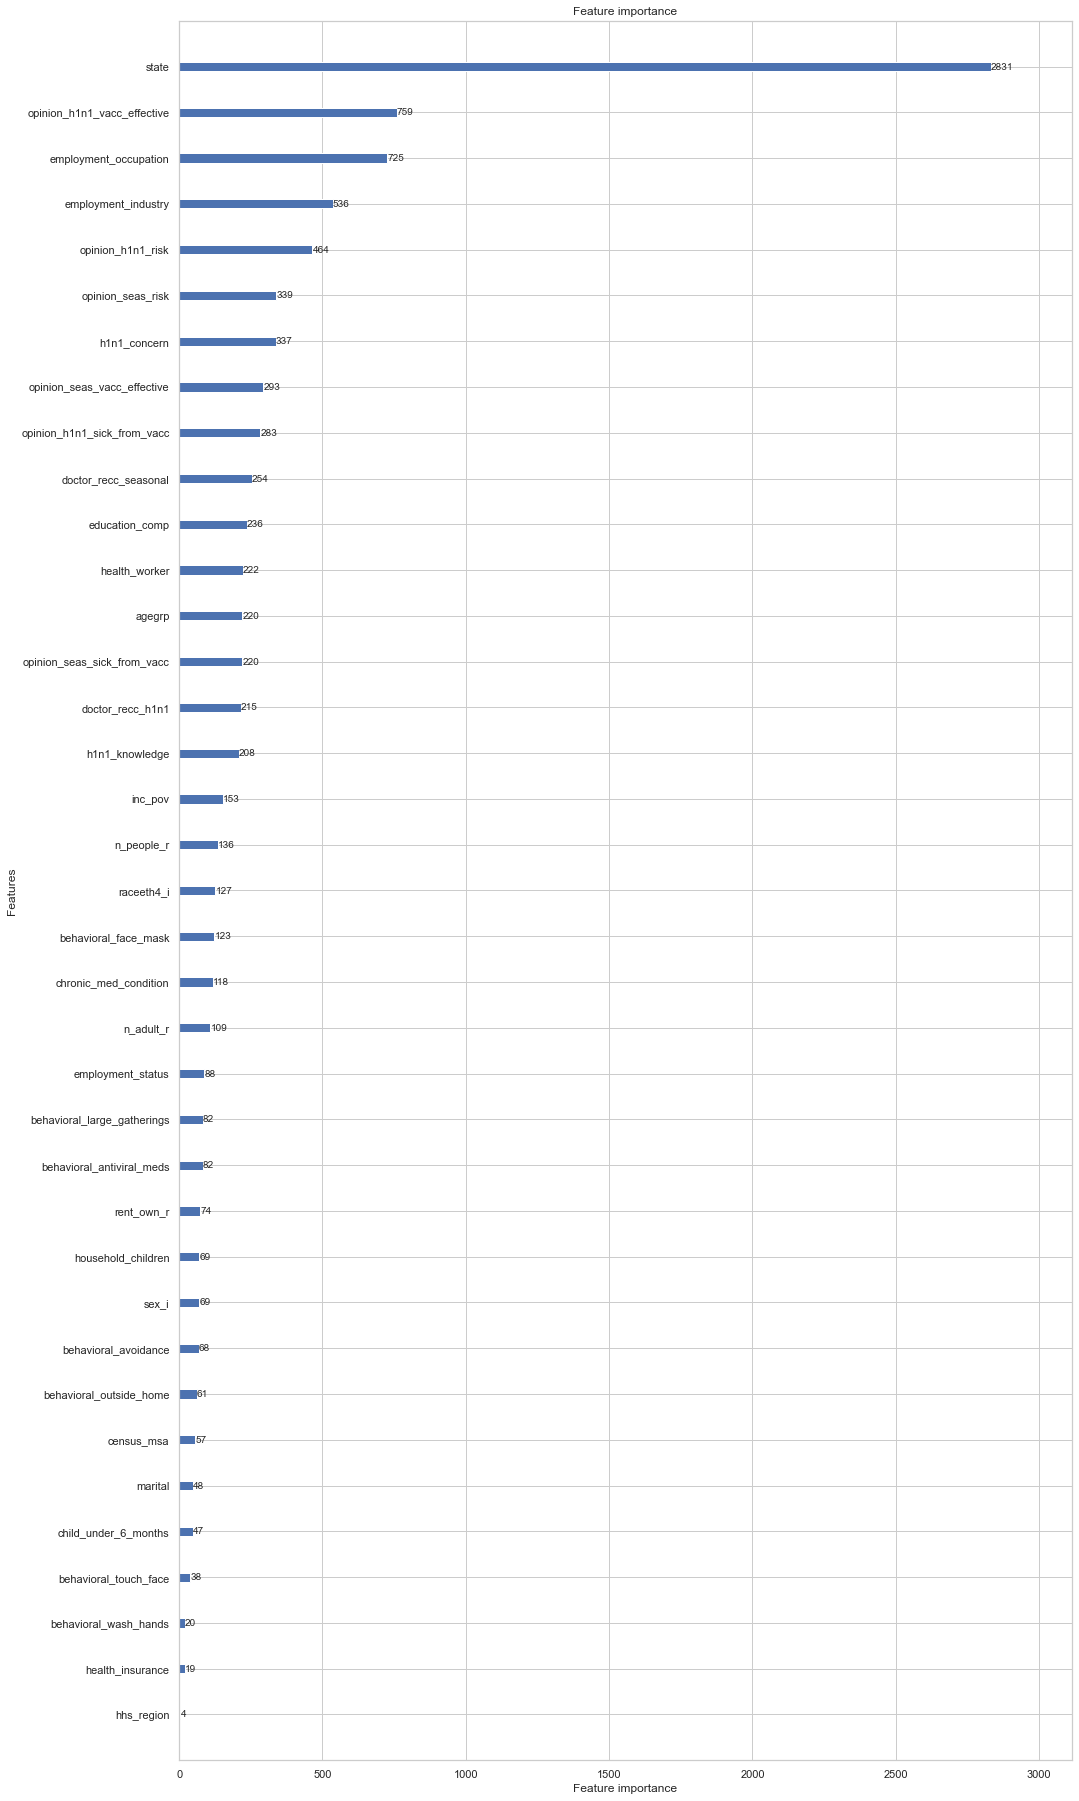

In [ ]:
from lightgbm import plot_importance
plot_importance(clf,figsize=(16,32))

### Feature Selection by filter methods

Feature Importance

Information Value

In [ ]:
def iv_woe(data, target, bins=10, show_woe=False):
    
    #Empty Dataframe
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()
    
    #Extract Column Names
    cols = data.columns
    
    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)
        
        if round(d['IV'].sum(),6)>0.5:
          print('***********************************found************************')

        #Show WOE Table
        if show_woe == True:
            print(d)
    return newDF, woeDF

In [ ]:
iv, woe = iv_woe(data = df, target = 'vacc_h1n1_f', bins=10, show_woe = True)
print(iv)
print(woe)

Information value of h1n1_concern is 0.084292
       Variable Cutoff      N  Events  % of Events  Non-Events  \
0  h1n1_concern    0.0   4209     590     0.082935        3619   
1  h1n1_concern    1.0  10293    1762     0.247681        8531   
2  h1n1_concern    2.0  13441    3083     0.433371       10358   
3  h1n1_concern    3.0   5791    1679     0.236013        4112   

   % of Non-Events       WoE        IV  
0         0.135950 -0.494232  0.026202  
1         0.320473 -0.257659  0.018756  
2         0.389106  0.107742  0.004769  
3         0.154470  0.423887  0.034565  
Information value of h1n1_knowledge is 0.09459
         Variable Cutoff      N  Events  % of Events  Non-Events  \
0  h1n1_knowledge    0.0   3222     431     0.060585        2791   
1  h1n1_knowledge    1.0  18510    3352     0.471184       15158   
2  h1n1_knowledge    2.0  12002    3331     0.468232        8671   

   % of Non-Events       WoE        IV  
0         0.104846 -0.548449  0.024275  
1         0.5694

### Dimension Reduction

PCA

In [326]:
#Binary encoder
def b_encode(df):
    encode_needed = [x for x in type_feature if type_feature[x]=='nominal']
    encoder=category_encoders.binary.BinaryEncoder(cols=encode_needed,handle_missing='return_nan')
    encoder.fit(df)
    return encoder

### Multiple imputation

In [112]:
col_type={'h1n1_concern': 'B',
 'h1n1_knowledge': 'B',
 'behavioral_antiviral_meds': 'A',
 'behavioral_avoidance': 'A',
 'behavioral_face_mask': 'A',
 'behavioral_wash_hands': 'A',
 'behavioral_large_gatherings': 'A',
 'behavioral_outside_home': 'A',
 'behavioral_touch_face': 'A',
 'doctor_recc_h1n1': 'A',
 'doctor_recc_seasonal': 'A',
 'chronic_med_condition': 'A',
 'child_under_6_months': 'A',
 'health_insurance': 'A',
 'health_worker': 'A',
 'opinion_h1n1_vacc_effective': 'B',
 'opinion_h1n1_risk': 'B',
 'opinion_h1n1_sick_from_vacc': 'B',
 'opinion_seas_vacc_effective': 'B',
 'opinion_seas_risk': 'B',
 'opinion_seas_sick_from_vacc': 'B',
 'agegrp': 'B',
 'education_comp': 'B',
 'raceeth4_i_0': 'A',
 'raceeth4_i_1': 'A',
 'raceeth4_i_2': 'A',
 'sex_i': 'A',
 'inc_pov': 'B',
 'marital': 'A',
 'rent_own_r': 'A',
 'employment_status': 'B',
 'census_region_0': 'A',
 'census_region_1': 'A',
 'census_region_2': 'A',
 'census_msa': 'B',
 'n_adult_r': 'B',
 'household_children': 'B',
 'n_people_r': 'B',
 'employment_industry_0': 'A',
 'employment_industry_1': 'A',
 'employment_industry_2': 'A',
 'employment_industry_3': 'A',
 'employment_industry_4': 'A',
 'employment_occupation_0': 'A',
 'employment_occupation_1': 'A',
 'employment_occupation_2': 'A',
 'employment_occupation_3': 'A',
 'employment_occupation_4': 'A',
 'hhs_region_0': 'A',
 'hhs_region_1': 'A',
 'hhs_region_2': 'A',
 'hhs_region_3': 'A',
 'state_0': 'A',
 'state_1': 'A',
 'state_2': 'A',
 'state_3': 'A',
 'state_4': 'A',
 'state_5': 'A'}

In [113]:
try:
    targets=df_encode[['vacc_seas_f','vacc_h1n1_f']]
    df_encode.drop(['vacc_h1n1_f','vacc_seas_f'],axis=1,inplace=True)
except:
    pass
strategies=['default predictive', 'least squares', 'stochastic', 'binary logistic', 'multinomial logistic', 'bayesian least squares', 'bayesian binary logistic', 'pmm', 'lrd', 'default univariate', 'default time', 'mean', 'median', 'mode', 'random', 'norm', 'categorical', 'interpolate', 'locf', 'nocb', 'normal unit variance']

for i in itertools.combinations(strategies,2):
    input_strategy1={}
    input_strategy2={}
    for j in col_type:
        if col_type[j]=='A':
            input_strategy1[j]=i[0]
            input_strategy2[j]=i[1]
        else:
            input_strategy1[j]=i[1]
            input_strategy2[j]=i[0]
            
    try:
        mice = MiceImputer(strategy=input_strategy1, return_list=True)
        mice.fit_transform(df_encode)
        print(col_type)
    except Exception as e:
        print(e)
    try:
        mice = MiceImputer(strategy=input_strategy2, return_list=True)
        mice.fit_transform(df_encode)
        print(col_type)
    except Exception as e:
        print(e)

C:\Users\gram\anaconda3\lib\site-packages\autoimpute\imputations\series\logistic_regression.py:150: UserWarning: Multiple categories (c) expected. Use binary instead if c=2.
  warnings.warn(w)
C:\Users\gram\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\gram\anaconda3\lib\site-packages\autoimpute\imputations\series\logistic_regression.py:150: UserWarning: Multiple categories (c) expected. Use binary instead if c=2.
  warnings.warn(w)
C:\Users\gram\anaconda3\lib\site-packages\autoimpute\imputations\series\logistic_regression.py:150: UserWarning: Multiple categories (c) expected. Use binary instead if c=2.
  warnings.warn(w)
C:\Users\gram\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached whi

least squares not appropriate for Series employment_status of type object.
least squares not appropriate for Series behavioral_antiviral_meds of type object.


C:\Users\gram\anaconda3\lib\site-packages\autoimpute\imputations\series\logistic_regression.py:150: UserWarning: Multiple categories (c) expected. Use binary instead if c=2.
  warnings.warn(w)
C:\Users\gram\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\gram\anaconda3\lib\site-packages\autoimpute\imputations\series\logistic_regression.py:150: UserWarning: Multiple categories (c) expected. Use binary instead if c=2.
  warnings.warn(w)
C:\Users\gram\anaconda3\lib\site-packages\autoimpute\imputations\series\logistic_regression.py:150: UserWarning: Multiple categories (c) expected. Use binary instead if c=2.
  warnings.warn(w)
C:\Users\gram\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached whi

stochastic not appropriate for Series employment_status of type object.
stochastic not appropriate for Series behavioral_antiviral_meds of type object.
Binary requires 2 categories. Use multinomial instead.


C:\Users\gram\anaconda3\lib\site-packages\autoimpute\imputations\series\logistic_regression.py:150: UserWarning: Multiple categories (c) expected. Use binary instead if c=2.
  warnings.warn(w)
C:\Users\gram\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\gram\anaconda3\lib\site-packages\autoimpute\imputations\series\logistic_regression.py:150: UserWarning: Multiple categories (c) expected. Use binary instead if c=2.
  warnings.warn(w)
C:\Users\gram\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\gram\anaconda3\lib\site-packages\autoimpute\imputations\series\logistic_regression.py:150: UserWarning: Multiple categories (c) expected. Use binary instead if c=2.
  warnin

Chain 3 failed.


C:\Users\gram\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\gram\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\gram\anaconda3\lib\site-packages\autoimpute\imputations\series\logistic_regression.py:150: UserWarning: Multiple categories (c) expected. Use binary instead if c=2.
  warnings.warn(w)
C:\Users\gram\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\gram\anaconda3\lib\site-packages\autoimpute\imputations\series\logistic_regression.py:150: UserWarning: Multiple categories (c) expected. Use binary i

X has 46 features per sample; expecting 57


C:\Users\gram\anaconda3\lib\site-packages\autoimpute\imputations\series\logistic_regression.py:150: UserWarning: Multiple categories (c) expected. Use binary instead if c=2.
  warnings.warn(w)
C:\Users\gram\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\gram\anaconda3\lib\site-packages\autoimpute\imputations\series\logistic_regression.py:150: UserWarning: Multiple categories (c) expected. Use binary instead if c=2.
  warnings.warn(w)
C:\Users\gram\anaconda3\lib\site-packages\autoimpute\imputations\series\logistic_regression.py:150: UserWarning: Multiple categories (c) expected. Use binary instead if c=2.
  warnings.warn(w)
C:\Users\gram\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached whi

In [114]:
try:
    df_encode.drop(['vacc_seas_f'],axis=1,inplace=True)
except:
    pass

import itertools
for cols in itertools.combinations(df_encode.columns,3):
    cols=list(cols)
    a=df_encode[cols]
    mice_strategy={}
    for column in a.columns:
        if a.dtypes.to_dict()[column]=='bool':
            mice_strategy[column]= 'binary logistic'
        else:
            mice_strategy[column]= 'pmm'
    try:
        print(cols)
        mice = MiceImputer(strategy=mice_strategy, imp_kwgs={"pmm": {"fill_value": "random"}}, visit="left-to-right", return_list=True)
        mice.fit_transform(a)
        print(1)
    except:
        print(0)

['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds']
0
['h1n1_concern', 'h1n1_knowledge', 'behavioral_avoidance']
0
['h1n1_concern', 'h1n1_knowledge', 'behavioral_face_mask']
0
['h1n1_concern', 'h1n1_knowledge', 'behavioral_wash_hands']
0
['h1n1_concern', 'h1n1_knowledge', 'behavioral_large_gatherings']
0
['h1n1_concern', 'h1n1_knowledge', 'behavioral_outside_home']
0
['h1n1_concern', 'h1n1_knowledge', 'behavioral_touch_face']
0
['h1n1_concern', 'h1n1_knowledge', 'doctor_recc_h1n1']
0
['h1n1_concern', 'h1n1_knowledge', 'doctor_recc_seasonal']
0
['h1n1_concern', 'h1n1_knowledge', 'chronic_med_condition']
0
['h1n1_concern', 'h1n1_knowledge', 'child_under_6_months']
0
['h1n1_concern', 'h1n1_knowledge', 'health_insurance']
0
['h1n1_concern', 'h1n1_knowledge', 'health_worker']
0
['h1n1_concern', 'h1n1_knowledge', 'opinion_h1n1_vacc_effective']


C:\Users\gram\anaconda3\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\gram\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\gram\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\gram\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, beta, alpha]


### Scaling

## Modeling and Evaluation

### Split data

### baseline model and 1th analysis

### Evaluation 1

### Feature engineering and 2nd analysis

### Evaluation 2

## Conclusion